# SSD7 Training Tutorial

This tutorial explains how to train an SSD7 on the Udacity road traffic datasets, and just generally how to use this SSD implementation.

Disclaimer about SSD7:
As you will see below, training SSD7 on the aforementioned datasets yields alright results, but I'd like to emphasize that SSD7 is not a carefully optimized network architecture. The idea was just to build a low-complexity network that is fast (roughly 127 FPS or more than 3 times as fast as SSD300 on a GTX 1070) for testing purposes. Would slightly different anchor box scaling factors or a slightly different number of filters in individual convolution layers make SSD7 significantly better at similar complexity? I don't know, I haven't tried.

In [1]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras import metrics
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.MobilenetV2 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

Using TensorFlow backend.


## 1. Set the model configuration parameters

The cell below sets a number of parameters that define the model configuration. The parameters set here are being used both by the `build_model()` function that builds the model as well as further down by the constructor for the `SSDInputEncoder` object that is needed to to match ground truth and anchor boxes during the training.

Here are just some comments on a few of the parameters, read the documentation for more details:

* Set the height, width, and number of color channels to whatever you want the model to accept as image input. If your input images have a different size than you define as the model input here, or if your images have non-uniform size, then you must use the data generator's image transformations (resizing and/or cropping) so that your images end up having the required input size before they are fed to the model. to convert your images to the model input size during training. The SSD300 training tutorial uses the same image pre-processing and data augmentation as the original Caffe implementation, so take a look at that to see one possibility of how to deal with non-uniform-size images.
* The number of classes is the number of positive classes in your dataset, e.g. 20 for Pascal VOC or 80 for MS COCO. Class ID 0 must always be reserved for the background class, i.e. your positive classes must have positive integers as their IDs in your dataset.
* The `mode` argument in the `build_model()` function determines whether the model will be built with or without a `DecodeDetections` layer as its last layer. In 'training' mode, the model outputs the raw prediction tensor, while in 'inference' and 'inference_fast' modes, the raw predictions are being decoded into absolute coordinates and filtered via confidence thresholding, non-maximum suppression, and top-k filtering. The difference between latter two modes is that 'inference' uses the decoding procedure of the original Caffe implementation, while 'inference_fast' uses a faster, but possibly less accurate decoding procedure.
* The reason why the list of scaling factors has 5 elements even though there are only 4 predictor layers in tSSD7 is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. Refer to the documentation for details.
* `build_model()` and `SSDInputEncoder` have two arguments for the anchor box aspect ratios: `aspect_ratios_global` and `aspect_ratios_per_layer`. You can use either of the two, you don't need to set both. If you use `aspect_ratios_global`, then you pass one list of aspect ratios and these aspect ratios will be used for all predictor layers. Every aspect ratio you want to include must be listed once and only once. If you use `aspect_ratios_per_layer`, then you pass a nested list containing lists of aspect ratios for each individual predictor layer. This is what the SSD300 training tutorial does. It's your design choice whether all predictor layers should use the same aspect ratios or whether you think that for your dataset, certain aspect ratios are only necessary for some predictor layers but not for others. Of course more aspect ratios means more predicted boxes, which in turn means increased computational complexity.
* If `two_boxes_for_ar1 == True`, then each predictor layer will predict two boxes with aspect ratio one, one a bit smaller, the other one a bit larger.
* If `clip_boxes == True`, then the anchor boxes will be clipped so that they lie entirely within the image boundaries. It is recommended not to clip the boxes. The anchor boxes form the reference frame for the localization prediction. This reference frame should be the same at every spatial position.
* In the matching process during the training, the anchor box offsets are being divided by the variances. Leaving them at 1.0 for each of the four box coordinates means that they have no effect. Setting them to less than 1.0 spreads the imagined anchor box offset distribution for the respective box coordinate.
* `normalize_coords` converts all coordinates from absolute coordinate to coordinates that are relative to the image height and width. This setting has no effect on the outcome of the training.

In [2]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

### 2.1 Create a new model

If you want to create a new model, this is the relevant section for you. If you want to load a previously saved model, skip ahead to section 2.2.

The code cell below does the following things:
1. It calls the function `build_model()` to build the model.
2. It optionally loads some weights into the model.
3. It then compiles the model for the training. In order to do so, we're defining an optimizer (Adam) and a loss function (SSDLoss) to be passed to the `compile()` method.

`SSDLoss` is a custom Keras loss function that implements the multi-task log loss for classification and smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper.

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('ssd7_epoch-21_loss-8.1756_val_loss-7.7545.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 150, 240, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 150, 240, 32) 1056        re_lu_1[0][0]                    
__________________________________________________________________________________________________
re_lu_2 (R

depthwise_conv2d_7 (DepthwiseCo (None, 19, 30, 192)  1920        re_lu_14[0][0]                   
__________________________________________________________________________________________________
re_lu_15 (ReLU)                 (None, 19, 30, 192)  0           depthwise_conv2d_7[0][0]         
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 19, 30, 64)   12352       re_lu_15[0][0]                   
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 19, 30, 384)  24960       conv2d_15[0][0]                  
__________________________________________________________________________________________________
re_lu_16 (ReLU)                 (None, 19, 30, 384)  0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
depthwise_

__________________________________________________________________________________________________
re_lu_28 (ReLU)                 (None, 19, 30, 576)  0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
depthwise_conv2d_14 (DepthwiseC (None, 10, 15, 576)  5760        re_lu_28[0][0]                   
__________________________________________________________________________________________________
re_lu_29 (ReLU)                 (None, 10, 15, 576)  0           depthwise_conv2d_14[0][0]        
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 10, 15, 160)  92320       re_lu_29[0][0]                   
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 10, 15, 960)  154560      conv2d_29[0][0]                  
__________

boxes4_reshape (Reshape)        (None, 2280, 4)      0           boxes4[0][0]                     
__________________________________________________________________________________________________
boxes5_reshape (Reshape)        (None, 2280, 4)      0           boxes5[0][0]                     
__________________________________________________________________________________________________
boxes6_reshape (Reshape)        (None, 600, 4)       0           boxes6[0][0]                     
__________________________________________________________________________________________________
boxes7_reshape (Reshape)        (None, 600, 4)       0           boxes7[0][0]                     
__________________________________________________________________________________________________
anchors4_reshape (Reshape)      (None, 2280, 8)      0           anchors4[0][0]                   
__________________________________________________________________________________________________
anchors5_r

### 2.2 Load a saved model

If you have previously created and saved a model and would now like to load it, simply execute the next code cell. The only thing you need to do is to set the path to the saved model HDF5 file that you would like to load.

The SSD model contains custom objects: Neither the loss function, nor the anchor box or detection decoding layer types are contained in the Keras core library, so we need to provide them to the model loader.

This next code cell assumes that you want to load a model that was created in 'training' mode. If you want to load a model that was created in 'inference' or 'inference_fast' mode, you'll have to add the `DecodeDetections` or `DecodeDetectionsFast` layer type to the `custom_objects` dictionary below.

In [5]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'mobv2_epoch-49_loss-1.9041_val_loss-1.9753.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 150, 240, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 150, 240, 32) 1056        re_lu_1[0][0]                    
__________________________________________________________________________________________________
re_lu_2 (R

__________________________________________________________________________________________________
re_lu_28 (ReLU)                 (None, 19, 30, 576)  0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
depthwise_conv2d_14 (DepthwiseC (None, 10, 15, 576)  5760        re_lu_28[0][0]                   
__________________________________________________________________________________________________
re_lu_29 (ReLU)                 (None, 10, 15, 576)  0           depthwise_conv2d_14[0][0]        
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 10, 15, 160)  92320       re_lu_29[0][0]                   
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 10, 15, 960)  154560      conv2d_29[0][0]                  
__________

## 3. Set up the data generators for the training

The code cells below set up data generators for the training and validation datasets to train the model. You will have to set the file paths to your dataset. Depending on the annotations format of your dataset, you might also have to switch from the CSV parser to the XML or JSON parser, or you might have to write a new parser method in the `DataGenerator` class that can handle whatever format your annotations are in. The [README](https://github.com/pierluigiferrari/ssd_keras/blob/master/README.md) of this repository provides a summary of the design of the `DataGenerator`, which should help you in case you need to write a new parser or adapt one of the existing parsers to your needs.

Note that the generator provides two options to speed up the training. By default, it loads the individual images for a batch from disk. This has two disadvantages. First, for compressed image formats like JPG, this is a huge computational waste, because every image needs to be decompressed again and again every time it is being loaded. Second, the images on disk are likely not stored in a contiguous block of memory, which may also slow down the loading process. The first option that `DataGenerator` provides to deal with this is to load the entire dataset into memory, which reduces the access time for any image to a negligible amount, but of course this is only an option if you have enough free memory to hold the whole dataset. As a second option, `DataGenerator` provides the possibility to convert the dataset into a single HDF5 file. This HDF5 file stores the images as uncompressed arrays in a contiguous block of memory, which dramatically speeds up the loading time. It's not as good as having the images in memory, but it's a lot better than the default option of loading them from their compressed JPG state every time they are needed. Of course such an HDF5 dataset may require significantly more disk space than the compressed images. You can later load these HDF5 datasets directly in the constructor.

Set the batch size to to your preference and to what your GPU memory allows, it's not the most important hyperparameter. The Caffe implementation uses a batch size of 32, but smaller batch sizes work fine, too.

The `DataGenerator` itself is fairly generic. I doesn't contain any data augmentation or bounding box encoding logic. Instead, you pass a list of image transformations and an encoder for the bounding boxes in the `transformations` and `label_encoder` arguments of the data generator's `generate()` method, and the data generator will then apply those given transformations and the encoding to the data. Everything here is preset already, but if you'd like to learn more about the data generator and its data augmentation capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

The image processing chain defined further down in the object named `data_augmentation_chain` is just one possibility of what a data augmentation pipeline for unform-size images could look like. Feel free to put together other image processing chains, you can use the `DataAugmentationConstantInputSize` class as a template. Or you could use the original SSD data augmentation pipeline by instantiting an `SSDDataAugmentation` object and passing that to the generator instead. This procedure is not exactly efficient, but it evidently produces good results on multiple datasets.

An `SSDInputEncoder` object, `ssd_input_encoder`, is passed to both the training and validation generators. As explained above, it matches the ground truth labels to the model's anchor boxes and encodes the box coordinates into the format that the model needs.

### Note:

The example setup below was used to train SSD7 on two road traffic datasets released by [Udacity](https://github.com/udacity/self-driving-car/tree/master/annotations) with around 20,000 images in total and 5 object classes (car, truck, pedestrian, bicyclist, traffic light), although the vast majority of the objects are cars. The original datasets have a constant image size of 1200x1920 RGB. I consolidated the two datasets, removed a few bad samples (although there are probably many more), and resized the images to 300x480 RGB, i.e. to one sixteenth of the original image size. In case you'd like to train a model on the same dataset, you can download the consolidated and resized dataset I used [here](https://drive.google.com/open?id=1tfBFavijh4UTG4cGqIKwhcklLXUDuY0D) (about 900 MB).

In [4]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='mobilenetv2_traffic_train.h5')
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='mobilenetv2_traffic_val.h5')

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = 'udacity_driving_datasets/'

# Ground truth
train_labels_filename = 'udacity_driving_datasets/labels_train.csv'
val_labels_filename   = 'udacity_driving_datasets/labels_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

#train_dataset.create_hdf5_dataset(file_path='mobilenetv2_traffic_train.h5',
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)

#val_dataset.create_hdf5_dataset(file_path='mobilenetv2_traffic_val.h5',
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading image IDs: 100%|██████████| 4302/4302 [00:00<00:00, 9153.02it/s]
Number of images in the training dataset:	 18226
Number of images in the validation dataset:	  4302


In [6]:
# 3: Set the batch size.

batch_size = 16

# 4: Define the image processing chain.
resize = Resize(height=img_height, width=img_width)
data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()
print(train_dataset_size)
print(val_dataset_size)

18226
4302


## 4. Set the remaining training parameters and train the model

We've already chosen an optimizer and a learning rate and set the batch size above, now let's set the remaining training parameters.

I'll set a few Keras callbacks below, one for early stopping, one to reduce the learning rate if the training stagnates, one to save the best models during the training, and one to continuously stream the training history to a CSV file after every epoch. Logging to a CSV file makes sense, because if we didn't do that, in case the training terminates with an exception at some point or if the kernel of this Jupyter notebook dies for some reason or anything like that happens, we would lose the entire history for the trained epochs. Feel free to add more callbacks if you want TensorBoard summaries or whatever.

In [7]:
# Define model callbacks.
from keras.callbacks import TensorBoard

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='new_mobv2_epoch-{epoch:02d}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

tensorboard = TensorBoard(log_dir='./new_mobv2logs', histogram_freq=0, batch_size=16, write_graph=True, write_grads=False,
                         embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

csv_logger = CSVLogger(filename='new_mobv2_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=5,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             tensorboard,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

c:\users\nithesh\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


I'll set one epoch to consist of 1,000 training steps I'll arbitrarily set the number of epochs to 20 here. This does not imply that 20,000 training steps is the right number. Depending on the model, the dataset, the learning rate, etc. you might have to train much longer to achieve convergence, or maybe less.

Instead of trying to train a model to convergence in one go, you might want to train only for a few epochs at a time.

In order to only run a partial training and resume smoothly later on, there are a few things you should note:
1. Always load the full model if you can, rather than building a new model and loading previously saved weights into it. Optimizers like SGD or Adam keep running averages of past gradient moments internally. If you always save and load full models when resuming a training, then the state of the optimizer is maintained and the training picks up exactly where it left off. If you build a new model and load weights into it, the optimizer is being initialized from scratch, which, especially in the case of Adam, leads to small but unnecessary setbacks every time you resume the training with previously saved weights.
2. You should tell `fit_generator()` which epoch to start from, otherwise it will start with epoch 0 every time you resume the training. Set `initial_epoch` to be the next epoch of your training. Note that this parameter is zero-based, i.e. the first epoch is epoch 0. If you had trained for 10 epochs previously and now you'd want to resume the training from there, you'd set `initial_epoch = 10` (since epoch 10 is the eleventh epoch). Furthermore, set `final_epoch` to the last epoch you want to run. To stick with the previous example, if you had trained for 10 epochs previously and now you'd want to train for another 10 epochs, you'd set `initial_epoch = 10` and `final_epoch = 20`.
3. Callbacks like `ModelCheckpoint` or `ReduceLROnPlateau` are stateful, so you might want ot save their state somehow if you want to pick up a training exactly where you left off.

In [8]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 50
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/50


 313/1000 [========>.....................] - ETA: 2:18:34 - loss: 7.42 - ETA: 1:12:43 - loss: 7.42 - ETA: 51:12 - loss: 7.4168 - ETA: 39:55 - loss: 7.41 - ETA: 34:52 - loss: 7.41 - ETA: 32:52 - loss: 7.42 - ETA: 32:04 - loss: 7.43 - ETA: 31:05 - loss: 7.43 - ETA: 30:25 - loss: 7.44 - ETA: 29:40 - loss: 7.44 - ETA: 29:09 - loss: 7.44 - ETA: 28:44 - loss: 7.44 - ETA: 28:12 - loss: 7.44 - ETA: 27:59 - loss: 7.45 - ETA: 27:43 - loss: 7.45 - ETA: 27:33 - loss: 7.45 - ETA: 27:17 - loss: 7.44 - ETA: 27:02 - loss: 7.43 - ETA: 26:51 - loss: 7.41 - ETA: 26:39 - loss: 7.39 - ETA: 26:26 - loss: 7.36 - ETA: 26:16 - loss: 7.34 - ETA: 26:12 - loss: 7.31 - ETA: 26:19 - loss: 7.29 - ETA: 26:10 - loss: 7.26 - ETA: 26:02 - loss: 7.24 - ETA: 25:52 - loss: 7.22 - ETA: 25:42 - loss: 7.20 - ETA: 25:38 - loss: 7.17 - ETA: 25:29 - loss: 7.13 - ETA: 25:30 - loss: 7.10 - ETA: 25:26 - loss: 7.07 - ETA: 25:13 - loss: 7.04 - ETA: 25:08 - loss: 7.00 - ETA: 25:04 - loss: 6.97 - ETA: 25:02 - loss: 6.93 - ETA: 25:01 - 

 627/1000 [=================>............] - ETA: 16:59 - loss: 3.80 - ETA: 16:57 - loss: 3.79 - ETA: 16:56 - loss: 3.79 - ETA: 16:54 - loss: 3.79 - ETA: 16:53 - loss: 3.79 - ETA: 16:51 - loss: 3.78 - ETA: 16:49 - loss: 3.78 - ETA: 16:48 - loss: 3.78 - ETA: 16:46 - loss: 3.78 - ETA: 16:45 - loss: 3.78 - ETA: 16:43 - loss: 3.78 - ETA: 16:42 - loss: 3.77 - ETA: 16:40 - loss: 3.77 - ETA: 16:39 - loss: 3.77 - ETA: 16:37 - loss: 3.77 - ETA: 16:36 - loss: 3.77 - ETA: 16:34 - loss: 3.77 - ETA: 16:33 - loss: 3.76 - ETA: 16:31 - loss: 3.76 - ETA: 16:30 - loss: 3.76 - ETA: 16:29 - loss: 3.76 - ETA: 16:27 - loss: 3.76 - ETA: 16:25 - loss: 3.75 - ETA: 16:24 - loss: 3.75 - ETA: 16:22 - loss: 3.75 - ETA: 16:20 - loss: 3.75 - ETA: 16:19 - loss: 3.75 - ETA: 16:17 - loss: 3.75 - ETA: 16:16 - loss: 3.74 - ETA: 16:14 - loss: 3.74 - ETA: 16:13 - loss: 3.74 - ETA: 16:11 - loss: 3.74 - ETA: 16:10 - loss: 3.74 - ETA: 16:08 - loss: 3.73 - ETA: 16:07 - loss: 3.73 - ETA: 16:06 - loss: 3.73 - ETA: 16:04 - loss: 

 941/1000 [===========================>..] - ETA: 9:10 - loss: 3.454 - ETA: 9:09 - loss: 3.453 - ETA: 9:07 - loss: 3.453 - ETA: 9:06 - loss: 3.452 - ETA: 9:04 - loss: 3.451 - ETA: 9:03 - loss: 3.451 - ETA: 9:01 - loss: 3.450 - ETA: 9:00 - loss: 3.450 - ETA: 8:58 - loss: 3.449 - ETA: 8:57 - loss: 3.448 - ETA: 8:55 - loss: 3.447 - ETA: 8:54 - loss: 3.447 - ETA: 8:52 - loss: 3.446 - ETA: 8:51 - loss: 3.446 - ETA: 8:49 - loss: 3.445 - ETA: 8:48 - loss: 3.444 - ETA: 8:46 - loss: 3.443 - ETA: 8:45 - loss: 3.443 - ETA: 8:43 - loss: 3.443 - ETA: 8:42 - loss: 3.443 - ETA: 8:40 - loss: 3.442 - ETA: 8:39 - loss: 3.441 - ETA: 8:37 - loss: 3.441 - ETA: 8:36 - loss: 3.440 - ETA: 8:34 - loss: 3.440 - ETA: 8:33 - loss: 3.439 - ETA: 8:31 - loss: 3.439 - ETA: 8:30 - loss: 3.439 - ETA: 8:28 - loss: 3.438 - ETA: 8:27 - loss: 3.437 - ETA: 8:25 - loss: 3.436 - ETA: 8:24 - loss: 3.436 - ETA: 8:22 - loss: 3.436 - ETA: 8:21 - loss: 3.435 - ETA: 8:19 - loss: 3.435 - ETA: 8:18 - loss: 3.434 - ETA: 8:16 - loss: 3

1000/1000 [==============================] - ETA: 1:25 - loss: 3.329 - ETA: 1:24 - loss: 3.329 - ETA: 1:22 - loss: 3.328 - ETA: 1:21 - loss: 3.328 - ETA: 1:19 - loss: 3.328 - ETA: 1:18 - loss: 3.328 - ETA: 1:16 - loss: 3.328 - ETA: 1:15 - loss: 3.328 - ETA: 1:13 - loss: 3.328 - ETA: 1:12 - loss: 3.327 - ETA: 1:10 - loss: 3.327 - ETA: 1:09 - loss: 3.327 - ETA: 1:07 - loss: 3.326 - ETA: 1:06 - loss: 3.326 - ETA: 1:04 - loss: 3.326 - ETA: 1:03 - loss: 3.325 - ETA: 1:01 - loss: 3.325 - ETA: 1:00 - loss: 3.325 - ETA: 58s - loss: 3.325 - ETA: 57s - loss: 3.32 - ETA: 56s - loss: 3.32 - ETA: 54s - loss: 3.32 - ETA: 53s - loss: 3.32 - ETA: 51s - loss: 3.32 - ETA: 50s - loss: 3.32 - ETA: 48s - loss: 3.32 - ETA: 47s - loss: 3.32 - ETA: 45s - loss: 3.32 - ETA: 44s - loss: 3.32 - ETA: 42s - loss: 3.32 - ETA: 41s - loss: 3.32 - ETA: 39s - loss: 3.32 - ETA: 38s - loss: 3.32 - ETA: 36s - loss: 3.32 - ETA: 35s - loss: 3.32 - ETA: 33s - loss: 3.32 - ETA: 32s - loss: 3.32 - ETA: 30s - loss: 3.32 - ETA: 2

 314/1000 [========>.....................] - ETA: 8:36 - loss: 3.432 - ETA: 7:26 - loss: 3.123 - ETA: 7:07 - loss: 3.117 - ETA: 6:53 - loss: 3.067 - ETA: 6:51 - loss: 3.081 - ETA: 7:21 - loss: 3.077 - ETA: 7:13 - loss: 3.070 - ETA: 7:05 - loss: 3.052 - ETA: 7:06 - loss: 3.025 - ETA: 7:23 - loss: 3.019 - ETA: 7:17 - loss: 3.061 - ETA: 7:11 - loss: 3.047 - ETA: 7:08 - loss: 3.047 - ETA: 7:26 - loss: 3.039 - ETA: 8:15 - loss: 3.046 - ETA: 9:13 - loss: 3.042 - ETA: 10:01 - loss: 3.04 - ETA: 10:46 - loss: 3.04 - ETA: 11:28 - loss: 3.03 - ETA: 12:02 - loss: 3.05 - ETA: 12:34 - loss: 3.06 - ETA: 13:12 - loss: 3.05 - ETA: 13:39 - loss: 3.04 - ETA: 14:14 - loss: 3.05 - ETA: 14:44 - loss: 3.05 - ETA: 15:13 - loss: 3.04 - ETA: 15:29 - loss: 3.04 - ETA: 15:46 - loss: 3.03 - ETA: 15:57 - loss: 3.03 - ETA: 16:14 - loss: 3.03 - ETA: 16:29 - loss: 3.04 - ETA: 16:44 - loss: 3.04 - ETA: 16:55 - loss: 3.05 - ETA: 17:11 - loss: 3.05 - ETA: 17:22 - loss: 3.04 - ETA: 17:34 - loss: 3.04 - ETA: 17:43 - loss: 

 628/1000 [=================>............] - ETA: 16:03 - loss: 3.04 - ETA: 16:02 - loss: 3.04 - ETA: 16:00 - loss: 3.04 - ETA: 15:59 - loss: 3.04 - ETA: 15:58 - loss: 3.04 - ETA: 15:56 - loss: 3.04 - ETA: 15:55 - loss: 3.04 - ETA: 15:54 - loss: 3.04 - ETA: 15:52 - loss: 3.04 - ETA: 15:51 - loss: 3.04 - ETA: 15:50 - loss: 3.04 - ETA: 15:48 - loss: 3.04 - ETA: 15:46 - loss: 3.04 - ETA: 15:45 - loss: 3.04 - ETA: 15:43 - loss: 3.04 - ETA: 15:42 - loss: 3.04 - ETA: 15:41 - loss: 3.04 - ETA: 15:40 - loss: 3.04 - ETA: 15:39 - loss: 3.04 - ETA: 15:37 - loss: 3.04 - ETA: 15:36 - loss: 3.04 - ETA: 15:35 - loss: 3.04 - ETA: 15:33 - loss: 3.04 - ETA: 15:32 - loss: 3.04 - ETA: 15:31 - loss: 3.04 - ETA: 15:29 - loss: 3.04 - ETA: 15:28 - loss: 3.04 - ETA: 15:27 - loss: 3.04 - ETA: 15:26 - loss: 3.04 - ETA: 15:24 - loss: 3.04 - ETA: 15:23 - loss: 3.04 - ETA: 15:22 - loss: 3.04 - ETA: 15:20 - loss: 3.04 - ETA: 15:19 - loss: 3.04 - ETA: 15:18 - loss: 3.04 - ETA: 15:16 - loss: 3.04 - ETA: 15:15 - loss: 

 942/1000 [===========================>..] - ETA: 8:54 - loss: 3.056 - ETA: 8:52 - loss: 3.055 - ETA: 8:51 - loss: 3.056 - ETA: 8:49 - loss: 3.056 - ETA: 8:48 - loss: 3.056 - ETA: 8:46 - loss: 3.056 - ETA: 8:45 - loss: 3.056 - ETA: 8:43 - loss: 3.057 - ETA: 8:42 - loss: 3.056 - ETA: 8:41 - loss: 3.056 - ETA: 8:39 - loss: 3.055 - ETA: 8:38 - loss: 3.055 - ETA: 8:36 - loss: 3.055 - ETA: 8:35 - loss: 3.055 - ETA: 8:34 - loss: 3.056 - ETA: 8:32 - loss: 3.055 - ETA: 8:31 - loss: 3.055 - ETA: 8:29 - loss: 3.055 - ETA: 8:28 - loss: 3.055 - ETA: 8:26 - loss: 3.055 - ETA: 8:25 - loss: 3.055 - ETA: 8:24 - loss: 3.055 - ETA: 8:22 - loss: 3.055 - ETA: 8:21 - loss: 3.055 - ETA: 8:20 - loss: 3.055 - ETA: 8:18 - loss: 3.055 - ETA: 8:17 - loss: 3.055 - ETA: 8:15 - loss: 3.055 - ETA: 8:14 - loss: 3.055 - ETA: 8:12 - loss: 3.054 - ETA: 8:11 - loss: 3.055 - ETA: 8:10 - loss: 3.054 - ETA: 8:08 - loss: 3.054 - ETA: 8:07 - loss: 3.054 - ETA: 8:05 - loss: 3.054 - ETA: 8:04 - loss: 3.054 - ETA: 8:02 - loss: 3

1000/1000 [==============================] - ETA: 1:22 - loss: 3.049 - ETA: 1:21 - loss: 3.049 - ETA: 1:19 - loss: 3.049 - ETA: 1:18 - loss: 3.049 - ETA: 1:17 - loss: 3.049 - ETA: 1:15 - loss: 3.049 - ETA: 1:14 - loss: 3.049 - ETA: 1:12 - loss: 3.049 - ETA: 1:11 - loss: 3.049 - ETA: 1:09 - loss: 3.049 - ETA: 1:08 - loss: 3.049 - ETA: 1:06 - loss: 3.049 - ETA: 1:05 - loss: 3.049 - ETA: 1:03 - loss: 3.050 - ETA: 1:02 - loss: 3.050 - ETA: 1:01 - loss: 3.050 - ETA: 59s - loss: 3.050 - ETA: 58s - loss: 3.04 - ETA: 56s - loss: 3.04 - ETA: 55s - loss: 3.04 - ETA: 53s - loss: 3.04 - ETA: 52s - loss: 3.04 - ETA: 50s - loss: 3.04 - ETA: 49s - loss: 3.04 - ETA: 47s - loss: 3.04 - ETA: 46s - loss: 3.05 - ETA: 45s - loss: 3.04 - ETA: 43s - loss: 3.04 - ETA: 42s - loss: 3.04 - ETA: 40s - loss: 3.04 - ETA: 39s - loss: 3.04 - ETA: 37s - loss: 3.04 - ETA: 36s - loss: 3.04 - ETA: 34s - loss: 3.05 - ETA: 33s - loss: 3.05 - ETA: 31s - loss: 3.04 - ETA: 30s - loss: 3.04 - ETA: 29s - loss: 3.05 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:32 - loss: 3.265 - ETA: 6:53 - loss: 3.205 - ETA: 6:34 - loss: 3.133 - ETA: 6:40 - loss: 3.132 - ETA: 6:37 - loss: 3.111 - ETA: 6:35 - loss: 3.122 - ETA: 6:34 - loss: 3.110 - ETA: 7:37 - loss: 3.136 - ETA: 7:48 - loss: 3.140 - ETA: 7:39 - loss: 3.126 - ETA: 7:31 - loss: 3.112 - ETA: 7:28 - loss: 3.097 - ETA: 7:35 - loss: 3.081 - ETA: 8:30 - loss: 3.062 - ETA: 9:28 - loss: 3.051 - ETA: 10:19 - loss: 3.05 - ETA: 11:07 - loss: 3.07 - ETA: 11:54 - loss: 3.06 - ETA: 12:31 - loss: 3.05 - ETA: 13:14 - loss: 3.04 - ETA: 13:43 - loss: 3.03 - ETA: 14:10 - loss: 3.02 - ETA: 14:45 - loss: 3.02 - ETA: 15:07 - loss: 3.01 - ETA: 15:24 - loss: 3.00 - ETA: 15:46 - loss: 3.01 - ETA: 16:06 - loss: 3.01 - ETA: 16:25 - loss: 3.02 - ETA: 16:37 - loss: 3.02 - ETA: 16:56 - loss: 3.02 - ETA: 17:12 - loss: 3.02 - ETA: 17:28 - loss: 3.02 - ETA: 17:38 - loss: 3.02 - ETA: 17:46 - loss: 3.02 - ETA: 17:57 - loss: 3.03 - ETA: 18:04 - loss: 3.03 - ETA: 18:11 - loss: 

 628/1000 [=================>............] - ETA: 16:16 - loss: 2.98 - ETA: 16:14 - loss: 2.98 - ETA: 16:13 - loss: 2.98 - ETA: 16:11 - loss: 2.98 - ETA: 16:10 - loss: 2.98 - ETA: 16:08 - loss: 2.98 - ETA: 16:07 - loss: 2.98 - ETA: 16:05 - loss: 2.98 - ETA: 16:03 - loss: 2.98 - ETA: 16:02 - loss: 2.98 - ETA: 16:01 - loss: 2.98 - ETA: 15:59 - loss: 2.98 - ETA: 15:57 - loss: 2.98 - ETA: 15:56 - loss: 2.98 - ETA: 15:54 - loss: 2.98 - ETA: 15:53 - loss: 2.98 - ETA: 15:52 - loss: 2.98 - ETA: 15:50 - loss: 2.98 - ETA: 15:49 - loss: 2.98 - ETA: 15:47 - loss: 2.98 - ETA: 15:46 - loss: 2.98 - ETA: 15:45 - loss: 2.98 - ETA: 15:43 - loss: 2.98 - ETA: 15:42 - loss: 2.98 - ETA: 15:40 - loss: 2.98 - ETA: 15:39 - loss: 2.98 - ETA: 15:37 - loss: 2.98 - ETA: 15:36 - loss: 2.98 - ETA: 15:35 - loss: 2.98 - ETA: 15:33 - loss: 2.98 - ETA: 15:32 - loss: 2.98 - ETA: 15:30 - loss: 2.98 - ETA: 15:29 - loss: 2.98 - ETA: 15:27 - loss: 2.98 - ETA: 15:26 - loss: 2.98 - ETA: 15:24 - loss: 2.98 - ETA: 15:23 - loss: 

 942/1000 [===========================>..] - ETA: 8:50 - loss: 2.956 - ETA: 8:48 - loss: 2.955 - ETA: 8:47 - loss: 2.955 - ETA: 8:45 - loss: 2.956 - ETA: 8:44 - loss: 2.956 - ETA: 8:43 - loss: 2.956 - ETA: 8:41 - loss: 2.955 - ETA: 8:40 - loss: 2.955 - ETA: 8:38 - loss: 2.955 - ETA: 8:37 - loss: 2.955 - ETA: 8:35 - loss: 2.955 - ETA: 8:34 - loss: 2.955 - ETA: 8:33 - loss: 2.955 - ETA: 8:31 - loss: 2.954 - ETA: 8:30 - loss: 2.954 - ETA: 8:28 - loss: 2.954 - ETA: 8:27 - loss: 2.953 - ETA: 8:26 - loss: 2.954 - ETA: 8:24 - loss: 2.954 - ETA: 8:23 - loss: 2.954 - ETA: 8:21 - loss: 2.954 - ETA: 8:20 - loss: 2.954 - ETA: 8:18 - loss: 2.954 - ETA: 8:17 - loss: 2.953 - ETA: 8:16 - loss: 2.953 - ETA: 8:14 - loss: 2.953 - ETA: 8:13 - loss: 2.953 - ETA: 8:12 - loss: 2.953 - ETA: 8:10 - loss: 2.953 - ETA: 8:09 - loss: 2.952 - ETA: 8:07 - loss: 2.952 - ETA: 8:06 - loss: 2.952 - ETA: 8:05 - loss: 2.952 - ETA: 8:03 - loss: 2.952 - ETA: 8:02 - loss: 2.952 - ETA: 8:00 - loss: 2.953 - ETA: 7:59 - loss: 2

1000/1000 [==============================] - ETA: 1:22 - loss: 2.928 - ETA: 1:20 - loss: 2.928 - ETA: 1:19 - loss: 2.928 - ETA: 1:17 - loss: 2.928 - ETA: 1:16 - loss: 2.927 - ETA: 1:14 - loss: 2.927 - ETA: 1:13 - loss: 2.927 - ETA: 1:12 - loss: 2.927 - ETA: 1:10 - loss: 2.927 - ETA: 1:09 - loss: 2.927 - ETA: 1:07 - loss: 2.927 - ETA: 1:06 - loss: 2.927 - ETA: 1:04 - loss: 2.927 - ETA: 1:03 - loss: 2.927 - ETA: 1:01 - loss: 2.927 - ETA: 1:00 - loss: 2.927 - ETA: 59s - loss: 2.927 - ETA: 57s - loss: 2.92 - ETA: 56s - loss: 2.92 - ETA: 54s - loss: 2.92 - ETA: 53s - loss: 2.92 - ETA: 51s - loss: 2.92 - ETA: 50s - loss: 2.92 - ETA: 48s - loss: 2.92 - ETA: 47s - loss: 2.92 - ETA: 46s - loss: 2.92 - ETA: 44s - loss: 2.92 - ETA: 43s - loss: 2.92 - ETA: 41s - loss: 2.92 - ETA: 40s - loss: 2.92 - ETA: 38s - loss: 2.92 - ETA: 37s - loss: 2.92 - ETA: 36s - loss: 2.92 - ETA: 34s - loss: 2.92 - ETA: 33s - loss: 2.92 - ETA: 31s - loss: 2.92 - ETA: 30s - loss: 2.92 - ETA: 28s - loss: 2.92 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:16 - loss: 3.267 - ETA: 7:00 - loss: 3.154 - ETA: 7:12 - loss: 3.133 - ETA: 7:00 - loss: 3.197 - ETA: 7:07 - loss: 3.154 - ETA: 7:03 - loss: 3.112 - ETA: 6:59 - loss: 3.067 - ETA: 7:18 - loss: 3.030 - ETA: 7:12 - loss: 3.045 - ETA: 7:04 - loss: 3.028 - ETA: 7:03 - loss: 3.020 - ETA: 6:59 - loss: 3.032 - ETA: 7:21 - loss: 3.000 - ETA: 8:31 - loss: 2.989 - ETA: 9:24 - loss: 2.983 - ETA: 10:26 - loss: 2.96 - ETA: 11:08 - loss: 2.96 - ETA: 11:54 - loss: 2.96 - ETA: 12:33 - loss: 2.96 - ETA: 13:06 - loss: 2.95 - ETA: 13:45 - loss: 2.94 - ETA: 14:12 - loss: 2.94 - ETA: 14:37 - loss: 2.93 - ETA: 14:59 - loss: 2.92 - ETA: 15:23 - loss: 2.91 - ETA: 15:47 - loss: 2.92 - ETA: 16:02 - loss: 2.92 - ETA: 16:16 - loss: 2.93 - ETA: 16:29 - loss: 2.92 - ETA: 16:39 - loss: 2.92 - ETA: 16:51 - loss: 2.91 - ETA: 17:02 - loss: 2.92 - ETA: 17:12 - loss: 2.91 - ETA: 17:22 - loss: 2.91 - ETA: 17:31 - loss: 2.91 - ETA: 17:42 - loss: 2.90 - ETA: 17:50 - loss: 

 628/1000 [=================>............] - ETA: 16:23 - loss: 2.86 - ETA: 16:21 - loss: 2.86 - ETA: 16:20 - loss: 2.86 - ETA: 16:18 - loss: 2.86 - ETA: 16:17 - loss: 2.86 - ETA: 16:16 - loss: 2.86 - ETA: 16:14 - loss: 2.86 - ETA: 16:13 - loss: 2.86 - ETA: 16:11 - loss: 2.86 - ETA: 16:10 - loss: 2.86 - ETA: 16:09 - loss: 2.86 - ETA: 16:07 - loss: 2.86 - ETA: 16:06 - loss: 2.86 - ETA: 16:05 - loss: 2.86 - ETA: 16:03 - loss: 2.86 - ETA: 16:02 - loss: 2.86 - ETA: 16:00 - loss: 2.86 - ETA: 15:59 - loss: 2.86 - ETA: 15:58 - loss: 2.86 - ETA: 15:56 - loss: 2.86 - ETA: 15:55 - loss: 2.86 - ETA: 15:54 - loss: 2.86 - ETA: 15:52 - loss: 2.86 - ETA: 15:51 - loss: 2.86 - ETA: 15:50 - loss: 2.86 - ETA: 15:48 - loss: 2.86 - ETA: 15:47 - loss: 2.86 - ETA: 15:45 - loss: 2.86 - ETA: 15:43 - loss: 2.86 - ETA: 15:42 - loss: 2.86 - ETA: 15:41 - loss: 2.86 - ETA: 15:39 - loss: 2.86 - ETA: 15:38 - loss: 2.86 - ETA: 15:37 - loss: 2.86 - ETA: 15:35 - loss: 2.86 - ETA: 15:34 - loss: 2.86 - ETA: 15:32 - loss: 

 942/1000 [===========================>..] - ETA: 8:47 - loss: 2.835 - ETA: 8:46 - loss: 2.835 - ETA: 8:45 - loss: 2.836 - ETA: 8:43 - loss: 2.836 - ETA: 8:42 - loss: 2.835 - ETA: 8:41 - loss: 2.835 - ETA: 8:39 - loss: 2.835 - ETA: 8:38 - loss: 2.835 - ETA: 8:36 - loss: 2.835 - ETA: 8:35 - loss: 2.835 - ETA: 8:33 - loss: 2.835 - ETA: 8:32 - loss: 2.834 - ETA: 8:31 - loss: 2.834 - ETA: 8:29 - loss: 2.834 - ETA: 8:28 - loss: 2.834 - ETA: 8:26 - loss: 2.834 - ETA: 8:25 - loss: 2.833 - ETA: 8:23 - loss: 2.834 - ETA: 8:22 - loss: 2.833 - ETA: 8:20 - loss: 2.833 - ETA: 8:19 - loss: 2.833 - ETA: 8:18 - loss: 2.833 - ETA: 8:16 - loss: 2.833 - ETA: 8:15 - loss: 2.833 - ETA: 8:13 - loss: 2.832 - ETA: 8:12 - loss: 2.832 - ETA: 8:11 - loss: 2.833 - ETA: 8:09 - loss: 2.832 - ETA: 8:08 - loss: 2.832 - ETA: 8:06 - loss: 2.832 - ETA: 8:05 - loss: 2.832 - ETA: 8:04 - loss: 2.832 - ETA: 8:02 - loss: 2.832 - ETA: 8:01 - loss: 2.832 - ETA: 7:59 - loss: 2.831 - ETA: 7:58 - loss: 2.831 - ETA: 7:56 - loss: 2

1000/1000 [==============================] - ETA: 1:21 - loss: 2.820 - ETA: 1:20 - loss: 2.820 - ETA: 1:19 - loss: 2.820 - ETA: 1:17 - loss: 2.820 - ETA: 1:16 - loss: 2.820 - ETA: 1:14 - loss: 2.820 - ETA: 1:13 - loss: 2.820 - ETA: 1:11 - loss: 2.820 - ETA: 1:10 - loss: 2.820 - ETA: 1:08 - loss: 2.820 - ETA: 1:07 - loss: 2.820 - ETA: 1:06 - loss: 2.820 - ETA: 1:04 - loss: 2.820 - ETA: 1:03 - loss: 2.820 - ETA: 1:01 - loss: 2.820 - ETA: 1:00 - loss: 2.820 - ETA: 58s - loss: 2.820 - ETA: 57s - loss: 2.82 - ETA: 56s - loss: 2.82 - ETA: 54s - loss: 2.82 - ETA: 53s - loss: 2.82 - ETA: 51s - loss: 2.82 - ETA: 50s - loss: 2.82 - ETA: 48s - loss: 2.82 - ETA: 47s - loss: 2.82 - ETA: 46s - loss: 2.82 - ETA: 44s - loss: 2.82 - ETA: 43s - loss: 2.82 - ETA: 41s - loss: 2.82 - ETA: 40s - loss: 2.82 - ETA: 38s - loss: 2.82 - ETA: 37s - loss: 2.82 - ETA: 35s - loss: 2.82 - ETA: 34s - loss: 2.82 - ETA: 33s - loss: 2.82 - ETA: 31s - loss: 2.82 - ETA: 30s - loss: 2.82 - ETA: 28s - loss: 2.82 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 8:53 - loss: 2.866 - ETA: 7:36 - loss: 2.928 - ETA: 7:13 - loss: 2.922 - ETA: 7:33 - loss: 2.919 - ETA: 7:23 - loss: 2.858 - ETA: 7:29 - loss: 2.836 - ETA: 7:20 - loss: 2.824 - ETA: 7:39 - loss: 2.814 - ETA: 7:40 - loss: 2.797 - ETA: 7:30 - loss: 2.785 - ETA: 7:25 - loss: 2.775 - ETA: 7:21 - loss: 2.766 - ETA: 7:31 - loss: 2.772 - ETA: 8:31 - loss: 2.758 - ETA: 9:30 - loss: 2.762 - ETA: 10:22 - loss: 2.75 - ETA: 11:16 - loss: 2.76 - ETA: 11:49 - loss: 2.75 - ETA: 12:31 - loss: 2.76 - ETA: 13:08 - loss: 2.77 - ETA: 13:39 - loss: 2.77 - ETA: 14:04 - loss: 2.77 - ETA: 14:25 - loss: 2.76 - ETA: 14:51 - loss: 2.75 - ETA: 15:10 - loss: 2.75 - ETA: 15:25 - loss: 2.75 - ETA: 15:49 - loss: 2.74 - ETA: 16:03 - loss: 2.75 - ETA: 16:18 - loss: 2.75 - ETA: 16:34 - loss: 2.76 - ETA: 16:46 - loss: 2.76 - ETA: 16:58 - loss: 2.77 - ETA: 17:08 - loss: 2.76 - ETA: 17:18 - loss: 2.76 - ETA: 17:32 - loss: 2.76 - ETA: 17:37 - loss: 2.76 - ETA: 17:44 - loss: 

 628/1000 [=================>............] - ETA: 16:18 - loss: 2.74 - ETA: 16:17 - loss: 2.74 - ETA: 16:16 - loss: 2.74 - ETA: 16:14 - loss: 2.74 - ETA: 16:13 - loss: 2.74 - ETA: 16:11 - loss: 2.74 - ETA: 16:10 - loss: 2.74 - ETA: 16:08 - loss: 2.74 - ETA: 16:07 - loss: 2.74 - ETA: 16:05 - loss: 2.74 - ETA: 16:04 - loss: 2.74 - ETA: 16:03 - loss: 2.74 - ETA: 16:01 - loss: 2.74 - ETA: 16:00 - loss: 2.74 - ETA: 15:58 - loss: 2.74 - ETA: 15:57 - loss: 2.74 - ETA: 15:56 - loss: 2.74 - ETA: 15:55 - loss: 2.74 - ETA: 15:53 - loss: 2.74 - ETA: 15:52 - loss: 2.74 - ETA: 15:50 - loss: 2.74 - ETA: 15:49 - loss: 2.74 - ETA: 15:48 - loss: 2.74 - ETA: 15:46 - loss: 2.74 - ETA: 15:45 - loss: 2.74 - ETA: 15:44 - loss: 2.74 - ETA: 15:42 - loss: 2.74 - ETA: 15:41 - loss: 2.74 - ETA: 15:40 - loss: 2.74 - ETA: 15:38 - loss: 2.74 - ETA: 15:37 - loss: 2.74 - ETA: 15:36 - loss: 2.74 - ETA: 15:34 - loss: 2.74 - ETA: 15:33 - loss: 2.74 - ETA: 15:32 - loss: 2.74 - ETA: 15:30 - loss: 2.74 - ETA: 15:29 - loss: 

 942/1000 [===========================>..] - ETA: 8:52 - loss: 2.718 - ETA: 8:51 - loss: 2.718 - ETA: 8:49 - loss: 2.719 - ETA: 8:48 - loss: 2.719 - ETA: 8:46 - loss: 2.719 - ETA: 8:45 - loss: 2.719 - ETA: 8:43 - loss: 2.718 - ETA: 8:42 - loss: 2.718 - ETA: 8:40 - loss: 2.718 - ETA: 8:39 - loss: 2.718 - ETA: 8:37 - loss: 2.717 - ETA: 8:36 - loss: 2.717 - ETA: 8:35 - loss: 2.718 - ETA: 8:33 - loss: 2.718 - ETA: 8:32 - loss: 2.718 - ETA: 8:30 - loss: 2.717 - ETA: 8:29 - loss: 2.717 - ETA: 8:27 - loss: 2.717 - ETA: 8:26 - loss: 2.717 - ETA: 8:24 - loss: 2.716 - ETA: 8:23 - loss: 2.716 - ETA: 8:21 - loss: 2.717 - ETA: 8:20 - loss: 2.716 - ETA: 8:18 - loss: 2.716 - ETA: 8:17 - loss: 2.716 - ETA: 8:15 - loss: 2.716 - ETA: 8:14 - loss: 2.716 - ETA: 8:13 - loss: 2.716 - ETA: 8:11 - loss: 2.716 - ETA: 8:10 - loss: 2.716 - ETA: 8:08 - loss: 2.716 - ETA: 8:07 - loss: 2.716 - ETA: 8:05 - loss: 2.715 - ETA: 8:04 - loss: 2.716 - ETA: 8:02 - loss: 2.716 - ETA: 8:01 - loss: 2.716 - ETA: 8:00 - loss: 2

1000/1000 [==============================] - ETA: 1:21 - loss: 2.678 - ETA: 1:20 - loss: 2.678 - ETA: 1:18 - loss: 2.677 - ETA: 1:17 - loss: 2.677 - ETA: 1:15 - loss: 2.677 - ETA: 1:14 - loss: 2.677 - ETA: 1:13 - loss: 2.677 - ETA: 1:11 - loss: 2.677 - ETA: 1:10 - loss: 2.677 - ETA: 1:08 - loss: 2.676 - ETA: 1:07 - loss: 2.676 - ETA: 1:05 - loss: 2.676 - ETA: 1:04 - loss: 2.676 - ETA: 1:03 - loss: 2.676 - ETA: 1:01 - loss: 2.676 - ETA: 1:00 - loss: 2.675 - ETA: 58s - loss: 2.675 - ETA: 57s - loss: 2.67 - ETA: 55s - loss: 2.67 - ETA: 54s - loss: 2.67 - ETA: 53s - loss: 2.67 - ETA: 51s - loss: 2.67 - ETA: 50s - loss: 2.67 - ETA: 48s - loss: 2.67 - ETA: 47s - loss: 2.67 - ETA: 45s - loss: 2.67 - ETA: 44s - loss: 2.67 - ETA: 43s - loss: 2.67 - ETA: 41s - loss: 2.67 - ETA: 40s - loss: 2.67 - ETA: 38s - loss: 2.67 - ETA: 37s - loss: 2.67 - ETA: 35s - loss: 2.67 - ETA: 34s - loss: 2.67 - ETA: 32s - loss: 2.67 - ETA: 31s - loss: 2.67 - ETA: 30s - loss: 2.67 - ETA: 28s - loss: 2.67 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:48 - loss: 2.957 - ETA: 7:16 - loss: 2.791 - ETA: 7:21 - loss: 2.741 - ETA: 7:07 - loss: 2.652 - ETA: 7:06 - loss: 2.569 - ETA: 7:04 - loss: 2.582 - ETA: 7:05 - loss: 2.538 - ETA: 7:27 - loss: 2.503 - ETA: 7:24 - loss: 2.550 - ETA: 7:18 - loss: 2.579 - ETA: 7:11 - loss: 2.551 - ETA: 7:12 - loss: 2.533 - ETA: 7:30 - loss: 2.529 - ETA: 8:20 - loss: 2.527 - ETA: 9:21 - loss: 2.529 - ETA: 10:20 - loss: 2.54 - ETA: 11:11 - loss: 2.54 - ETA: 11:59 - loss: 2.52 - ETA: 12:41 - loss: 2.52 - ETA: 13:12 - loss: 2.52 - ETA: 13:41 - loss: 2.51 - ETA: 14:13 - loss: 2.50 - ETA: 14:42 - loss: 2.50 - ETA: 15:03 - loss: 2.49 - ETA: 15:24 - loss: 2.48 - ETA: 15:46 - loss: 2.48 - ETA: 16:03 - loss: 2.48 - ETA: 16:15 - loss: 2.49 - ETA: 16:34 - loss: 2.50 - ETA: 16:48 - loss: 2.49 - ETA: 17:01 - loss: 2.49 - ETA: 17:13 - loss: 2.51 - ETA: 17:23 - loss: 2.51 - ETA: 17:35 - loss: 2.53 - ETA: 17:43 - loss: 2.53 - ETA: 17:51 - loss: 2.53 - ETA: 17:58 - loss: 

 628/1000 [=================>............] - ETA: 16:17 - loss: 2.51 - ETA: 16:15 - loss: 2.51 - ETA: 16:14 - loss: 2.51 - ETA: 16:13 - loss: 2.51 - ETA: 16:11 - loss: 2.52 - ETA: 16:10 - loss: 2.52 - ETA: 16:09 - loss: 2.52 - ETA: 16:07 - loss: 2.51 - ETA: 16:06 - loss: 2.51 - ETA: 16:05 - loss: 2.51 - ETA: 16:03 - loss: 2.51 - ETA: 16:02 - loss: 2.52 - ETA: 16:00 - loss: 2.52 - ETA: 15:59 - loss: 2.52 - ETA: 15:57 - loss: 2.52 - ETA: 15:56 - loss: 2.52 - ETA: 15:55 - loss: 2.52 - ETA: 15:53 - loss: 2.52 - ETA: 15:52 - loss: 2.52 - ETA: 15:50 - loss: 2.52 - ETA: 15:49 - loss: 2.52 - ETA: 15:48 - loss: 2.52 - ETA: 15:47 - loss: 2.52 - ETA: 15:45 - loss: 2.52 - ETA: 15:44 - loss: 2.52 - ETA: 15:42 - loss: 2.52 - ETA: 15:41 - loss: 2.52 - ETA: 15:39 - loss: 2.52 - ETA: 15:38 - loss: 2.52 - ETA: 15:37 - loss: 2.52 - ETA: 15:36 - loss: 2.52 - ETA: 15:34 - loss: 2.52 - ETA: 15:33 - loss: 2.52 - ETA: 15:32 - loss: 2.52 - ETA: 15:30 - loss: 2.52 - ETA: 15:29 - loss: 2.52 - ETA: 15:28 - loss: 

 942/1000 [===========================>..] - ETA: 8:56 - loss: 2.466 - ETA: 8:55 - loss: 2.465 - ETA: 8:53 - loss: 2.465 - ETA: 8:52 - loss: 2.465 - ETA: 8:51 - loss: 2.464 - ETA: 8:49 - loss: 2.464 - ETA: 8:48 - loss: 2.464 - ETA: 8:46 - loss: 2.465 - ETA: 8:45 - loss: 2.464 - ETA: 8:44 - loss: 2.464 - ETA: 8:42 - loss: 2.463 - ETA: 8:41 - loss: 2.463 - ETA: 8:39 - loss: 2.463 - ETA: 8:38 - loss: 2.463 - ETA: 8:36 - loss: 2.462 - ETA: 8:35 - loss: 2.462 - ETA: 8:33 - loss: 2.463 - ETA: 8:32 - loss: 2.463 - ETA: 8:31 - loss: 2.464 - ETA: 8:29 - loss: 2.464 - ETA: 8:28 - loss: 2.463 - ETA: 8:26 - loss: 2.463 - ETA: 8:25 - loss: 2.463 - ETA: 8:23 - loss: 2.463 - ETA: 8:22 - loss: 2.463 - ETA: 8:21 - loss: 2.463 - ETA: 8:19 - loss: 2.463 - ETA: 8:18 - loss: 2.463 - ETA: 8:16 - loss: 2.462 - ETA: 8:15 - loss: 2.462 - ETA: 8:13 - loss: 2.463 - ETA: 8:12 - loss: 2.463 - ETA: 8:10 - loss: 2.464 - ETA: 8:09 - loss: 2.464 - ETA: 8:08 - loss: 2.463 - ETA: 8:06 - loss: 2.463 - ETA: 8:05 - loss: 2

1000/1000 [==============================] - ETA: 1:21 - loss: 2.439 - ETA: 1:20 - loss: 2.439 - ETA: 1:18 - loss: 2.438 - ETA: 1:17 - loss: 2.438 - ETA: 1:16 - loss: 2.438 - ETA: 1:14 - loss: 2.438 - ETA: 1:13 - loss: 2.438 - ETA: 1:11 - loss: 2.438 - ETA: 1:10 - loss: 2.438 - ETA: 1:08 - loss: 2.438 - ETA: 1:07 - loss: 2.438 - ETA: 1:05 - loss: 2.438 - ETA: 1:04 - loss: 2.437 - ETA: 1:03 - loss: 2.437 - ETA: 1:01 - loss: 2.437 - ETA: 1:00 - loss: 2.437 - ETA: 58s - loss: 2.437 - ETA: 57s - loss: 2.43 - ETA: 55s - loss: 2.43 - ETA: 54s - loss: 2.43 - ETA: 53s - loss: 2.43 - ETA: 51s - loss: 2.43 - ETA: 50s - loss: 2.43 - ETA: 48s - loss: 2.43 - ETA: 47s - loss: 2.43 - ETA: 45s - loss: 2.43 - ETA: 44s - loss: 2.43 - ETA: 43s - loss: 2.43 - ETA: 41s - loss: 2.43 - ETA: 40s - loss: 2.43 - ETA: 38s - loss: 2.43 - ETA: 37s - loss: 2.43 - ETA: 35s - loss: 2.43 - ETA: 34s - loss: 2.43 - ETA: 32s - loss: 2.43 - ETA: 31s - loss: 2.43 - ETA: 30s - loss: 2.43 - ETA: 28s - loss: 2.43 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 6:59 - loss: 2.337 - ETA: 6:28 - loss: 2.261 - ETA: 6:33 - loss: 2.299 - ETA: 6:55 - loss: 2.390 - ETA: 6:50 - loss: 2.398 - ETA: 6:49 - loss: 2.413 - ETA: 6:52 - loss: 2.404 - ETA: 7:02 - loss: 2.345 - ETA: 6:56 - loss: 2.373 - ETA: 6:57 - loss: 2.322 - ETA: 6:53 - loss: 2.330 - ETA: 6:48 - loss: 2.299 - ETA: 7:06 - loss: 2.335 - ETA: 8:24 - loss: 2.325 - ETA: 9:33 - loss: 2.308 - ETA: 10:25 - loss: 2.32 - ETA: 11:18 - loss: 2.31 - ETA: 12:01 - loss: 2.31 - ETA: 12:42 - loss: 2.34 - ETA: 13:18 - loss: 2.32 - ETA: 13:49 - loss: 2.34 - ETA: 14:18 - loss: 2.34 - ETA: 14:41 - loss: 2.33 - ETA: 15:03 - loss: 2.34 - ETA: 15:17 - loss: 2.35 - ETA: 15:44 - loss: 2.35 - ETA: 15:56 - loss: 2.38 - ETA: 16:11 - loss: 2.38 - ETA: 16:26 - loss: 2.38 - ETA: 16:40 - loss: 2.38 - ETA: 16:53 - loss: 2.38 - ETA: 17:07 - loss: 2.37 - ETA: 17:14 - loss: 2.38 - ETA: 17:25 - loss: 2.39 - ETA: 17:37 - loss: 2.39 - ETA: 17:47 - loss: 2.39 - ETA: 17:55 - loss: 

 628/1000 [=================>............] - ETA: 16:21 - loss: 2.29 - ETA: 16:19 - loss: 2.29 - ETA: 16:18 - loss: 2.29 - ETA: 16:17 - loss: 2.29 - ETA: 16:16 - loss: 2.29 - ETA: 16:14 - loss: 2.29 - ETA: 16:12 - loss: 2.29 - ETA: 16:11 - loss: 2.29 - ETA: 16:10 - loss: 2.29 - ETA: 16:08 - loss: 2.29 - ETA: 16:07 - loss: 2.29 - ETA: 16:06 - loss: 2.29 - ETA: 16:04 - loss: 2.29 - ETA: 16:03 - loss: 2.29 - ETA: 16:01 - loss: 2.29 - ETA: 16:00 - loss: 2.29 - ETA: 15:59 - loss: 2.29 - ETA: 15:57 - loss: 2.29 - ETA: 15:56 - loss: 2.29 - ETA: 15:54 - loss: 2.29 - ETA: 15:53 - loss: 2.29 - ETA: 15:52 - loss: 2.29 - ETA: 15:50 - loss: 2.29 - ETA: 15:49 - loss: 2.29 - ETA: 15:48 - loss: 2.29 - ETA: 15:46 - loss: 2.29 - ETA: 15:45 - loss: 2.29 - ETA: 15:44 - loss: 2.29 - ETA: 15:42 - loss: 2.29 - ETA: 15:41 - loss: 2.29 - ETA: 15:39 - loss: 2.29 - ETA: 15:38 - loss: 2.29 - ETA: 15:37 - loss: 2.29 - ETA: 15:36 - loss: 2.29 - ETA: 15:34 - loss: 2.29 - ETA: 15:33 - loss: 2.29 - ETA: 15:32 - loss: 

 942/1000 [===========================>..] - ETA: 8:58 - loss: 2.277 - ETA: 8:57 - loss: 2.277 - ETA: 8:55 - loss: 2.278 - ETA: 8:54 - loss: 2.277 - ETA: 8:52 - loss: 2.277 - ETA: 8:51 - loss: 2.278 - ETA: 8:49 - loss: 2.278 - ETA: 8:48 - loss: 2.278 - ETA: 8:47 - loss: 2.278 - ETA: 8:45 - loss: 2.278 - ETA: 8:44 - loss: 2.278 - ETA: 8:42 - loss: 2.278 - ETA: 8:41 - loss: 2.279 - ETA: 8:39 - loss: 2.278 - ETA: 8:38 - loss: 2.277 - ETA: 8:37 - loss: 2.278 - ETA: 8:35 - loss: 2.278 - ETA: 8:34 - loss: 2.278 - ETA: 8:32 - loss: 2.278 - ETA: 8:31 - loss: 2.278 - ETA: 8:29 - loss: 2.277 - ETA: 8:28 - loss: 2.277 - ETA: 8:26 - loss: 2.277 - ETA: 8:25 - loss: 2.277 - ETA: 8:24 - loss: 2.277 - ETA: 8:22 - loss: 2.277 - ETA: 8:21 - loss: 2.277 - ETA: 8:19 - loss: 2.278 - ETA: 8:18 - loss: 2.277 - ETA: 8:16 - loss: 2.277 - ETA: 8:15 - loss: 2.277 - ETA: 8:13 - loss: 2.277 - ETA: 8:12 - loss: 2.277 - ETA: 8:10 - loss: 2.277 - ETA: 8:09 - loss: 2.278 - ETA: 8:08 - loss: 2.278 - ETA: 8:06 - loss: 2

1000/1000 [==============================] - ETA: 1:22 - loss: 2.293 - ETA: 1:21 - loss: 2.292 - ETA: 1:19 - loss: 2.292 - ETA: 1:18 - loss: 2.292 - ETA: 1:16 - loss: 2.292 - ETA: 1:15 - loss: 2.292 - ETA: 1:13 - loss: 2.292 - ETA: 1:12 - loss: 2.292 - ETA: 1:10 - loss: 2.292 - ETA: 1:09 - loss: 2.292 - ETA: 1:08 - loss: 2.292 - ETA: 1:06 - loss: 2.292 - ETA: 1:05 - loss: 2.291 - ETA: 1:03 - loss: 2.291 - ETA: 1:02 - loss: 2.291 - ETA: 1:00 - loss: 2.290 - ETA: 59s - loss: 2.291 - ETA: 57s - loss: 2.29 - ETA: 56s - loss: 2.29 - ETA: 55s - loss: 2.29 - ETA: 53s - loss: 2.29 - ETA: 52s - loss: 2.29 - ETA: 50s - loss: 2.29 - ETA: 49s - loss: 2.29 - ETA: 47s - loss: 2.29 - ETA: 46s - loss: 2.29 - ETA: 44s - loss: 2.29 - ETA: 43s - loss: 2.29 - ETA: 41s - loss: 2.29 - ETA: 40s - loss: 2.29 - ETA: 39s - loss: 2.29 - ETA: 37s - loss: 2.29 - ETA: 36s - loss: 2.29 - ETA: 34s - loss: 2.29 - ETA: 33s - loss: 2.29 - ETA: 31s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 28s - loss: 2.29 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 8:26 - loss: 2.956 - ETA: 7:28 - loss: 2.563 - ETA: 7:34 - loss: 2.488 - ETA: 7:17 - loss: 2.438 - ETA: 7:10 - loss: 2.406 - ETA: 7:16 - loss: 2.397 - ETA: 7:11 - loss: 2.405 - ETA: 7:18 - loss: 2.389 - ETA: 7:21 - loss: 2.367 - ETA: 7:18 - loss: 2.349 - ETA: 7:13 - loss: 2.330 - ETA: 7:09 - loss: 2.311 - ETA: 7:37 - loss: 2.304 - ETA: 8:43 - loss: 2.300 - ETA: 9:41 - loss: 2.303 - ETA: 10:33 - loss: 2.29 - ETA: 11:21 - loss: 2.28 - ETA: 12:08 - loss: 2.28 - ETA: 12:45 - loss: 2.27 - ETA: 13:19 - loss: 2.26 - ETA: 13:52 - loss: 2.25 - ETA: 14:19 - loss: 2.24 - ETA: 14:41 - loss: 2.23 - ETA: 15:00 - loss: 2.23 - ETA: 15:14 - loss: 2.24 - ETA: 15:35 - loss: 2.24 - ETA: 15:53 - loss: 2.23 - ETA: 16:03 - loss: 2.24 - ETA: 16:15 - loss: 2.25 - ETA: 16:37 - loss: 2.24 - ETA: 16:54 - loss: 2.24 - ETA: 17:04 - loss: 2.24 - ETA: 17:13 - loss: 2.22 - ETA: 17:20 - loss: 2.21 - ETA: 17:32 - loss: 2.21 - ETA: 17:42 - loss: 2.21 - ETA: 17:54 - loss: 

 628/1000 [=================>............] - ETA: 16:10 - loss: 2.19 - ETA: 16:09 - loss: 2.19 - ETA: 16:08 - loss: 2.19 - ETA: 16:07 - loss: 2.19 - ETA: 16:05 - loss: 2.19 - ETA: 16:04 - loss: 2.19 - ETA: 16:03 - loss: 2.19 - ETA: 16:01 - loss: 2.19 - ETA: 16:00 - loss: 2.19 - ETA: 15:59 - loss: 2.19 - ETA: 15:57 - loss: 2.19 - ETA: 15:56 - loss: 2.19 - ETA: 15:55 - loss: 2.19 - ETA: 15:53 - loss: 2.19 - ETA: 15:52 - loss: 2.19 - ETA: 15:51 - loss: 2.19 - ETA: 15:49 - loss: 2.19 - ETA: 15:48 - loss: 2.19 - ETA: 15:47 - loss: 2.19 - ETA: 15:46 - loss: 2.19 - ETA: 15:44 - loss: 2.19 - ETA: 15:43 - loss: 2.19 - ETA: 15:41 - loss: 2.19 - ETA: 15:40 - loss: 2.19 - ETA: 15:39 - loss: 2.19 - ETA: 15:37 - loss: 2.19 - ETA: 15:36 - loss: 2.19 - ETA: 15:35 - loss: 2.19 - ETA: 15:34 - loss: 2.19 - ETA: 15:32 - loss: 2.19 - ETA: 15:31 - loss: 2.19 - ETA: 15:30 - loss: 2.19 - ETA: 15:28 - loss: 2.19 - ETA: 15:27 - loss: 2.19 - ETA: 15:26 - loss: 2.19 - ETA: 15:25 - loss: 2.19 - ETA: 15:24 - loss: 

 942/1000 [===========================>..] - ETA: 8:56 - loss: 2.182 - ETA: 8:55 - loss: 2.183 - ETA: 8:53 - loss: 2.182 - ETA: 8:52 - loss: 2.182 - ETA: 8:50 - loss: 2.183 - ETA: 8:49 - loss: 2.184 - ETA: 8:47 - loss: 2.184 - ETA: 8:46 - loss: 2.184 - ETA: 8:45 - loss: 2.184 - ETA: 8:43 - loss: 2.184 - ETA: 8:42 - loss: 2.184 - ETA: 8:40 - loss: 2.184 - ETA: 8:39 - loss: 2.184 - ETA: 8:38 - loss: 2.184 - ETA: 8:36 - loss: 2.184 - ETA: 8:35 - loss: 2.184 - ETA: 8:33 - loss: 2.184 - ETA: 8:32 - loss: 2.184 - ETA: 8:30 - loss: 2.183 - ETA: 8:29 - loss: 2.183 - ETA: 8:27 - loss: 2.183 - ETA: 8:26 - loss: 2.182 - ETA: 8:24 - loss: 2.183 - ETA: 8:23 - loss: 2.182 - ETA: 8:22 - loss: 2.182 - ETA: 8:20 - loss: 2.183 - ETA: 8:19 - loss: 2.183 - ETA: 8:17 - loss: 2.183 - ETA: 8:16 - loss: 2.183 - ETA: 8:14 - loss: 2.182 - ETA: 8:13 - loss: 2.182 - ETA: 8:12 - loss: 2.182 - ETA: 8:10 - loss: 2.182 - ETA: 8:09 - loss: 2.182 - ETA: 8:07 - loss: 2.182 - ETA: 8:06 - loss: 2.182 - ETA: 8:04 - loss: 2

1000/1000 [==============================] - ETA: 1:22 - loss: 2.171 - ETA: 1:21 - loss: 2.171 - ETA: 1:20 - loss: 2.171 - ETA: 1:18 - loss: 2.171 - ETA: 1:17 - loss: 2.171 - ETA: 1:15 - loss: 2.171 - ETA: 1:14 - loss: 2.171 - ETA: 1:12 - loss: 2.170 - ETA: 1:11 - loss: 2.170 - ETA: 1:09 - loss: 2.171 - ETA: 1:08 - loss: 2.171 - ETA: 1:06 - loss: 2.171 - ETA: 1:05 - loss: 2.170 - ETA: 1:04 - loss: 2.170 - ETA: 1:02 - loss: 2.170 - ETA: 1:01 - loss: 2.170 - ETA: 59s - loss: 2.170 - ETA: 58s - loss: 2.17 - ETA: 56s - loss: 2.16 - ETA: 55s - loss: 2.16 - ETA: 53s - loss: 2.16 - ETA: 52s - loss: 2.16 - ETA: 50s - loss: 2.16 - ETA: 49s - loss: 2.16 - ETA: 48s - loss: 2.16 - ETA: 46s - loss: 2.16 - ETA: 45s - loss: 2.16 - ETA: 43s - loss: 2.16 - ETA: 42s - loss: 2.16 - ETA: 40s - loss: 2.16 - ETA: 39s - loss: 2.16 - ETA: 37s - loss: 2.16 - ETA: 36s - loss: 2.16 - ETA: 34s - loss: 2.16 - ETA: 33s - loss: 2.16 - ETA: 32s - loss: 2.16 - ETA: 30s - loss: 2.16 - ETA: 29s - loss: 2.16 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:48 - loss: 2.176 - ETA: 7:08 - loss: 1.905 - ETA: 6:56 - loss: 1.841 - ETA: 6:45 - loss: 2.157 - ETA: 6:57 - loss: 2.084 - ETA: 6:49 - loss: 2.109 - ETA: 6:50 - loss: 2.151 - ETA: 7:16 - loss: 2.140 - ETA: 7:17 - loss: 2.121 - ETA: 7:10 - loss: 2.123 - ETA: 7:17 - loss: 2.135 - ETA: 7:13 - loss: 2.103 - ETA: 7:27 - loss: 2.087 - ETA: 8:24 - loss: 2.055 - ETA: 9:26 - loss: 2.058 - ETA: 10:20 - loss: 2.04 - ETA: 11:04 - loss: 2.03 - ETA: 11:36 - loss: 2.04 - ETA: 12:22 - loss: 2.03 - ETA: 12:55 - loss: 2.04 - ETA: 13:27 - loss: 2.03 - ETA: 13:58 - loss: 2.03 - ETA: 14:16 - loss: 2.04 - ETA: 14:41 - loss: 2.07 - ETA: 15:02 - loss: 2.08 - ETA: 15:21 - loss: 2.07 - ETA: 15:35 - loss: 2.07 - ETA: 15:51 - loss: 2.07 - ETA: 16:05 - loss: 2.08 - ETA: 16:22 - loss: 2.07 - ETA: 16:38 - loss: 2.06 - ETA: 16:57 - loss: 2.05 - ETA: 17:07 - loss: 2.04 - ETA: 17:18 - loss: 2.06 - ETA: 17:25 - loss: 2.07 - ETA: 17:35 - loss: 2.06 - ETA: 17:44 - loss: 

 628/1000 [=================>............] - ETA: 16:14 - loss: 2.12 - ETA: 16:13 - loss: 2.12 - ETA: 16:12 - loss: 2.12 - ETA: 16:10 - loss: 2.12 - ETA: 16:09 - loss: 2.12 - ETA: 16:07 - loss: 2.12 - ETA: 16:06 - loss: 2.12 - ETA: 16:05 - loss: 2.12 - ETA: 16:03 - loss: 2.12 - ETA: 16:02 - loss: 2.12 - ETA: 16:00 - loss: 2.11 - ETA: 15:59 - loss: 2.11 - ETA: 15:58 - loss: 2.11 - ETA: 15:57 - loss: 2.11 - ETA: 15:55 - loss: 2.11 - ETA: 15:54 - loss: 2.11 - ETA: 15:53 - loss: 2.11 - ETA: 15:51 - loss: 2.11 - ETA: 15:50 - loss: 2.11 - ETA: 15:49 - loss: 2.11 - ETA: 15:48 - loss: 2.11 - ETA: 15:46 - loss: 2.11 - ETA: 15:45 - loss: 2.11 - ETA: 15:43 - loss: 2.11 - ETA: 15:42 - loss: 2.11 - ETA: 15:41 - loss: 2.11 - ETA: 15:39 - loss: 2.11 - ETA: 15:38 - loss: 2.11 - ETA: 15:36 - loss: 2.11 - ETA: 15:35 - loss: 2.11 - ETA: 15:33 - loss: 2.11 - ETA: 15:32 - loss: 2.11 - ETA: 15:30 - loss: 2.11 - ETA: 15:29 - loss: 2.11 - ETA: 15:27 - loss: 2.11 - ETA: 15:26 - loss: 2.11 - ETA: 15:25 - loss: 

 942/1000 [===========================>..] - ETA: 9:01 - loss: 2.105 - ETA: 9:00 - loss: 2.105 - ETA: 8:58 - loss: 2.104 - ETA: 8:57 - loss: 2.104 - ETA: 8:55 - loss: 2.104 - ETA: 8:54 - loss: 2.103 - ETA: 8:52 - loss: 2.103 - ETA: 8:51 - loss: 2.103 - ETA: 8:50 - loss: 2.103 - ETA: 8:48 - loss: 2.104 - ETA: 8:47 - loss: 2.105 - ETA: 8:45 - loss: 2.104 - ETA: 8:44 - loss: 2.104 - ETA: 8:42 - loss: 2.104 - ETA: 8:41 - loss: 2.104 - ETA: 8:39 - loss: 2.103 - ETA: 8:38 - loss: 2.103 - ETA: 8:37 - loss: 2.103 - ETA: 8:35 - loss: 2.102 - ETA: 8:34 - loss: 2.101 - ETA: 8:32 - loss: 2.101 - ETA: 8:31 - loss: 2.101 - ETA: 8:29 - loss: 2.101 - ETA: 8:28 - loss: 2.101 - ETA: 8:26 - loss: 2.102 - ETA: 8:25 - loss: 2.101 - ETA: 8:23 - loss: 2.101 - ETA: 8:22 - loss: 2.101 - ETA: 8:20 - loss: 2.101 - ETA: 8:19 - loss: 2.101 - ETA: 8:18 - loss: 2.101 - ETA: 8:16 - loss: 2.102 - ETA: 8:15 - loss: 2.102 - ETA: 8:13 - loss: 2.101 - ETA: 8:12 - loss: 2.101 - ETA: 8:10 - loss: 2.100 - ETA: 8:09 - loss: 2

1000/1000 [==============================] - ETA: 1:23 - loss: 2.097 - ETA: 1:21 - loss: 2.097 - ETA: 1:20 - loss: 2.097 - ETA: 1:18 - loss: 2.098 - ETA: 1:17 - loss: 2.098 - ETA: 1:16 - loss: 2.098 - ETA: 1:14 - loss: 2.098 - ETA: 1:13 - loss: 2.098 - ETA: 1:11 - loss: 2.097 - ETA: 1:10 - loss: 2.097 - ETA: 1:08 - loss: 2.097 - ETA: 1:07 - loss: 2.098 - ETA: 1:05 - loss: 2.099 - ETA: 1:04 - loss: 2.099 - ETA: 1:02 - loss: 2.099 - ETA: 1:01 - loss: 2.098 - ETA: 59s - loss: 2.099 - ETA: 58s - loss: 2.09 - ETA: 57s - loss: 2.09 - ETA: 55s - loss: 2.09 - ETA: 54s - loss: 2.10 - ETA: 52s - loss: 2.09 - ETA: 51s - loss: 2.10 - ETA: 49s - loss: 2.10 - ETA: 48s - loss: 2.10 - ETA: 46s - loss: 2.10 - ETA: 45s - loss: 2.10 - ETA: 43s - loss: 2.10 - ETA: 42s - loss: 2.10 - ETA: 40s - loss: 2.10 - ETA: 39s - loss: 2.10 - ETA: 38s - loss: 2.10 - ETA: 36s - loss: 2.10 - ETA: 35s - loss: 2.10 - ETA: 33s - loss: 2.10 - ETA: 32s - loss: 2.10 - ETA: 30s - loss: 2.10 - ETA: 29s - loss: 2.10 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:16 - loss: 2.278 - ETA: 7:12 - loss: 2.125 - ETA: 7:18 - loss: 2.140 - ETA: 7:06 - loss: 2.087 - ETA: 6:55 - loss: 2.143 - ETA: 7:11 - loss: 2.132 - ETA: 7:11 - loss: 2.107 - ETA: 7:21 - loss: 2.094 - ETA: 7:19 - loss: 2.106 - ETA: 7:12 - loss: 2.098 - ETA: 7:06 - loss: 2.080 - ETA: 7:06 - loss: 2.092 - ETA: 7:33 - loss: 2.102 - ETA: 8:25 - loss: 2.061 - ETA: 9:18 - loss: 2.052 - ETA: 10:07 - loss: 2.06 - ETA: 10:56 - loss: 2.05 - ETA: 11:39 - loss: 2.06 - ETA: 12:18 - loss: 2.07 - ETA: 12:51 - loss: 2.06 - ETA: 13:28 - loss: 2.04 - ETA: 13:50 - loss: 2.05 - ETA: 14:17 - loss: 2.05 - ETA: 14:39 - loss: 2.05 - ETA: 15:03 - loss: 2.05 - ETA: 15:19 - loss: 2.05 - ETA: 15:37 - loss: 2.06 - ETA: 15:49 - loss: 2.07 - ETA: 16:04 - loss: 2.08 - ETA: 16:19 - loss: 2.07 - ETA: 16:33 - loss: 2.08 - ETA: 16:44 - loss: 2.09 - ETA: 16:56 - loss: 2.10 - ETA: 17:09 - loss: 2.12 - ETA: 17:13 - loss: 2.11 - ETA: 17:25 - loss: 2.11 - ETA: 17:34 - loss: 

 628/1000 [=================>............] - ETA: 15:55 - loss: 2.09 - ETA: 15:54 - loss: 2.09 - ETA: 15:53 - loss: 2.09 - ETA: 15:51 - loss: 2.09 - ETA: 15:50 - loss: 2.09 - ETA: 15:49 - loss: 2.09 - ETA: 15:47 - loss: 2.09 - ETA: 15:46 - loss: 2.09 - ETA: 15:45 - loss: 2.09 - ETA: 15:43 - loss: 2.09 - ETA: 15:42 - loss: 2.09 - ETA: 15:41 - loss: 2.09 - ETA: 15:39 - loss: 2.09 - ETA: 15:38 - loss: 2.09 - ETA: 15:36 - loss: 2.09 - ETA: 15:35 - loss: 2.09 - ETA: 15:34 - loss: 2.09 - ETA: 15:32 - loss: 2.09 - ETA: 15:31 - loss: 2.09 - ETA: 15:30 - loss: 2.09 - ETA: 15:29 - loss: 2.09 - ETA: 15:27 - loss: 2.09 - ETA: 15:26 - loss: 2.09 - ETA: 15:25 - loss: 2.09 - ETA: 15:23 - loss: 2.09 - ETA: 15:22 - loss: 2.09 - ETA: 15:20 - loss: 2.09 - ETA: 15:19 - loss: 2.09 - ETA: 15:17 - loss: 2.09 - ETA: 15:16 - loss: 2.08 - ETA: 15:15 - loss: 2.08 - ETA: 15:13 - loss: 2.08 - ETA: 15:12 - loss: 2.08 - ETA: 15:11 - loss: 2.08 - ETA: 15:09 - loss: 2.08 - ETA: 15:08 - loss: 2.08 - ETA: 15:06 - loss: 

 942/1000 [===========================>..] - ETA: 8:46 - loss: 2.083 - ETA: 8:45 - loss: 2.082 - ETA: 8:43 - loss: 2.082 - ETA: 8:42 - loss: 2.083 - ETA: 8:41 - loss: 2.082 - ETA: 8:39 - loss: 2.083 - ETA: 8:38 - loss: 2.083 - ETA: 8:37 - loss: 2.083 - ETA: 8:35 - loss: 2.082 - ETA: 8:34 - loss: 2.082 - ETA: 8:32 - loss: 2.081 - ETA: 8:31 - loss: 2.080 - ETA: 8:30 - loss: 2.081 - ETA: 8:28 - loss: 2.081 - ETA: 8:27 - loss: 2.081 - ETA: 8:25 - loss: 2.081 - ETA: 8:24 - loss: 2.080 - ETA: 8:23 - loss: 2.081 - ETA: 8:21 - loss: 2.081 - ETA: 8:20 - loss: 2.081 - ETA: 8:18 - loss: 2.081 - ETA: 8:17 - loss: 2.080 - ETA: 8:16 - loss: 2.080 - ETA: 8:14 - loss: 2.080 - ETA: 8:13 - loss: 2.079 - ETA: 8:11 - loss: 2.079 - ETA: 8:10 - loss: 2.079 - ETA: 8:09 - loss: 2.080 - ETA: 8:07 - loss: 2.079 - ETA: 8:06 - loss: 2.079 - ETA: 8:04 - loss: 2.080 - ETA: 8:03 - loss: 2.079 - ETA: 8:02 - loss: 2.080 - ETA: 8:00 - loss: 2.080 - ETA: 7:59 - loss: 2.080 - ETA: 7:57 - loss: 2.080 - ETA: 7:56 - loss: 2

1000/1000 [==============================] - ETA: 1:21 - loss: 2.066 - ETA: 1:20 - loss: 2.066 - ETA: 1:18 - loss: 2.066 - ETA: 1:17 - loss: 2.066 - ETA: 1:16 - loss: 2.066 - ETA: 1:14 - loss: 2.066 - ETA: 1:13 - loss: 2.066 - ETA: 1:11 - loss: 2.066 - ETA: 1:10 - loss: 2.067 - ETA: 1:08 - loss: 2.067 - ETA: 1:07 - loss: 2.067 - ETA: 1:06 - loss: 2.066 - ETA: 1:04 - loss: 2.066 - ETA: 1:03 - loss: 2.066 - ETA: 1:01 - loss: 2.067 - ETA: 1:00 - loss: 2.067 - ETA: 58s - loss: 2.067 - ETA: 57s - loss: 2.06 - ETA: 56s - loss: 2.06 - ETA: 54s - loss: 2.06 - ETA: 53s - loss: 2.06 - ETA: 51s - loss: 2.06 - ETA: 50s - loss: 2.06 - ETA: 48s - loss: 2.06 - ETA: 47s - loss: 2.06 - ETA: 45s - loss: 2.06 - ETA: 44s - loss: 2.06 - ETA: 43s - loss: 2.06 - ETA: 41s - loss: 2.06 - ETA: 40s - loss: 2.06 - ETA: 38s - loss: 2.06 - ETA: 37s - loss: 2.06 - ETA: 35s - loss: 2.06 - ETA: 34s - loss: 2.06 - ETA: 33s - loss: 2.06 - ETA: 31s - loss: 2.06 - ETA: 30s - loss: 2.06 - ETA: 28s - loss: 2.06 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 10:35 - loss: 2.17 - ETA: 8:32 - loss: 2.0484 - ETA: 8:06 - loss: 1.976 - ETA: 7:38 - loss: 1.889 - ETA: 7:27 - loss: 1.840 - ETA: 7:33 - loss: 1.894 - ETA: 7:27 - loss: 1.884 - ETA: 7:35 - loss: 1.880 - ETA: 7:39 - loss: 1.937 - ETA: 7:31 - loss: 1.972 - ETA: 7:25 - loss: 1.993 - ETA: 7:18 - loss: 1.975 - ETA: 7:25 - loss: 1.938 - ETA: 8:41 - loss: 1.909 - ETA: 9:32 - loss: 1.931 - ETA: 10:29 - loss: 1.91 - ETA: 11:18 - loss: 1.92 - ETA: 11:55 - loss: 1.91 - ETA: 12:40 - loss: 1.95 - ETA: 13:11 - loss: 1.94 - ETA: 13:49 - loss: 1.95 - ETA: 14:14 - loss: 1.93 - ETA: 14:40 - loss: 1.93 - ETA: 15:08 - loss: 1.94 - ETA: 15:26 - loss: 1.94 - ETA: 15:40 - loss: 1.95 - ETA: 15:56 - loss: 1.93 - ETA: 16:10 - loss: 1.94 - ETA: 16:21 - loss: 1.94 - ETA: 16:36 - loss: 1.95 - ETA: 16:50 - loss: 1.95 - ETA: 17:04 - loss: 1.96 - ETA: 17:15 - loss: 1.96 - ETA: 17:21 - loss: 1.96 - ETA: 17:31 - loss: 1.97 - ETA: 17:42 - loss: 1.98 - ETA: 17:49 - loss:

 628/1000 [=================>............] - ETA: 16:06 - loss: 2.04 - ETA: 16:04 - loss: 2.05 - ETA: 16:03 - loss: 2.04 - ETA: 16:02 - loss: 2.04 - ETA: 16:00 - loss: 2.04 - ETA: 15:59 - loss: 2.04 - ETA: 15:57 - loss: 2.04 - ETA: 15:56 - loss: 2.04 - ETA: 15:54 - loss: 2.04 - ETA: 15:53 - loss: 2.04 - ETA: 15:51 - loss: 2.04 - ETA: 15:50 - loss: 2.04 - ETA: 15:48 - loss: 2.04 - ETA: 15:47 - loss: 2.04 - ETA: 15:45 - loss: 2.04 - ETA: 15:44 - loss: 2.04 - ETA: 15:42 - loss: 2.04 - ETA: 15:41 - loss: 2.04 - ETA: 15:39 - loss: 2.04 - ETA: 15:38 - loss: 2.04 - ETA: 15:36 - loss: 2.04 - ETA: 15:35 - loss: 2.04 - ETA: 15:33 - loss: 2.04 - ETA: 15:32 - loss: 2.04 - ETA: 15:30 - loss: 2.04 - ETA: 15:29 - loss: 2.04 - ETA: 15:27 - loss: 2.04 - ETA: 15:26 - loss: 2.04 - ETA: 15:24 - loss: 2.04 - ETA: 15:23 - loss: 2.04 - ETA: 15:21 - loss: 2.04 - ETA: 15:20 - loss: 2.04 - ETA: 15:19 - loss: 2.04 - ETA: 15:17 - loss: 2.03 - ETA: 15:16 - loss: 2.03 - ETA: 15:14 - loss: 2.03 - ETA: 15:13 - loss: 

 942/1000 [===========================>..] - ETA: 8:45 - loss: 2.051 - ETA: 8:43 - loss: 2.050 - ETA: 8:42 - loss: 2.051 - ETA: 8:41 - loss: 2.051 - ETA: 8:39 - loss: 2.050 - ETA: 8:38 - loss: 2.050 - ETA: 8:37 - loss: 2.051 - ETA: 8:35 - loss: 2.051 - ETA: 8:34 - loss: 2.050 - ETA: 8:32 - loss: 2.050 - ETA: 8:31 - loss: 2.050 - ETA: 8:30 - loss: 2.050 - ETA: 8:28 - loss: 2.052 - ETA: 8:27 - loss: 2.051 - ETA: 8:25 - loss: 2.052 - ETA: 8:24 - loss: 2.052 - ETA: 8:23 - loss: 2.053 - ETA: 8:21 - loss: 2.052 - ETA: 8:20 - loss: 2.052 - ETA: 8:18 - loss: 2.052 - ETA: 8:17 - loss: 2.051 - ETA: 8:16 - loss: 2.050 - ETA: 8:14 - loss: 2.050 - ETA: 8:13 - loss: 2.050 - ETA: 8:11 - loss: 2.049 - ETA: 8:10 - loss: 2.049 - ETA: 8:09 - loss: 2.048 - ETA: 8:07 - loss: 2.048 - ETA: 8:06 - loss: 2.047 - ETA: 8:04 - loss: 2.048 - ETA: 8:03 - loss: 2.048 - ETA: 8:02 - loss: 2.049 - ETA: 8:00 - loss: 2.049 - ETA: 7:59 - loss: 2.049 - ETA: 7:57 - loss: 2.049 - ETA: 7:56 - loss: 2.049 - ETA: 7:55 - loss: 2

1000/1000 [==============================] - ETA: 1:21 - loss: 2.045 - ETA: 1:20 - loss: 2.045 - ETA: 1:18 - loss: 2.045 - ETA: 1:17 - loss: 2.045 - ETA: 1:15 - loss: 2.044 - ETA: 1:14 - loss: 2.044 - ETA: 1:13 - loss: 2.044 - ETA: 1:11 - loss: 2.044 - ETA: 1:10 - loss: 2.044 - ETA: 1:08 - loss: 2.045 - ETA: 1:07 - loss: 2.044 - ETA: 1:05 - loss: 2.045 - ETA: 1:04 - loss: 2.045 - ETA: 1:03 - loss: 2.045 - ETA: 1:01 - loss: 2.045 - ETA: 1:00 - loss: 2.046 - ETA: 58s - loss: 2.046 - ETA: 57s - loss: 2.04 - ETA: 55s - loss: 2.04 - ETA: 54s - loss: 2.04 - ETA: 53s - loss: 2.04 - ETA: 51s - loss: 2.04 - ETA: 50s - loss: 2.04 - ETA: 48s - loss: 2.04 - ETA: 47s - loss: 2.04 - ETA: 45s - loss: 2.04 - ETA: 44s - loss: 2.04 - ETA: 43s - loss: 2.04 - ETA: 41s - loss: 2.04 - ETA: 40s - loss: 2.04 - ETA: 38s - loss: 2.04 - ETA: 37s - loss: 2.04 - ETA: 35s - loss: 2.04 - ETA: 34s - loss: 2.04 - ETA: 32s - loss: 2.04 - ETA: 31s - loss: 2.04 - ETA: 30s - loss: 2.04 - ETA: 28s - loss: 2.04 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:01 - loss: 1.985 - ETA: 6:45 - loss: 2.426 - ETA: 7:05 - loss: 2.370 - ETA: 6:52 - loss: 2.256 - ETA: 6:50 - loss: 2.124 - ETA: 6:49 - loss: 2.072 - ETA: 7:07 - loss: 2.104 - ETA: 7:08 - loss: 2.084 - ETA: 7:06 - loss: 2.066 - ETA: 7:10 - loss: 2.051 - ETA: 7:04 - loss: 2.074 - ETA: 7:00 - loss: 2.057 - ETA: 7:32 - loss: 2.050 - ETA: 8:22 - loss: 2.055 - ETA: 9:20 - loss: 2.033 - ETA: 10:14 - loss: 2.00 - ETA: 11:05 - loss: 2.02 - ETA: 11:48 - loss: 2.04 - ETA: 12:20 - loss: 2.04 - ETA: 12:49 - loss: 2.05 - ETA: 13:20 - loss: 2.05 - ETA: 13:50 - loss: 2.07 - ETA: 14:15 - loss: 2.06 - ETA: 14:44 - loss: 2.05 - ETA: 15:10 - loss: 2.04 - ETA: 15:33 - loss: 2.05 - ETA: 15:48 - loss: 2.06 - ETA: 16:04 - loss: 2.07 - ETA: 16:18 - loss: 2.07 - ETA: 16:31 - loss: 2.05 - ETA: 16:44 - loss: 2.07 - ETA: 17:00 - loss: 2.08 - ETA: 17:11 - loss: 2.08 - ETA: 17:24 - loss: 2.09 - ETA: 17:32 - loss: 2.09 - ETA: 17:42 - loss: 2.09 - ETA: 17:51 - loss: 

 628/1000 [=================>............] - ETA: 16:15 - loss: 2.03 - ETA: 16:14 - loss: 2.03 - ETA: 16:12 - loss: 2.03 - ETA: 16:11 - loss: 2.03 - ETA: 16:10 - loss: 2.04 - ETA: 16:08 - loss: 2.04 - ETA: 16:07 - loss: 2.04 - ETA: 16:05 - loss: 2.04 - ETA: 16:04 - loss: 2.04 - ETA: 16:03 - loss: 2.04 - ETA: 16:01 - loss: 2.04 - ETA: 16:00 - loss: 2.04 - ETA: 15:59 - loss: 2.04 - ETA: 15:58 - loss: 2.04 - ETA: 15:57 - loss: 2.04 - ETA: 15:55 - loss: 2.04 - ETA: 15:54 - loss: 2.04 - ETA: 15:52 - loss: 2.04 - ETA: 15:51 - loss: 2.04 - ETA: 15:50 - loss: 2.04 - ETA: 15:48 - loss: 2.04 - ETA: 15:47 - loss: 2.04 - ETA: 15:45 - loss: 2.04 - ETA: 15:44 - loss: 2.04 - ETA: 15:43 - loss: 2.04 - ETA: 15:42 - loss: 2.04 - ETA: 15:40 - loss: 2.04 - ETA: 15:39 - loss: 2.04 - ETA: 15:37 - loss: 2.04 - ETA: 15:36 - loss: 2.04 - ETA: 15:34 - loss: 2.04 - ETA: 15:33 - loss: 2.04 - ETA: 15:32 - loss: 2.04 - ETA: 15:30 - loss: 2.04 - ETA: 15:29 - loss: 2.04 - ETA: 15:28 - loss: 2.04 - ETA: 15:27 - loss: 

 942/1000 [===========================>..] - ETA: 8:49 - loss: 2.020 - ETA: 8:48 - loss: 2.020 - ETA: 8:46 - loss: 2.020 - ETA: 8:45 - loss: 2.020 - ETA: 8:44 - loss: 2.020 - ETA: 8:42 - loss: 2.020 - ETA: 8:41 - loss: 2.020 - ETA: 8:39 - loss: 2.020 - ETA: 8:38 - loss: 2.020 - ETA: 8:37 - loss: 2.019 - ETA: 8:35 - loss: 2.020 - ETA: 8:34 - loss: 2.019 - ETA: 8:32 - loss: 2.020 - ETA: 8:31 - loss: 2.019 - ETA: 8:30 - loss: 2.019 - ETA: 8:28 - loss: 2.019 - ETA: 8:27 - loss: 2.019 - ETA: 8:25 - loss: 2.020 - ETA: 8:24 - loss: 2.019 - ETA: 8:23 - loss: 2.019 - ETA: 8:21 - loss: 2.019 - ETA: 8:20 - loss: 2.019 - ETA: 8:18 - loss: 2.018 - ETA: 8:17 - loss: 2.018 - ETA: 8:15 - loss: 2.018 - ETA: 8:14 - loss: 2.018 - ETA: 8:13 - loss: 2.017 - ETA: 8:11 - loss: 2.017 - ETA: 8:10 - loss: 2.017 - ETA: 8:08 - loss: 2.017 - ETA: 8:07 - loss: 2.016 - ETA: 8:05 - loss: 2.017 - ETA: 8:04 - loss: 2.016 - ETA: 8:03 - loss: 2.016 - ETA: 8:01 - loss: 2.016 - ETA: 8:00 - loss: 2.015 - ETA: 7:58 - loss: 2

1000/1000 [==============================] - ETA: 1:22 - loss: 2.022 - ETA: 1:20 - loss: 2.023 - ETA: 1:19 - loss: 2.023 - ETA: 1:17 - loss: 2.023 - ETA: 1:16 - loss: 2.023 - ETA: 1:14 - loss: 2.022 - ETA: 1:13 - loss: 2.022 - ETA: 1:12 - loss: 2.022 - ETA: 1:10 - loss: 2.022 - ETA: 1:09 - loss: 2.022 - ETA: 1:07 - loss: 2.022 - ETA: 1:06 - loss: 2.022 - ETA: 1:04 - loss: 2.022 - ETA: 1:03 - loss: 2.023 - ETA: 1:02 - loss: 2.023 - ETA: 1:00 - loss: 2.023 - ETA: 59s - loss: 2.023 - ETA: 57s - loss: 2.02 - ETA: 56s - loss: 2.02 - ETA: 54s - loss: 2.02 - ETA: 53s - loss: 2.02 - ETA: 51s - loss: 2.02 - ETA: 50s - loss: 2.02 - ETA: 49s - loss: 2.02 - ETA: 47s - loss: 2.02 - ETA: 46s - loss: 2.02 - ETA: 44s - loss: 2.02 - ETA: 43s - loss: 2.02 - ETA: 41s - loss: 2.02 - ETA: 40s - loss: 2.02 - ETA: 38s - loss: 2.02 - ETA: 37s - loss: 2.02 - ETA: 36s - loss: 2.02 - ETA: 34s - loss: 2.02 - ETA: 33s - loss: 2.02 - ETA: 31s - loss: 2.02 - ETA: 30s - loss: 2.02 - ETA: 28s - loss: 2.02 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:16 - loss: 2.442 - ETA: 6:37 - loss: 2.054 - ETA: 6:34 - loss: 1.937 - ETA: 6:40 - loss: 1.932 - ETA: 6:41 - loss: 1.945 - ETA: 6:36 - loss: 1.942 - ETA: 6:43 - loss: 1.928 - ETA: 7:31 - loss: 1.962 - ETA: 7:28 - loss: 1.925 - ETA: 7:22 - loss: 1.942 - ETA: 7:15 - loss: 1.934 - ETA: 7:12 - loss: 1.929 - ETA: 7:14 - loss: 1.940 - ETA: 8:05 - loss: 1.925 - ETA: 9:02 - loss: 1.926 - ETA: 10:07 - loss: 1.93 - ETA: 10:53 - loss: 1.92 - ETA: 11:38 - loss: 1.91 - ETA: 12:13 - loss: 1.92 - ETA: 12:51 - loss: 1.94 - ETA: 13:26 - loss: 1.95 - ETA: 13:49 - loss: 1.95 - ETA: 14:19 - loss: 1.94 - ETA: 14:43 - loss: 1.93 - ETA: 15:01 - loss: 1.94 - ETA: 15:23 - loss: 1.92 - ETA: 15:41 - loss: 1.91 - ETA: 15:57 - loss: 1.90 - ETA: 16:17 - loss: 1.89 - ETA: 16:33 - loss: 1.89 - ETA: 16:44 - loss: 1.89 - ETA: 16:57 - loss: 1.89 - ETA: 17:10 - loss: 1.89 - ETA: 17:18 - loss: 1.89 - ETA: 17:32 - loss: 1.88 - ETA: 17:40 - loss: 1.89 - ETA: 17:50 - loss: 

 628/1000 [=================>............] - ETA: 16:28 - loss: 2.00 - ETA: 16:27 - loss: 2.00 - ETA: 16:25 - loss: 2.00 - ETA: 16:24 - loss: 2.00 - ETA: 16:23 - loss: 2.00 - ETA: 16:21 - loss: 2.00 - ETA: 16:20 - loss: 2.00 - ETA: 16:18 - loss: 2.00 - ETA: 16:17 - loss: 2.00 - ETA: 16:15 - loss: 2.00 - ETA: 16:14 - loss: 2.00 - ETA: 16:13 - loss: 2.00 - ETA: 16:11 - loss: 2.00 - ETA: 16:10 - loss: 2.00 - ETA: 16:09 - loss: 2.00 - ETA: 16:07 - loss: 2.00 - ETA: 16:06 - loss: 2.00 - ETA: 16:05 - loss: 2.00 - ETA: 16:03 - loss: 2.00 - ETA: 16:02 - loss: 2.00 - ETA: 16:01 - loss: 2.00 - ETA: 15:59 - loss: 2.00 - ETA: 15:58 - loss: 2.00 - ETA: 15:56 - loss: 2.00 - ETA: 15:55 - loss: 2.00 - ETA: 15:54 - loss: 2.00 - ETA: 15:52 - loss: 2.00 - ETA: 15:51 - loss: 2.00 - ETA: 15:49 - loss: 2.00 - ETA: 15:48 - loss: 2.00 - ETA: 15:47 - loss: 2.00 - ETA: 15:45 - loss: 2.00 - ETA: 15:43 - loss: 2.00 - ETA: 15:42 - loss: 2.00 - ETA: 15:41 - loss: 2.00 - ETA: 15:39 - loss: 2.00 - ETA: 15:38 - loss: 

 942/1000 [===========================>..] - ETA: 8:55 - loss: 2.014 - ETA: 8:53 - loss: 2.013 - ETA: 8:52 - loss: 2.013 - ETA: 8:51 - loss: 2.014 - ETA: 8:49 - loss: 2.013 - ETA: 8:48 - loss: 2.013 - ETA: 8:46 - loss: 2.013 - ETA: 8:45 - loss: 2.013 - ETA: 8:43 - loss: 2.013 - ETA: 8:42 - loss: 2.013 - ETA: 8:40 - loss: 2.013 - ETA: 8:39 - loss: 2.013 - ETA: 8:37 - loss: 2.013 - ETA: 8:36 - loss: 2.013 - ETA: 8:34 - loss: 2.013 - ETA: 8:33 - loss: 2.013 - ETA: 8:31 - loss: 2.013 - ETA: 8:30 - loss: 2.013 - ETA: 8:29 - loss: 2.012 - ETA: 8:27 - loss: 2.012 - ETA: 8:26 - loss: 2.012 - ETA: 8:24 - loss: 2.012 - ETA: 8:23 - loss: 2.011 - ETA: 8:21 - loss: 2.011 - ETA: 8:20 - loss: 2.011 - ETA: 8:18 - loss: 2.011 - ETA: 8:17 - loss: 2.010 - ETA: 8:16 - loss: 2.010 - ETA: 8:14 - loss: 2.010 - ETA: 8:13 - loss: 2.010 - ETA: 8:11 - loss: 2.010 - ETA: 8:10 - loss: 2.010 - ETA: 8:08 - loss: 2.010 - ETA: 8:07 - loss: 2.010 - ETA: 8:05 - loss: 2.010 - ETA: 8:04 - loss: 2.010 - ETA: 8:03 - loss: 2

1000/1000 [==============================] - ETA: 1:22 - loss: 2.005 - ETA: 1:20 - loss: 2.006 - ETA: 1:19 - loss: 2.006 - ETA: 1:17 - loss: 2.006 - ETA: 1:16 - loss: 2.006 - ETA: 1:15 - loss: 2.006 - ETA: 1:13 - loss: 2.006 - ETA: 1:12 - loss: 2.006 - ETA: 1:10 - loss: 2.007 - ETA: 1:09 - loss: 2.007 - ETA: 1:07 - loss: 2.007 - ETA: 1:06 - loss: 2.007 - ETA: 1:04 - loss: 2.007 - ETA: 1:03 - loss: 2.007 - ETA: 1:02 - loss: 2.007 - ETA: 1:00 - loss: 2.007 - ETA: 59s - loss: 2.006 - ETA: 57s - loss: 2.00 - ETA: 56s - loss: 2.00 - ETA: 54s - loss: 2.00 - ETA: 53s - loss: 2.00 - ETA: 51s - loss: 2.00 - ETA: 50s - loss: 2.00 - ETA: 49s - loss: 2.00 - ETA: 47s - loss: 2.00 - ETA: 46s - loss: 2.00 - ETA: 44s - loss: 2.00 - ETA: 43s - loss: 2.00 - ETA: 41s - loss: 2.00 - ETA: 40s - loss: 2.00 - ETA: 38s - loss: 2.00 - ETA: 37s - loss: 2.00 - ETA: 36s - loss: 2.00 - ETA: 34s - loss: 2.00 - ETA: 33s - loss: 2.00 - ETA: 31s - loss: 2.00 - ETA: 30s - loss: 2.00 - ETA: 28s - loss: 2.00 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 9:06 - loss: 1.823 - ETA: 7:39 - loss: 1.852 - ETA: 7:47 - loss: 1.923 - ETA: 7:28 - loss: 1.969 - ETA: 7:19 - loss: 1.976 - ETA: 7:25 - loss: 2.036 - ETA: 7:46 - loss: 2.052 - ETA: 7:43 - loss: 2.051 - ETA: 7:34 - loss: 2.065 - ETA: 7:27 - loss: 2.051 - ETA: 7:20 - loss: 2.109 - ETA: 7:19 - loss: 2.082 - ETA: 7:23 - loss: 2.044 - ETA: 8:09 - loss: 2.033 - ETA: 9:22 - loss: 2.043 - ETA: 10:16 - loss: 2.04 - ETA: 11:01 - loss: 2.05 - ETA: 11:47 - loss: 2.02 - ETA: 12:27 - loss: 2.03 - ETA: 12:55 - loss: 2.04 - ETA: 13:27 - loss: 2.03 - ETA: 13:56 - loss: 2.05 - ETA: 14:19 - loss: 2.05 - ETA: 14:40 - loss: 2.05 - ETA: 15:02 - loss: 2.04 - ETA: 15:21 - loss: 2.04 - ETA: 15:35 - loss: 2.02 - ETA: 15:50 - loss: 2.05 - ETA: 16:06 - loss: 2.05 - ETA: 16:23 - loss: 2.04 - ETA: 16:36 - loss: 2.04 - ETA: 16:45 - loss: 2.03 - ETA: 16:56 - loss: 2.04 - ETA: 17:06 - loss: 2.02 - ETA: 17:16 - loss: 2.03 - ETA: 17:28 - loss: 2.04 - ETA: 17:39 - loss: 

 628/1000 [=================>............] - ETA: 16:23 - loss: 1.97 - ETA: 16:22 - loss: 1.97 - ETA: 16:21 - loss: 1.97 - ETA: 16:19 - loss: 1.97 - ETA: 16:18 - loss: 1.97 - ETA: 16:17 - loss: 1.97 - ETA: 16:15 - loss: 1.97 - ETA: 16:14 - loss: 1.97 - ETA: 16:13 - loss: 1.97 - ETA: 16:11 - loss: 1.97 - ETA: 16:10 - loss: 1.97 - ETA: 16:09 - loss: 1.97 - ETA: 16:07 - loss: 1.97 - ETA: 16:06 - loss: 1.97 - ETA: 16:04 - loss: 1.97 - ETA: 16:03 - loss: 1.97 - ETA: 16:01 - loss: 1.97 - ETA: 16:00 - loss: 1.97 - ETA: 15:59 - loss: 1.97 - ETA: 15:58 - loss: 1.97 - ETA: 15:57 - loss: 1.97 - ETA: 15:55 - loss: 1.97 - ETA: 15:54 - loss: 1.97 - ETA: 15:52 - loss: 1.97 - ETA: 15:51 - loss: 1.97 - ETA: 15:49 - loss: 1.97 - ETA: 15:48 - loss: 1.97 - ETA: 15:46 - loss: 1.97 - ETA: 15:45 - loss: 1.97 - ETA: 15:44 - loss: 1.97 - ETA: 15:42 - loss: 1.97 - ETA: 15:41 - loss: 1.97 - ETA: 15:40 - loss: 1.97 - ETA: 15:38 - loss: 1.97 - ETA: 15:37 - loss: 1.97 - ETA: 15:35 - loss: 1.97 - ETA: 15:34 - loss: 

 942/1000 [===========================>..] - ETA: 8:58 - loss: 1.961 - ETA: 8:56 - loss: 1.962 - ETA: 8:55 - loss: 1.963 - ETA: 8:53 - loss: 1.963 - ETA: 8:52 - loss: 1.963 - ETA: 8:50 - loss: 1.962 - ETA: 8:49 - loss: 1.963 - ETA: 8:48 - loss: 1.963 - ETA: 8:46 - loss: 1.963 - ETA: 8:45 - loss: 1.962 - ETA: 8:43 - loss: 1.962 - ETA: 8:42 - loss: 1.962 - ETA: 8:40 - loss: 1.962 - ETA: 8:39 - loss: 1.961 - ETA: 8:38 - loss: 1.960 - ETA: 8:36 - loss: 1.961 - ETA: 8:35 - loss: 1.961 - ETA: 8:33 - loss: 1.962 - ETA: 8:32 - loss: 1.963 - ETA: 8:30 - loss: 1.963 - ETA: 8:29 - loss: 1.963 - ETA: 8:28 - loss: 1.963 - ETA: 8:26 - loss: 1.963 - ETA: 8:25 - loss: 1.963 - ETA: 8:23 - loss: 1.963 - ETA: 8:22 - loss: 1.963 - ETA: 8:20 - loss: 1.963 - ETA: 8:19 - loss: 1.963 - ETA: 8:18 - loss: 1.964 - ETA: 8:16 - loss: 1.963 - ETA: 8:15 - loss: 1.964 - ETA: 8:13 - loss: 1.964 - ETA: 8:12 - loss: 1.963 - ETA: 8:10 - loss: 1.963 - ETA: 8:09 - loss: 1.963 - ETA: 8:07 - loss: 1.962 - ETA: 8:06 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.962 - ETA: 1:20 - loss: 1.962 - ETA: 1:19 - loss: 1.962 - ETA: 1:17 - loss: 1.963 - ETA: 1:16 - loss: 1.962 - ETA: 1:14 - loss: 1.962 - ETA: 1:13 - loss: 1.962 - ETA: 1:12 - loss: 1.962 - ETA: 1:10 - loss: 1.963 - ETA: 1:09 - loss: 1.963 - ETA: 1:07 - loss: 1.963 - ETA: 1:06 - loss: 1.962 - ETA: 1:04 - loss: 1.962 - ETA: 1:03 - loss: 1.962 - ETA: 1:01 - loss: 1.962 - ETA: 1:00 - loss: 1.962 - ETA: 59s - loss: 1.963 - ETA: 57s - loss: 1.96 - ETA: 56s - loss: 1.96 - ETA: 54s - loss: 1.96 - ETA: 53s - loss: 1.96 - ETA: 51s - loss: 1.96 - ETA: 50s - loss: 1.96 - ETA: 49s - loss: 1.96 - ETA: 47s - loss: 1.96 - ETA: 46s - loss: 1.96 - ETA: 44s - loss: 1.96 - ETA: 43s - loss: 1.96 - ETA: 41s - loss: 1.96 - ETA: 40s - loss: 1.96 - ETA: 38s - loss: 1.96 - ETA: 37s - loss: 1.96 - ETA: 36s - loss: 1.96 - ETA: 34s - loss: 1.96 - ETA: 33s - loss: 1.96 - ETA: 31s - loss: 1.96 - ETA: 30s - loss: 1.96 - ETA: 28s - loss: 1.96 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:13 - loss: 1.761 - ETA: 7:22 - loss: 1.682 - ETA: 6:59 - loss: 1.901 - ETA: 6:55 - loss: 1.908 - ETA: 7:08 - loss: 1.980 - ETA: 7:03 - loss: 2.009 - ETA: 7:00 - loss: 1.979 - ETA: 7:21 - loss: 1.948 - ETA: 7:14 - loss: 1.949 - ETA: 7:11 - loss: 1.918 - ETA: 7:15 - loss: 1.887 - ETA: 7:16 - loss: 1.870 - ETA: 7:31 - loss: 1.851 - ETA: 8:25 - loss: 1.896 - ETA: 9:33 - loss: 1.894 - ETA: 10:22 - loss: 1.88 - ETA: 11:13 - loss: 1.89 - ETA: 11:48 - loss: 1.87 - ETA: 12:24 - loss: 1.87 - ETA: 13:00 - loss: 1.87 - ETA: 13:31 - loss: 1.87 - ETA: 13:58 - loss: 1.87 - ETA: 14:23 - loss: 1.89 - ETA: 14:44 - loss: 1.88 - ETA: 15:07 - loss: 1.88 - ETA: 15:27 - loss: 1.89 - ETA: 15:43 - loss: 1.90 - ETA: 15:59 - loss: 1.89 - ETA: 16:14 - loss: 1.91 - ETA: 16:23 - loss: 1.91 - ETA: 16:35 - loss: 1.91 - ETA: 16:44 - loss: 1.92 - ETA: 16:58 - loss: 1.92 - ETA: 17:15 - loss: 1.92 - ETA: 17:21 - loss: 1.92 - ETA: 17:31 - loss: 1.92 - ETA: 17:41 - loss: 

 628/1000 [=================>............] - ETA: 16:13 - loss: 1.92 - ETA: 16:11 - loss: 1.92 - ETA: 16:10 - loss: 1.92 - ETA: 16:09 - loss: 1.92 - ETA: 16:08 - loss: 1.92 - ETA: 16:07 - loss: 1.91 - ETA: 16:05 - loss: 1.91 - ETA: 16:04 - loss: 1.91 - ETA: 16:03 - loss: 1.91 - ETA: 16:02 - loss: 1.91 - ETA: 16:00 - loss: 1.91 - ETA: 15:59 - loss: 1.91 - ETA: 15:57 - loss: 1.91 - ETA: 15:56 - loss: 1.91 - ETA: 15:55 - loss: 1.91 - ETA: 15:53 - loss: 1.91 - ETA: 15:52 - loss: 1.91 - ETA: 15:51 - loss: 1.91 - ETA: 15:50 - loss: 1.91 - ETA: 15:48 - loss: 1.91 - ETA: 15:47 - loss: 1.91 - ETA: 15:46 - loss: 1.91 - ETA: 15:44 - loss: 1.91 - ETA: 15:43 - loss: 1.92 - ETA: 15:41 - loss: 1.91 - ETA: 15:40 - loss: 1.92 - ETA: 15:39 - loss: 1.92 - ETA: 15:38 - loss: 1.92 - ETA: 15:37 - loss: 1.92 - ETA: 15:35 - loss: 1.92 - ETA: 15:34 - loss: 1.92 - ETA: 15:33 - loss: 1.92 - ETA: 15:31 - loss: 1.92 - ETA: 15:30 - loss: 1.92 - ETA: 15:28 - loss: 1.92 - ETA: 15:27 - loss: 1.92 - ETA: 15:26 - loss: 

 942/1000 [===========================>..] - ETA: 8:55 - loss: 1.934 - ETA: 8:54 - loss: 1.934 - ETA: 8:52 - loss: 1.934 - ETA: 8:51 - loss: 1.934 - ETA: 8:49 - loss: 1.934 - ETA: 8:48 - loss: 1.935 - ETA: 8:46 - loss: 1.935 - ETA: 8:45 - loss: 1.934 - ETA: 8:44 - loss: 1.935 - ETA: 8:42 - loss: 1.935 - ETA: 8:41 - loss: 1.934 - ETA: 8:39 - loss: 1.934 - ETA: 8:38 - loss: 1.935 - ETA: 8:37 - loss: 1.934 - ETA: 8:35 - loss: 1.934 - ETA: 8:34 - loss: 1.934 - ETA: 8:32 - loss: 1.933 - ETA: 8:31 - loss: 1.934 - ETA: 8:29 - loss: 1.934 - ETA: 8:28 - loss: 1.934 - ETA: 8:26 - loss: 1.934 - ETA: 8:25 - loss: 1.934 - ETA: 8:24 - loss: 1.934 - ETA: 8:22 - loss: 1.934 - ETA: 8:21 - loss: 1.934 - ETA: 8:19 - loss: 1.934 - ETA: 8:18 - loss: 1.934 - ETA: 8:16 - loss: 1.934 - ETA: 8:15 - loss: 1.934 - ETA: 8:14 - loss: 1.934 - ETA: 8:12 - loss: 1.934 - ETA: 8:11 - loss: 1.935 - ETA: 8:09 - loss: 1.934 - ETA: 8:08 - loss: 1.934 - ETA: 8:06 - loss: 1.934 - ETA: 8:05 - loss: 1.934 - ETA: 8:04 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.937 - ETA: 1:20 - loss: 1.937 - ETA: 1:19 - loss: 1.937 - ETA: 1:17 - loss: 1.936 - ETA: 1:16 - loss: 1.937 - ETA: 1:15 - loss: 1.936 - ETA: 1:13 - loss: 1.937 - ETA: 1:12 - loss: 1.936 - ETA: 1:10 - loss: 1.937 - ETA: 1:09 - loss: 1.938 - ETA: 1:07 - loss: 1.937 - ETA: 1:06 - loss: 1.937 - ETA: 1:04 - loss: 1.937 - ETA: 1:03 - loss: 1.937 - ETA: 1:02 - loss: 1.937 - ETA: 1:00 - loss: 1.937 - ETA: 59s - loss: 1.937 - ETA: 57s - loss: 1.93 - ETA: 56s - loss: 1.93 - ETA: 54s - loss: 1.93 - ETA: 53s - loss: 1.93 - ETA: 51s - loss: 1.93 - ETA: 50s - loss: 1.93 - ETA: 49s - loss: 1.93 - ETA: 47s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 44s - loss: 1.93 - ETA: 43s - loss: 1.93 - ETA: 41s - loss: 1.93 - ETA: 40s - loss: 1.93 - ETA: 38s - loss: 1.93 - ETA: 37s - loss: 1.93 - ETA: 36s - loss: 1.93 - ETA: 34s - loss: 1.93 - ETA: 33s - loss: 1.93 - ETA: 31s - loss: 1.93 - ETA: 30s - loss: 1.93 - ETA: 28s - loss: 1.93 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:48 - loss: 1.526 - ETA: 7:39 - loss: 1.603 - ETA: 7:37 - loss: 1.696 - ETA: 7:12 - loss: 1.733 - ETA: 7:03 - loss: 1.841 - ETA: 7:19 - loss: 1.888 - ETA: 8:11 - loss: 1.895 - ETA: 8:00 - loss: 1.889 - ETA: 7:49 - loss: 1.879 - ETA: 7:51 - loss: 1.882 - ETA: 7:44 - loss: 1.878 - ETA: 8:03 - loss: 1.875 - ETA: 7:53 - loss: 1.913 - ETA: 8:29 - loss: 1.914 - ETA: 9:32 - loss: 1.879 - ETA: 10:15 - loss: 1.86 - ETA: 11:01 - loss: 1.85 - ETA: 11:44 - loss: 1.86 - ETA: 12:21 - loss: 1.86 - ETA: 12:51 - loss: 1.86 - ETA: 13:22 - loss: 1.84 - ETA: 13:50 - loss: 1.86 - ETA: 14:17 - loss: 1.84 - ETA: 14:43 - loss: 1.86 - ETA: 15:02 - loss: 1.85 - ETA: 15:21 - loss: 1.87 - ETA: 15:40 - loss: 1.86 - ETA: 15:59 - loss: 1.86 - ETA: 16:11 - loss: 1.86 - ETA: 16:27 - loss: 1.85 - ETA: 16:42 - loss: 1.86 - ETA: 16:56 - loss: 1.86 - ETA: 17:07 - loss: 1.86 - ETA: 17:18 - loss: 1.87 - ETA: 17:29 - loss: 1.87 - ETA: 17:40 - loss: 1.86 - ETA: 17:48 - loss: 

 628/1000 [=================>............] - ETA: 16:16 - loss: 1.89 - ETA: 16:15 - loss: 1.89 - ETA: 16:13 - loss: 1.89 - ETA: 16:12 - loss: 1.89 - ETA: 16:11 - loss: 1.89 - ETA: 16:10 - loss: 1.88 - ETA: 16:09 - loss: 1.88 - ETA: 16:07 - loss: 1.88 - ETA: 16:06 - loss: 1.88 - ETA: 16:05 - loss: 1.88 - ETA: 16:03 - loss: 1.88 - ETA: 16:02 - loss: 1.89 - ETA: 16:01 - loss: 1.89 - ETA: 15:59 - loss: 1.89 - ETA: 15:58 - loss: 1.89 - ETA: 15:57 - loss: 1.89 - ETA: 15:55 - loss: 1.89 - ETA: 15:54 - loss: 1.89 - ETA: 15:52 - loss: 1.89 - ETA: 15:51 - loss: 1.89 - ETA: 15:50 - loss: 1.89 - ETA: 15:49 - loss: 1.89 - ETA: 15:47 - loss: 1.89 - ETA: 15:45 - loss: 1.89 - ETA: 15:44 - loss: 1.89 - ETA: 15:43 - loss: 1.89 - ETA: 15:41 - loss: 1.89 - ETA: 15:40 - loss: 1.89 - ETA: 15:38 - loss: 1.89 - ETA: 15:37 - loss: 1.89 - ETA: 15:36 - loss: 1.89 - ETA: 15:34 - loss: 1.89 - ETA: 15:33 - loss: 1.89 - ETA: 15:32 - loss: 1.89 - ETA: 15:30 - loss: 1.89 - ETA: 15:29 - loss: 1.89 - ETA: 15:27 - loss: 

 942/1000 [===========================>..] - ETA: 8:58 - loss: 1.906 - ETA: 8:57 - loss: 1.906 - ETA: 8:55 - loss: 1.906 - ETA: 8:54 - loss: 1.905 - ETA: 8:52 - loss: 1.905 - ETA: 8:51 - loss: 1.904 - ETA: 8:50 - loss: 1.904 - ETA: 8:48 - loss: 1.904 - ETA: 8:47 - loss: 1.905 - ETA: 8:45 - loss: 1.905 - ETA: 8:44 - loss: 1.904 - ETA: 8:42 - loss: 1.905 - ETA: 8:41 - loss: 1.906 - ETA: 8:39 - loss: 1.905 - ETA: 8:38 - loss: 1.906 - ETA: 8:36 - loss: 1.906 - ETA: 8:35 - loss: 1.908 - ETA: 8:33 - loss: 1.909 - ETA: 8:32 - loss: 1.908 - ETA: 8:31 - loss: 1.909 - ETA: 8:29 - loss: 1.909 - ETA: 8:28 - loss: 1.910 - ETA: 8:26 - loss: 1.910 - ETA: 8:25 - loss: 1.910 - ETA: 8:23 - loss: 1.910 - ETA: 8:22 - loss: 1.910 - ETA: 8:20 - loss: 1.911 - ETA: 8:19 - loss: 1.910 - ETA: 8:18 - loss: 1.911 - ETA: 8:16 - loss: 1.911 - ETA: 8:15 - loss: 1.912 - ETA: 8:13 - loss: 1.911 - ETA: 8:12 - loss: 1.912 - ETA: 8:10 - loss: 1.912 - ETA: 8:09 - loss: 1.913 - ETA: 8:07 - loss: 1.913 - ETA: 8:06 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.920 - ETA: 1:21 - loss: 1.920 - ETA: 1:20 - loss: 1.920 - ETA: 1:18 - loss: 1.920 - ETA: 1:17 - loss: 1.920 - ETA: 1:15 - loss: 1.920 - ETA: 1:14 - loss: 1.920 - ETA: 1:12 - loss: 1.920 - ETA: 1:11 - loss: 1.920 - ETA: 1:09 - loss: 1.920 - ETA: 1:08 - loss: 1.919 - ETA: 1:06 - loss: 1.919 - ETA: 1:05 - loss: 1.919 - ETA: 1:04 - loss: 1.919 - ETA: 1:02 - loss: 1.919 - ETA: 1:01 - loss: 1.919 - ETA: 59s - loss: 1.919 - ETA: 58s - loss: 1.91 - ETA: 56s - loss: 1.91 - ETA: 55s - loss: 1.91 - ETA: 53s - loss: 1.91 - ETA: 52s - loss: 1.91 - ETA: 50s - loss: 1.91 - ETA: 49s - loss: 1.91 - ETA: 47s - loss: 1.91 - ETA: 46s - loss: 1.91 - ETA: 45s - loss: 1.91 - ETA: 43s - loss: 1.91 - ETA: 42s - loss: 1.91 - ETA: 40s - loss: 1.91 - ETA: 39s - loss: 1.91 - ETA: 37s - loss: 1.91 - ETA: 36s - loss: 1.91 - ETA: 34s - loss: 1.91 - ETA: 33s - loss: 1.91 - ETA: 31s - loss: 1.91 - ETA: 30s - loss: 1.91 - ETA: 29s - loss: 1.91 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 6:45 - loss: 2.246 - ETA: 6:38 - loss: 2.229 - ETA: 7:11 - loss: 2.146 - ETA: 7:01 - loss: 2.100 - ETA: 7:00 - loss: 2.205 - ETA: 7:01 - loss: 2.151 - ETA: 7:02 - loss: 2.120 - ETA: 7:27 - loss: 2.208 - ETA: 7:27 - loss: 2.176 - ETA: 7:19 - loss: 2.125 - ETA: 7:11 - loss: 2.112 - ETA: 7:08 - loss: 2.142 - ETA: 7:34 - loss: 2.157 - ETA: 8:30 - loss: 2.109 - ETA: 9:23 - loss: 2.090 - ETA: 10:17 - loss: 2.09 - ETA: 11:08 - loss: 2.09 - ETA: 11:52 - loss: 2.08 - ETA: 12:27 - loss: 2.06 - ETA: 13:01 - loss: 2.06 - ETA: 13:35 - loss: 2.06 - ETA: 14:02 - loss: 2.04 - ETA: 14:26 - loss: 2.04 - ETA: 14:49 - loss: 2.02 - ETA: 15:05 - loss: 2.02 - ETA: 15:23 - loss: 2.01 - ETA: 15:38 - loss: 2.01 - ETA: 15:55 - loss: 2.01 - ETA: 16:11 - loss: 2.00 - ETA: 16:28 - loss: 1.99 - ETA: 16:41 - loss: 1.99 - ETA: 16:53 - loss: 1.98 - ETA: 17:04 - loss: 1.97 - ETA: 17:15 - loss: 1.98 - ETA: 17:26 - loss: 1.97 - ETA: 17:33 - loss: 1.97 - ETA: 17:45 - loss: 

 628/1000 [=================>............] - ETA: 16:14 - loss: 1.88 - ETA: 16:12 - loss: 1.88 - ETA: 16:11 - loss: 1.88 - ETA: 16:09 - loss: 1.88 - ETA: 16:08 - loss: 1.88 - ETA: 16:06 - loss: 1.88 - ETA: 16:05 - loss: 1.88 - ETA: 16:03 - loss: 1.88 - ETA: 16:02 - loss: 1.88 - ETA: 16:01 - loss: 1.88 - ETA: 15:59 - loss: 1.88 - ETA: 15:58 - loss: 1.88 - ETA: 15:57 - loss: 1.88 - ETA: 15:55 - loss: 1.88 - ETA: 15:54 - loss: 1.88 - ETA: 15:53 - loss: 1.88 - ETA: 15:51 - loss: 1.88 - ETA: 15:50 - loss: 1.88 - ETA: 15:48 - loss: 1.88 - ETA: 15:47 - loss: 1.88 - ETA: 15:46 - loss: 1.88 - ETA: 15:45 - loss: 1.88 - ETA: 15:43 - loss: 1.88 - ETA: 15:42 - loss: 1.88 - ETA: 15:41 - loss: 1.88 - ETA: 15:40 - loss: 1.88 - ETA: 15:38 - loss: 1.88 - ETA: 15:37 - loss: 1.88 - ETA: 15:36 - loss: 1.88 - ETA: 15:35 - loss: 1.87 - ETA: 15:34 - loss: 1.88 - ETA: 15:32 - loss: 1.88 - ETA: 15:31 - loss: 1.88 - ETA: 15:29 - loss: 1.88 - ETA: 15:28 - loss: 1.88 - ETA: 15:27 - loss: 1.88 - ETA: 15:25 - loss: 

 942/1000 [===========================>..] - ETA: 8:56 - loss: 1.910 - ETA: 8:54 - loss: 1.909 - ETA: 8:53 - loss: 1.910 - ETA: 8:51 - loss: 1.910 - ETA: 8:50 - loss: 1.910 - ETA: 8:48 - loss: 1.911 - ETA: 8:47 - loss: 1.911 - ETA: 8:46 - loss: 1.910 - ETA: 8:44 - loss: 1.910 - ETA: 8:43 - loss: 1.910 - ETA: 8:41 - loss: 1.910 - ETA: 8:40 - loss: 1.910 - ETA: 8:39 - loss: 1.910 - ETA: 8:37 - loss: 1.910 - ETA: 8:36 - loss: 1.909 - ETA: 8:34 - loss: 1.910 - ETA: 8:33 - loss: 1.909 - ETA: 8:31 - loss: 1.909 - ETA: 8:30 - loss: 1.909 - ETA: 8:29 - loss: 1.909 - ETA: 8:27 - loss: 1.911 - ETA: 8:26 - loss: 1.911 - ETA: 8:24 - loss: 1.912 - ETA: 8:23 - loss: 1.911 - ETA: 8:21 - loss: 1.911 - ETA: 8:20 - loss: 1.911 - ETA: 8:18 - loss: 1.911 - ETA: 8:17 - loss: 1.911 - ETA: 8:15 - loss: 1.910 - ETA: 8:14 - loss: 1.912 - ETA: 8:13 - loss: 1.912 - ETA: 8:11 - loss: 1.912 - ETA: 8:10 - loss: 1.912 - ETA: 8:08 - loss: 1.912 - ETA: 8:07 - loss: 1.913 - ETA: 8:05 - loss: 1.913 - ETA: 8:04 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.904 - ETA: 1:21 - loss: 1.904 - ETA: 1:19 - loss: 1.904 - ETA: 1:18 - loss: 1.903 - ETA: 1:17 - loss: 1.903 - ETA: 1:15 - loss: 1.903 - ETA: 1:14 - loss: 1.904 - ETA: 1:12 - loss: 1.904 - ETA: 1:11 - loss: 1.904 - ETA: 1:09 - loss: 1.904 - ETA: 1:08 - loss: 1.904 - ETA: 1:06 - loss: 1.904 - ETA: 1:05 - loss: 1.904 - ETA: 1:03 - loss: 1.903 - ETA: 1:02 - loss: 1.903 - ETA: 1:01 - loss: 1.903 - ETA: 59s - loss: 1.903 - ETA: 58s - loss: 1.90 - ETA: 56s - loss: 1.90 - ETA: 55s - loss: 1.90 - ETA: 53s - loss: 1.90 - ETA: 52s - loss: 1.90 - ETA: 50s - loss: 1.90 - ETA: 49s - loss: 1.90 - ETA: 47s - loss: 1.90 - ETA: 46s - loss: 1.90 - ETA: 45s - loss: 1.90 - ETA: 43s - loss: 1.90 - ETA: 42s - loss: 1.90 - ETA: 40s - loss: 1.90 - ETA: 39s - loss: 1.90 - ETA: 37s - loss: 1.90 - ETA: 36s - loss: 1.90 - ETA: 34s - loss: 1.90 - ETA: 33s - loss: 1.90 - ETA: 31s - loss: 1.90 - ETA: 30s - loss: 1.90 - ETA: 29s - loss: 1.90 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 6:30 - loss: 1.455 - ETA: 6:29 - loss: 1.552 - ETA: 6:29 - loss: 1.724 - ETA: 6:52 - loss: 1.724 - ETA: 6:47 - loss: 1.760 - ETA: 6:41 - loss: 1.699 - ETA: 6:43 - loss: 1.768 - ETA: 7:50 - loss: 1.832 - ETA: 7:39 - loss: 1.885 - ETA: 7:31 - loss: 1.852 - ETA: 7:24 - loss: 1.817 - ETA: 7:18 - loss: 1.813 - ETA: 7:38 - loss: 1.821 - ETA: 8:43 - loss: 1.827 - ETA: 9:37 - loss: 1.821 - ETA: 10:41 - loss: 1.82 - ETA: 11:15 - loss: 1.81 - ETA: 12:02 - loss: 1.80 - ETA: 12:34 - loss: 1.81 - ETA: 13:11 - loss: 1.80 - ETA: 13:41 - loss: 1.82 - ETA: 14:16 - loss: 1.82 - ETA: 14:45 - loss: 1.82 - ETA: 15:08 - loss: 1.83 - ETA: 15:22 - loss: 1.81 - ETA: 15:41 - loss: 1.81 - ETA: 15:59 - loss: 1.82 - ETA: 16:13 - loss: 1.83 - ETA: 16:29 - loss: 1.83 - ETA: 16:43 - loss: 1.82 - ETA: 16:53 - loss: 1.81 - ETA: 17:06 - loss: 1.81 - ETA: 17:14 - loss: 1.82 - ETA: 17:23 - loss: 1.81 - ETA: 17:34 - loss: 1.80 - ETA: 17:45 - loss: 1.80 - ETA: 17:52 - loss: 

 628/1000 [=================>............] - ETA: 16:03 - loss: 1.89 - ETA: 16:01 - loss: 1.89 - ETA: 16:00 - loss: 1.89 - ETA: 15:58 - loss: 1.89 - ETA: 15:57 - loss: 1.89 - ETA: 15:55 - loss: 1.89 - ETA: 15:54 - loss: 1.89 - ETA: 15:53 - loss: 1.89 - ETA: 15:51 - loss: 1.88 - ETA: 15:50 - loss: 1.89 - ETA: 15:49 - loss: 1.88 - ETA: 15:48 - loss: 1.88 - ETA: 15:46 - loss: 1.88 - ETA: 15:45 - loss: 1.88 - ETA: 15:44 - loss: 1.88 - ETA: 15:42 - loss: 1.88 - ETA: 15:41 - loss: 1.88 - ETA: 15:40 - loss: 1.88 - ETA: 15:38 - loss: 1.88 - ETA: 15:37 - loss: 1.88 - ETA: 15:35 - loss: 1.88 - ETA: 15:34 - loss: 1.88 - ETA: 15:33 - loss: 1.88 - ETA: 15:31 - loss: 1.88 - ETA: 15:30 - loss: 1.88 - ETA: 15:29 - loss: 1.88 - ETA: 15:27 - loss: 1.88 - ETA: 15:26 - loss: 1.88 - ETA: 15:25 - loss: 1.88 - ETA: 15:23 - loss: 1.89 - ETA: 15:22 - loss: 1.88 - ETA: 15:21 - loss: 1.88 - ETA: 15:19 - loss: 1.88 - ETA: 15:18 - loss: 1.88 - ETA: 15:17 - loss: 1.88 - ETA: 15:16 - loss: 1.88 - ETA: 15:14 - loss: 

 942/1000 [===========================>..] - ETA: 8:52 - loss: 1.880 - ETA: 8:51 - loss: 1.880 - ETA: 8:50 - loss: 1.879 - ETA: 8:48 - loss: 1.880 - ETA: 8:47 - loss: 1.879 - ETA: 8:45 - loss: 1.879 - ETA: 8:44 - loss: 1.880 - ETA: 8:43 - loss: 1.880 - ETA: 8:41 - loss: 1.880 - ETA: 8:40 - loss: 1.879 - ETA: 8:38 - loss: 1.879 - ETA: 8:37 - loss: 1.879 - ETA: 8:35 - loss: 1.879 - ETA: 8:34 - loss: 1.878 - ETA: 8:33 - loss: 1.879 - ETA: 8:31 - loss: 1.878 - ETA: 8:30 - loss: 1.878 - ETA: 8:28 - loss: 1.878 - ETA: 8:27 - loss: 1.877 - ETA: 8:26 - loss: 1.876 - ETA: 8:24 - loss: 1.877 - ETA: 8:23 - loss: 1.877 - ETA: 8:21 - loss: 1.877 - ETA: 8:20 - loss: 1.877 - ETA: 8:19 - loss: 1.877 - ETA: 8:17 - loss: 1.877 - ETA: 8:16 - loss: 1.876 - ETA: 8:14 - loss: 1.876 - ETA: 8:13 - loss: 1.877 - ETA: 8:11 - loss: 1.877 - ETA: 8:10 - loss: 1.877 - ETA: 8:09 - loss: 1.877 - ETA: 8:07 - loss: 1.877 - ETA: 8:06 - loss: 1.877 - ETA: 8:04 - loss: 1.877 - ETA: 8:03 - loss: 1.876 - ETA: 8:02 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.887 - ETA: 1:21 - loss: 1.887 - ETA: 1:19 - loss: 1.887 - ETA: 1:18 - loss: 1.888 - ETA: 1:17 - loss: 1.888 - ETA: 1:15 - loss: 1.888 - ETA: 1:14 - loss: 1.888 - ETA: 1:12 - loss: 1.888 - ETA: 1:11 - loss: 1.888 - ETA: 1:09 - loss: 1.887 - ETA: 1:08 - loss: 1.887 - ETA: 1:06 - loss: 1.888 - ETA: 1:05 - loss: 1.888 - ETA: 1:03 - loss: 1.887 - ETA: 1:02 - loss: 1.887 - ETA: 1:01 - loss: 1.887 - ETA: 59s - loss: 1.887 - ETA: 58s - loss: 1.88 - ETA: 56s - loss: 1.88 - ETA: 55s - loss: 1.88 - ETA: 53s - loss: 1.88 - ETA: 52s - loss: 1.88 - ETA: 50s - loss: 1.88 - ETA: 49s - loss: 1.88 - ETA: 48s - loss: 1.88 - ETA: 46s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 43s - loss: 1.88 - ETA: 42s - loss: 1.88 - ETA: 40s - loss: 1.88 - ETA: 39s - loss: 1.88 - ETA: 37s - loss: 1.88 - ETA: 36s - loss: 1.88 - ETA: 34s - loss: 1.88 - ETA: 33s - loss: 1.88 - ETA: 32s - loss: 1.88 - ETA: 30s - loss: 1.88 - ETA: 29s - loss: 1.88 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 9:13 - loss: 1.644 - ETA: 8:00 - loss: 1.616 - ETA: 8:01 - loss: 1.772 - ETA: 7:41 - loss: 1.917 - ETA: 7:27 - loss: 1.882 - ETA: 7:34 - loss: 1.944 - ETA: 7:36 - loss: 1.933 - ETA: 7:27 - loss: 1.931 - ETA: 7:20 - loss: 1.954 - ETA: 7:28 - loss: 1.942 - ETA: 7:19 - loss: 1.966 - ETA: 7:26 - loss: 1.958 - ETA: 7:46 - loss: 1.926 - ETA: 8:33 - loss: 1.925 - ETA: 9:26 - loss: 1.919 - ETA: 10:24 - loss: 1.90 - ETA: 11:09 - loss: 1.91 - ETA: 11:58 - loss: 1.91 - ETA: 12:35 - loss: 1.94 - ETA: 13:08 - loss: 1.93 - ETA: 13:37 - loss: 1.94 - ETA: 14:01 - loss: 1.95 - ETA: 14:26 - loss: 1.94 - ETA: 14:48 - loss: 1.93 - ETA: 15:07 - loss: 1.92 - ETA: 15:28 - loss: 1.92 - ETA: 15:42 - loss: 1.93 - ETA: 16:04 - loss: 1.92 - ETA: 16:15 - loss: 1.92 - ETA: 16:34 - loss: 1.92 - ETA: 16:41 - loss: 1.92 - ETA: 16:54 - loss: 1.91 - ETA: 17:05 - loss: 1.91 - ETA: 17:16 - loss: 1.90 - ETA: 17:27 - loss: 1.90 - ETA: 17:38 - loss: 1.90 - ETA: 17:44 - loss: 

 628/1000 [=================>............] - ETA: 16:00 - loss: 1.88 - ETA: 15:59 - loss: 1.88 - ETA: 15:58 - loss: 1.88 - ETA: 15:57 - loss: 1.88 - ETA: 15:55 - loss: 1.88 - ETA: 15:53 - loss: 1.88 - ETA: 15:52 - loss: 1.88 - ETA: 15:50 - loss: 1.88 - ETA: 15:49 - loss: 1.88 - ETA: 15:47 - loss: 1.88 - ETA: 15:46 - loss: 1.88 - ETA: 15:45 - loss: 1.88 - ETA: 15:43 - loss: 1.88 - ETA: 15:42 - loss: 1.88 - ETA: 15:41 - loss: 1.88 - ETA: 15:39 - loss: 1.88 - ETA: 15:38 - loss: 1.88 - ETA: 15:36 - loss: 1.88 - ETA: 15:35 - loss: 1.88 - ETA: 15:33 - loss: 1.88 - ETA: 15:32 - loss: 1.88 - ETA: 15:31 - loss: 1.89 - ETA: 15:29 - loss: 1.89 - ETA: 15:28 - loss: 1.89 - ETA: 15:26 - loss: 1.89 - ETA: 15:25 - loss: 1.89 - ETA: 15:23 - loss: 1.89 - ETA: 15:22 - loss: 1.89 - ETA: 15:21 - loss: 1.89 - ETA: 15:19 - loss: 1.89 - ETA: 15:18 - loss: 1.89 - ETA: 15:17 - loss: 1.89 - ETA: 15:15 - loss: 1.89 - ETA: 15:14 - loss: 1.89 - ETA: 15:13 - loss: 1.89 - ETA: 15:11 - loss: 1.89 - ETA: 15:10 - loss: 

 942/1000 [===========================>..] - ETA: 8:46 - loss: 1.891 - ETA: 8:44 - loss: 1.891 - ETA: 8:43 - loss: 1.890 - ETA: 8:41 - loss: 1.890 - ETA: 8:40 - loss: 1.890 - ETA: 8:39 - loss: 1.890 - ETA: 8:37 - loss: 1.890 - ETA: 8:36 - loss: 1.890 - ETA: 8:35 - loss: 1.890 - ETA: 8:33 - loss: 1.889 - ETA: 8:32 - loss: 1.889 - ETA: 8:30 - loss: 1.890 - ETA: 8:29 - loss: 1.891 - ETA: 8:28 - loss: 1.890 - ETA: 8:26 - loss: 1.890 - ETA: 8:25 - loss: 1.890 - ETA: 8:23 - loss: 1.890 - ETA: 8:22 - loss: 1.890 - ETA: 8:20 - loss: 1.890 - ETA: 8:19 - loss: 1.891 - ETA: 8:18 - loss: 1.891 - ETA: 8:16 - loss: 1.891 - ETA: 8:15 - loss: 1.891 - ETA: 8:14 - loss: 1.891 - ETA: 8:12 - loss: 1.891 - ETA: 8:11 - loss: 1.891 - ETA: 8:09 - loss: 1.890 - ETA: 8:08 - loss: 1.890 - ETA: 8:07 - loss: 1.890 - ETA: 8:05 - loss: 1.890 - ETA: 8:04 - loss: 1.890 - ETA: 8:02 - loss: 1.890 - ETA: 8:01 - loss: 1.889 - ETA: 7:59 - loss: 1.890 - ETA: 7:58 - loss: 1.889 - ETA: 7:57 - loss: 1.889 - ETA: 7:55 - loss: 1

1000/1000 [==============================] - ETA: 1:21 - loss: 1.880 - ETA: 1:20 - loss: 1.880 - ETA: 1:18 - loss: 1.880 - ETA: 1:17 - loss: 1.880 - ETA: 1:16 - loss: 1.879 - ETA: 1:14 - loss: 1.879 - ETA: 1:13 - loss: 1.879 - ETA: 1:11 - loss: 1.879 - ETA: 1:10 - loss: 1.879 - ETA: 1:08 - loss: 1.880 - ETA: 1:07 - loss: 1.879 - ETA: 1:06 - loss: 1.879 - ETA: 1:04 - loss: 1.880 - ETA: 1:03 - loss: 1.880 - ETA: 1:01 - loss: 1.880 - ETA: 1:00 - loss: 1.880 - ETA: 58s - loss: 1.880 - ETA: 57s - loss: 1.87 - ETA: 56s - loss: 1.87 - ETA: 54s - loss: 1.88 - ETA: 53s - loss: 1.88 - ETA: 51s - loss: 1.88 - ETA: 50s - loss: 1.88 - ETA: 48s - loss: 1.88 - ETA: 47s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 43s - loss: 1.88 - ETA: 41s - loss: 1.88 - ETA: 40s - loss: 1.88 - ETA: 38s - loss: 1.88 - ETA: 37s - loss: 1.88 - ETA: 35s - loss: 1.88 - ETA: 34s - loss: 1.88 - ETA: 33s - loss: 1.88 - ETA: 31s - loss: 1.88 - ETA: 30s - loss: 1.88 - ETA: 28s - loss: 1.88 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 9:45 - loss: 1.518 - ETA: 7:59 - loss: 1.580 - ETA: 7:44 - loss: 1.850 - ETA: 7:41 - loss: 1.934 - ETA: 7:28 - loss: 1.891 - ETA: 7:36 - loss: 1.857 - ETA: 7:34 - loss: 1.961 - ETA: 7:43 - loss: 1.946 - ETA: 7:40 - loss: 1.890 - ETA: 7:32 - loss: 1.892 - ETA: 7:26 - loss: 1.863 - ETA: 7:24 - loss: 1.886 - ETA: 7:29 - loss: 1.888 - ETA: 8:21 - loss: 1.873 - ETA: 9:25 - loss: 1.846 - ETA: 10:11 - loss: 1.82 - ETA: 10:58 - loss: 1.86 - ETA: 11:40 - loss: 1.85 - ETA: 12:21 - loss: 1.85 - ETA: 12:50 - loss: 1.86 - ETA: 13:25 - loss: 1.85 - ETA: 13:51 - loss: 1.84 - ETA: 14:20 - loss: 1.85 - ETA: 14:40 - loss: 1.84 - ETA: 15:01 - loss: 1.84 - ETA: 15:21 - loss: 1.85 - ETA: 15:34 - loss: 1.85 - ETA: 15:54 - loss: 1.83 - ETA: 16:09 - loss: 1.85 - ETA: 16:24 - loss: 1.85 - ETA: 16:37 - loss: 1.85 - ETA: 16:48 - loss: 1.86 - ETA: 16:59 - loss: 1.87 - ETA: 17:10 - loss: 1.85 - ETA: 17:20 - loss: 1.85 - ETA: 17:31 - loss: 1.86 - ETA: 17:40 - loss: 

 628/1000 [=================>............] - ETA: 16:18 - loss: 1.84 - ETA: 16:17 - loss: 1.84 - ETA: 16:15 - loss: 1.84 - ETA: 16:14 - loss: 1.84 - ETA: 16:13 - loss: 1.84 - ETA: 16:12 - loss: 1.84 - ETA: 16:10 - loss: 1.84 - ETA: 16:09 - loss: 1.84 - ETA: 16:07 - loss: 1.84 - ETA: 16:06 - loss: 1.84 - ETA: 16:04 - loss: 1.84 - ETA: 16:03 - loss: 1.84 - ETA: 16:02 - loss: 1.84 - ETA: 16:00 - loss: 1.84 - ETA: 15:59 - loss: 1.84 - ETA: 15:58 - loss: 1.84 - ETA: 15:56 - loss: 1.85 - ETA: 15:55 - loss: 1.85 - ETA: 15:54 - loss: 1.84 - ETA: 15:52 - loss: 1.84 - ETA: 15:51 - loss: 1.84 - ETA: 15:49 - loss: 1.85 - ETA: 15:48 - loss: 1.85 - ETA: 15:46 - loss: 1.85 - ETA: 15:45 - loss: 1.85 - ETA: 15:44 - loss: 1.85 - ETA: 15:42 - loss: 1.85 - ETA: 15:41 - loss: 1.85 - ETA: 15:39 - loss: 1.85 - ETA: 15:38 - loss: 1.85 - ETA: 15:36 - loss: 1.85 - ETA: 15:35 - loss: 1.85 - ETA: 15:34 - loss: 1.85 - ETA: 15:32 - loss: 1.85 - ETA: 15:31 - loss: 1.85 - ETA: 15:29 - loss: 1.85 - ETA: 15:28 - loss: 

 942/1000 [===========================>..] - ETA: 8:48 - loss: 1.856 - ETA: 8:47 - loss: 1.857 - ETA: 8:45 - loss: 1.857 - ETA: 8:44 - loss: 1.857 - ETA: 8:42 - loss: 1.858 - ETA: 8:41 - loss: 1.858 - ETA: 8:39 - loss: 1.858 - ETA: 8:38 - loss: 1.858 - ETA: 8:37 - loss: 1.859 - ETA: 8:35 - loss: 1.859 - ETA: 8:34 - loss: 1.859 - ETA: 8:32 - loss: 1.859 - ETA: 8:31 - loss: 1.859 - ETA: 8:30 - loss: 1.860 - ETA: 8:28 - loss: 1.859 - ETA: 8:27 - loss: 1.859 - ETA: 8:25 - loss: 1.859 - ETA: 8:24 - loss: 1.859 - ETA: 8:22 - loss: 1.859 - ETA: 8:21 - loss: 1.859 - ETA: 8:20 - loss: 1.859 - ETA: 8:18 - loss: 1.859 - ETA: 8:17 - loss: 1.859 - ETA: 8:15 - loss: 1.859 - ETA: 8:14 - loss: 1.860 - ETA: 8:13 - loss: 1.860 - ETA: 8:11 - loss: 1.861 - ETA: 8:10 - loss: 1.861 - ETA: 8:08 - loss: 1.861 - ETA: 8:07 - loss: 1.862 - ETA: 8:05 - loss: 1.862 - ETA: 8:04 - loss: 1.862 - ETA: 8:02 - loss: 1.862 - ETA: 8:01 - loss: 1.862 - ETA: 8:00 - loss: 1.862 - ETA: 7:58 - loss: 1.862 - ETA: 7:57 - loss: 1

1000/1000 [==============================] - ETA: 1:21 - loss: 1.846 - ETA: 1:20 - loss: 1.846 - ETA: 1:19 - loss: 1.847 - ETA: 1:17 - loss: 1.847 - ETA: 1:16 - loss: 1.847 - ETA: 1:14 - loss: 1.847 - ETA: 1:13 - loss: 1.847 - ETA: 1:11 - loss: 1.846 - ETA: 1:10 - loss: 1.847 - ETA: 1:09 - loss: 1.846 - ETA: 1:07 - loss: 1.847 - ETA: 1:06 - loss: 1.848 - ETA: 1:04 - loss: 1.848 - ETA: 1:03 - loss: 1.848 - ETA: 1:01 - loss: 1.848 - ETA: 1:00 - loss: 1.849 - ETA: 58s - loss: 1.849 - ETA: 57s - loss: 1.84 - ETA: 56s - loss: 1.84 - ETA: 54s - loss: 1.84 - ETA: 53s - loss: 1.84 - ETA: 51s - loss: 1.84 - ETA: 50s - loss: 1.84 - ETA: 48s - loss: 1.85 - ETA: 47s - loss: 1.85 - ETA: 46s - loss: 1.85 - ETA: 44s - loss: 1.85 - ETA: 43s - loss: 1.85 - ETA: 41s - loss: 1.85 - ETA: 40s - loss: 1.85 - ETA: 38s - loss: 1.85 - ETA: 37s - loss: 1.85 - ETA: 35s - loss: 1.85 - ETA: 34s - loss: 1.85 - ETA: 33s - loss: 1.84 - ETA: 31s - loss: 1.84 - ETA: 30s - loss: 1.84 - ETA: 28s - loss: 1.84 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 8:50 - loss: 1.858 - ETA: 7:33 - loss: 1.911 - ETA: 7:35 - loss: 1.959 - ETA: 7:25 - loss: 1.840 - ETA: 7:13 - loss: 1.804 - ETA: 7:21 - loss: 1.823 - ETA: 7:40 - loss: 1.864 - ETA: 7:31 - loss: 1.860 - ETA: 7:23 - loss: 1.831 - ETA: 7:19 - loss: 1.875 - ETA: 7:19 - loss: 1.851 - ETA: 7:16 - loss: 1.811 - ETA: 7:32 - loss: 1.788 - ETA: 8:24 - loss: 1.772 - ETA: 9:25 - loss: 1.785 - ETA: 10:27 - loss: 1.76 - ETA: 11:13 - loss: 1.80 - ETA: 11:51 - loss: 1.80 - ETA: 12:24 - loss: 1.79 - ETA: 12:59 - loss: 1.79 - ETA: 13:30 - loss: 1.78 - ETA: 13:58 - loss: 1.77 - ETA: 14:26 - loss: 1.77 - ETA: 14:52 - loss: 1.77 - ETA: 15:07 - loss: 1.78 - ETA: 15:21 - loss: 1.78 - ETA: 15:37 - loss: 1.78 - ETA: 15:57 - loss: 1.78 - ETA: 16:11 - loss: 1.78 - ETA: 16:20 - loss: 1.78 - ETA: 16:35 - loss: 1.76 - ETA: 16:44 - loss: 1.78 - ETA: 16:54 - loss: 1.78 - ETA: 17:03 - loss: 1.78 - ETA: 17:15 - loss: 1.77 - ETA: 17:24 - loss: 1.79 - ETA: 17:31 - loss: 

 628/1000 [=================>............] - ETA: 16:23 - loss: 1.85 - ETA: 16:22 - loss: 1.85 - ETA: 16:20 - loss: 1.85 - ETA: 16:19 - loss: 1.85 - ETA: 16:17 - loss: 1.85 - ETA: 16:16 - loss: 1.85 - ETA: 16:14 - loss: 1.85 - ETA: 16:13 - loss: 1.85 - ETA: 16:11 - loss: 1.86 - ETA: 16:10 - loss: 1.86 - ETA: 16:09 - loss: 1.86 - ETA: 16:07 - loss: 1.86 - ETA: 16:06 - loss: 1.86 - ETA: 16:05 - loss: 1.86 - ETA: 16:04 - loss: 1.85 - ETA: 16:02 - loss: 1.86 - ETA: 16:01 - loss: 1.86 - ETA: 16:00 - loss: 1.85 - ETA: 15:58 - loss: 1.85 - ETA: 15:57 - loss: 1.86 - ETA: 15:55 - loss: 1.86 - ETA: 15:54 - loss: 1.86 - ETA: 15:53 - loss: 1.86 - ETA: 15:51 - loss: 1.86 - ETA: 15:50 - loss: 1.86 - ETA: 15:48 - loss: 1.86 - ETA: 15:47 - loss: 1.86 - ETA: 15:46 - loss: 1.86 - ETA: 15:44 - loss: 1.85 - ETA: 15:43 - loss: 1.85 - ETA: 15:42 - loss: 1.85 - ETA: 15:40 - loss: 1.85 - ETA: 15:38 - loss: 1.85 - ETA: 15:37 - loss: 1.85 - ETA: 15:36 - loss: 1.85 - ETA: 15:34 - loss: 1.85 - ETA: 15:33 - loss: 

 942/1000 [===========================>..] - ETA: 8:54 - loss: 1.852 - ETA: 8:52 - loss: 1.852 - ETA: 8:51 - loss: 1.851 - ETA: 8:49 - loss: 1.851 - ETA: 8:48 - loss: 1.850 - ETA: 8:46 - loss: 1.850 - ETA: 8:45 - loss: 1.849 - ETA: 8:43 - loss: 1.849 - ETA: 8:42 - loss: 1.849 - ETA: 8:41 - loss: 1.849 - ETA: 8:39 - loss: 1.850 - ETA: 8:38 - loss: 1.850 - ETA: 8:36 - loss: 1.850 - ETA: 8:35 - loss: 1.849 - ETA: 8:33 - loss: 1.850 - ETA: 8:32 - loss: 1.850 - ETA: 8:30 - loss: 1.851 - ETA: 8:29 - loss: 1.851 - ETA: 8:28 - loss: 1.850 - ETA: 8:26 - loss: 1.850 - ETA: 8:25 - loss: 1.851 - ETA: 8:23 - loss: 1.851 - ETA: 8:22 - loss: 1.851 - ETA: 8:20 - loss: 1.852 - ETA: 8:19 - loss: 1.852 - ETA: 8:17 - loss: 1.853 - ETA: 8:16 - loss: 1.852 - ETA: 8:15 - loss: 1.853 - ETA: 8:13 - loss: 1.853 - ETA: 8:12 - loss: 1.853 - ETA: 8:10 - loss: 1.853 - ETA: 8:09 - loss: 1.853 - ETA: 8:07 - loss: 1.853 - ETA: 8:06 - loss: 1.852 - ETA: 8:04 - loss: 1.852 - ETA: 8:03 - loss: 1.851 - ETA: 8:01 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.855 - ETA: 1:20 - loss: 1.855 - ETA: 1:19 - loss: 1.855 - ETA: 1:17 - loss: 1.855 - ETA: 1:16 - loss: 1.855 - ETA: 1:15 - loss: 1.855 - ETA: 1:13 - loss: 1.855 - ETA: 1:12 - loss: 1.855 - ETA: 1:10 - loss: 1.855 - ETA: 1:09 - loss: 1.855 - ETA: 1:07 - loss: 1.855 - ETA: 1:06 - loss: 1.855 - ETA: 1:04 - loss: 1.854 - ETA: 1:03 - loss: 1.855 - ETA: 1:02 - loss: 1.855 - ETA: 1:00 - loss: 1.855 - ETA: 59s - loss: 1.855 - ETA: 57s - loss: 1.85 - ETA: 56s - loss: 1.85 - ETA: 54s - loss: 1.85 - ETA: 53s - loss: 1.85 - ETA: 51s - loss: 1.85 - ETA: 50s - loss: 1.85 - ETA: 49s - loss: 1.85 - ETA: 47s - loss: 1.85 - ETA: 46s - loss: 1.85 - ETA: 44s - loss: 1.85 - ETA: 43s - loss: 1.85 - ETA: 41s - loss: 1.85 - ETA: 40s - loss: 1.85 - ETA: 38s - loss: 1.85 - ETA: 37s - loss: 1.85 - ETA: 36s - loss: 1.85 - ETA: 34s - loss: 1.85 - ETA: 33s - loss: 1.85 - ETA: 31s - loss: 1.85 - ETA: 30s - loss: 1.85 - ETA: 28s - loss: 1.85 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:48 - loss: 2.381 - ETA: 7:00 - loss: 2.094 - ETA: 7:01 - loss: 1.995 - ETA: 7:12 - loss: 1.863 - ETA: 7:03 - loss: 1.874 - ETA: 7:20 - loss: 1.815 - ETA: 7:50 - loss: 1.850 - ETA: 7:41 - loss: 1.817 - ETA: 7:37 - loss: 1.819 - ETA: 7:30 - loss: 1.798 - ETA: 7:22 - loss: 1.800 - ETA: 7:17 - loss: 1.821 - ETA: 7:29 - loss: 1.824 - ETA: 8:19 - loss: 1.798 - ETA: 9:23 - loss: 1.824 - ETA: 10:12 - loss: 1.81 - ETA: 10:57 - loss: 1.88 - ETA: 11:42 - loss: 1.88 - ETA: 12:21 - loss: 1.89 - ETA: 12:51 - loss: 1.87 - ETA: 13:25 - loss: 1.88 - ETA: 13:50 - loss: 1.90 - ETA: 14:16 - loss: 1.90 - ETA: 14:43 - loss: 1.91 - ETA: 15:03 - loss: 1.90 - ETA: 15:21 - loss: 1.92 - ETA: 15:43 - loss: 1.91 - ETA: 15:58 - loss: 1.92 - ETA: 16:16 - loss: 1.91 - ETA: 16:31 - loss: 1.92 - ETA: 16:47 - loss: 1.93 - ETA: 16:57 - loss: 1.93 - ETA: 17:09 - loss: 1.91 - ETA: 17:19 - loss: 1.91 - ETA: 17:26 - loss: 1.91 - ETA: 17:34 - loss: 1.91 - ETA: 17:42 - loss: 

 628/1000 [=================>............] - ETA: 16:18 - loss: 1.83 - ETA: 16:16 - loss: 1.82 - ETA: 16:15 - loss: 1.82 - ETA: 16:14 - loss: 1.82 - ETA: 16:12 - loss: 1.82 - ETA: 16:11 - loss: 1.82 - ETA: 16:09 - loss: 1.82 - ETA: 16:08 - loss: 1.82 - ETA: 16:07 - loss: 1.82 - ETA: 16:05 - loss: 1.82 - ETA: 16:04 - loss: 1.82 - ETA: 16:03 - loss: 1.82 - ETA: 16:01 - loss: 1.82 - ETA: 16:00 - loss: 1.82 - ETA: 15:59 - loss: 1.82 - ETA: 15:57 - loss: 1.83 - ETA: 15:56 - loss: 1.82 - ETA: 15:55 - loss: 1.82 - ETA: 15:53 - loss: 1.82 - ETA: 15:52 - loss: 1.82 - ETA: 15:51 - loss: 1.82 - ETA: 15:49 - loss: 1.83 - ETA: 15:48 - loss: 1.83 - ETA: 15:46 - loss: 1.83 - ETA: 15:45 - loss: 1.83 - ETA: 15:43 - loss: 1.83 - ETA: 15:42 - loss: 1.83 - ETA: 15:41 - loss: 1.83 - ETA: 15:40 - loss: 1.83 - ETA: 15:38 - loss: 1.83 - ETA: 15:37 - loss: 1.83 - ETA: 15:35 - loss: 1.83 - ETA: 15:34 - loss: 1.83 - ETA: 15:33 - loss: 1.83 - ETA: 15:31 - loss: 1.83 - ETA: 15:30 - loss: 1.83 - ETA: 15:28 - loss: 

 942/1000 [===========================>..] - ETA: 8:56 - loss: 1.833 - ETA: 8:54 - loss: 1.833 - ETA: 8:53 - loss: 1.833 - ETA: 8:52 - loss: 1.833 - ETA: 8:50 - loss: 1.833 - ETA: 8:49 - loss: 1.833 - ETA: 8:47 - loss: 1.833 - ETA: 8:46 - loss: 1.832 - ETA: 8:44 - loss: 1.832 - ETA: 8:43 - loss: 1.834 - ETA: 8:42 - loss: 1.833 - ETA: 8:40 - loss: 1.834 - ETA: 8:39 - loss: 1.834 - ETA: 8:37 - loss: 1.834 - ETA: 8:36 - loss: 1.834 - ETA: 8:34 - loss: 1.834 - ETA: 8:33 - loss: 1.834 - ETA: 8:31 - loss: 1.834 - ETA: 8:30 - loss: 1.834 - ETA: 8:29 - loss: 1.835 - ETA: 8:27 - loss: 1.835 - ETA: 8:26 - loss: 1.834 - ETA: 8:24 - loss: 1.834 - ETA: 8:23 - loss: 1.834 - ETA: 8:21 - loss: 1.834 - ETA: 8:20 - loss: 1.834 - ETA: 8:18 - loss: 1.834 - ETA: 8:17 - loss: 1.834 - ETA: 8:16 - loss: 1.834 - ETA: 8:14 - loss: 1.834 - ETA: 8:13 - loss: 1.833 - ETA: 8:11 - loss: 1.833 - ETA: 8:09 - loss: 1.833 - ETA: 8:08 - loss: 1.833 - ETA: 8:06 - loss: 1.833 - ETA: 8:05 - loss: 1.833 - ETA: 8:03 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.832 - ETA: 1:20 - loss: 1.832 - ETA: 1:19 - loss: 1.832 - ETA: 1:17 - loss: 1.832 - ETA: 1:16 - loss: 1.831 - ETA: 1:14 - loss: 1.831 - ETA: 1:13 - loss: 1.831 - ETA: 1:11 - loss: 1.831 - ETA: 1:10 - loss: 1.831 - ETA: 1:09 - loss: 1.831 - ETA: 1:07 - loss: 1.831 - ETA: 1:06 - loss: 1.832 - ETA: 1:04 - loss: 1.831 - ETA: 1:03 - loss: 1.831 - ETA: 1:01 - loss: 1.831 - ETA: 1:00 - loss: 1.832 - ETA: 59s - loss: 1.832 - ETA: 57s - loss: 1.83 - ETA: 56s - loss: 1.83 - ETA: 54s - loss: 1.83 - ETA: 53s - loss: 1.83 - ETA: 51s - loss: 1.83 - ETA: 50s - loss: 1.83 - ETA: 48s - loss: 1.83 - ETA: 47s - loss: 1.83 - ETA: 46s - loss: 1.83 - ETA: 44s - loss: 1.83 - ETA: 43s - loss: 1.83 - ETA: 41s - loss: 1.83 - ETA: 40s - loss: 1.83 - ETA: 38s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 36s - loss: 1.83 - ETA: 34s - loss: 1.83 - ETA: 33s - loss: 1.83 - ETA: 31s - loss: 1.83 - ETA: 30s - loss: 1.83 - ETA: 28s - loss: 1.83 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:32 - loss: 2.281 - ETA: 7:00 - loss: 1.945 - ETA: 6:44 - loss: 1.895 - ETA: 6:40 - loss: 1.839 - ETA: 6:39 - loss: 1.895 - ETA: 6:58 - loss: 1.931 - ETA: 7:09 - loss: 1.917 - ETA: 7:02 - loss: 1.884 - ETA: 7:01 - loss: 1.881 - ETA: 7:03 - loss: 1.937 - ETA: 6:58 - loss: 1.921 - ETA: 6:53 - loss: 1.890 - ETA: 7:12 - loss: 1.886 - ETA: 8:15 - loss: 1.862 - ETA: 9:11 - loss: 1.880 - ETA: 9:59 - loss: 1.957 - ETA: 10:44 - loss: 1.95 - ETA: 11:38 - loss: 1.94 - ETA: 12:16 - loss: 1.92 - ETA: 12:48 - loss: 1.90 - ETA: 13:18 - loss: 1.89 - ETA: 13:47 - loss: 1.89 - ETA: 14:17 - loss: 1.90 - ETA: 14:44 - loss: 1.89 - ETA: 15:07 - loss: 1.89 - ETA: 15:29 - loss: 1.90 - ETA: 15:46 - loss: 1.89 - ETA: 16:09 - loss: 1.92 - ETA: 16:25 - loss: 1.92 - ETA: 16:35 - loss: 1.93 - ETA: 16:46 - loss: 1.94 - ETA: 17:00 - loss: 1.96 - ETA: 17:13 - loss: 1.95 - ETA: 17:20 - loss: 1.95 - ETA: 17:28 - loss: 1.94 - ETA: 17:40 - loss: 1.93 - ETA: 17:48 - loss: 

 628/1000 [=================>............] - ETA: 16:15 - loss: 1.84 - ETA: 16:14 - loss: 1.84 - ETA: 16:12 - loss: 1.84 - ETA: 16:11 - loss: 1.84 - ETA: 16:09 - loss: 1.84 - ETA: 16:08 - loss: 1.84 - ETA: 16:07 - loss: 1.85 - ETA: 16:06 - loss: 1.85 - ETA: 16:05 - loss: 1.85 - ETA: 16:03 - loss: 1.85 - ETA: 16:02 - loss: 1.85 - ETA: 16:01 - loss: 1.85 - ETA: 15:59 - loss: 1.85 - ETA: 15:58 - loss: 1.85 - ETA: 15:56 - loss: 1.85 - ETA: 15:55 - loss: 1.85 - ETA: 15:53 - loss: 1.85 - ETA: 15:52 - loss: 1.85 - ETA: 15:51 - loss: 1.85 - ETA: 15:50 - loss: 1.85 - ETA: 15:48 - loss: 1.85 - ETA: 15:47 - loss: 1.85 - ETA: 15:46 - loss: 1.85 - ETA: 15:44 - loss: 1.85 - ETA: 15:43 - loss: 1.85 - ETA: 15:42 - loss: 1.85 - ETA: 15:40 - loss: 1.85 - ETA: 15:39 - loss: 1.84 - ETA: 15:37 - loss: 1.84 - ETA: 15:36 - loss: 1.85 - ETA: 15:35 - loss: 1.84 - ETA: 15:33 - loss: 1.84 - ETA: 15:32 - loss: 1.84 - ETA: 15:30 - loss: 1.84 - ETA: 15:29 - loss: 1.84 - ETA: 15:28 - loss: 1.84 - ETA: 15:26 - loss: 

 942/1000 [===========================>..] - ETA: 8:57 - loss: 1.852 - ETA: 8:55 - loss: 1.852 - ETA: 8:54 - loss: 1.852 - ETA: 8:52 - loss: 1.853 - ETA: 8:51 - loss: 1.853 - ETA: 8:49 - loss: 1.853 - ETA: 8:48 - loss: 1.854 - ETA: 8:46 - loss: 1.854 - ETA: 8:45 - loss: 1.854 - ETA: 8:43 - loss: 1.853 - ETA: 8:42 - loss: 1.853 - ETA: 8:41 - loss: 1.852 - ETA: 8:39 - loss: 1.852 - ETA: 8:38 - loss: 1.853 - ETA: 8:36 - loss: 1.852 - ETA: 8:35 - loss: 1.851 - ETA: 8:33 - loss: 1.852 - ETA: 8:32 - loss: 1.852 - ETA: 8:31 - loss: 1.852 - ETA: 8:29 - loss: 1.852 - ETA: 8:28 - loss: 1.851 - ETA: 8:26 - loss: 1.851 - ETA: 8:25 - loss: 1.851 - ETA: 8:23 - loss: 1.851 - ETA: 8:22 - loss: 1.851 - ETA: 8:20 - loss: 1.851 - ETA: 8:19 - loss: 1.851 - ETA: 8:17 - loss: 1.851 - ETA: 8:16 - loss: 1.851 - ETA: 8:15 - loss: 1.851 - ETA: 8:13 - loss: 1.851 - ETA: 8:12 - loss: 1.851 - ETA: 8:10 - loss: 1.852 - ETA: 8:09 - loss: 1.852 - ETA: 8:08 - loss: 1.852 - ETA: 8:06 - loss: 1.852 - ETA: 8:05 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.847 - ETA: 1:20 - loss: 1.846 - ETA: 1:19 - loss: 1.847 - ETA: 1:17 - loss: 1.847 - ETA: 1:16 - loss: 1.847 - ETA: 1:14 - loss: 1.846 - ETA: 1:13 - loss: 1.846 - ETA: 1:12 - loss: 1.846 - ETA: 1:10 - loss: 1.846 - ETA: 1:09 - loss: 1.846 - ETA: 1:07 - loss: 1.846 - ETA: 1:06 - loss: 1.846 - ETA: 1:04 - loss: 1.845 - ETA: 1:03 - loss: 1.846 - ETA: 1:01 - loss: 1.846 - ETA: 1:00 - loss: 1.846 - ETA: 59s - loss: 1.845 - ETA: 57s - loss: 1.84 - ETA: 56s - loss: 1.84 - ETA: 54s - loss: 1.84 - ETA: 53s - loss: 1.84 - ETA: 51s - loss: 1.84 - ETA: 50s - loss: 1.84 - ETA: 49s - loss: 1.84 - ETA: 47s - loss: 1.84 - ETA: 46s - loss: 1.84 - ETA: 44s - loss: 1.84 - ETA: 43s - loss: 1.84 - ETA: 41s - loss: 1.84 - ETA: 40s - loss: 1.84 - ETA: 38s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 36s - loss: 1.84 - ETA: 34s - loss: 1.84 - ETA: 33s - loss: 1.84 - ETA: 31s - loss: 1.84 - ETA: 30s - loss: 1.84 - ETA: 28s - loss: 1.84 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:32 - loss: 1.512 - ETA: 7:09 - loss: 1.712 - ETA: 6:51 - loss: 1.718 - ETA: 6:41 - loss: 1.672 - ETA: 6:38 - loss: 1.591 - ETA: 6:41 - loss: 1.688 - ETA: 6:39 - loss: 1.653 - ETA: 7:08 - loss: 1.654 - ETA: 7:03 - loss: 1.641 - ETA: 6:56 - loss: 1.663 - ETA: 6:56 - loss: 1.641 - ETA: 6:53 - loss: 1.654 - ETA: 7:32 - loss: 1.688 - ETA: 8:48 - loss: 1.687 - ETA: 10:03 - loss: 1.69 - ETA: 10:51 - loss: 1.68 - ETA: 11:36 - loss: 1.70 - ETA: 12:18 - loss: 1.70 - ETA: 12:59 - loss: 1.70 - ETA: 13:29 - loss: 1.70 - ETA: 13:58 - loss: 1.69 - ETA: 14:28 - loss: 1.69 - ETA: 14:49 - loss: 1.69 - ETA: 15:08 - loss: 1.70 - ETA: 15:33 - loss: 1.70 - ETA: 15:51 - loss: 1.70 - ETA: 16:09 - loss: 1.74 - ETA: 16:23 - loss: 1.76 - ETA: 16:37 - loss: 1.76 - ETA: 16:50 - loss: 1.74 - ETA: 17:03 - loss: 1.74 - ETA: 17:17 - loss: 1.73 - ETA: 17:26 - loss: 1.74 - ETA: 17:39 - loss: 1.75 - ETA: 17:47 - loss: 1.75 - ETA: 17:51 - loss: 1.75 - ETA: 18:01 - loss: 

 628/1000 [=================>............] - ETA: 16:19 - loss: 1.77 - ETA: 16:18 - loss: 1.77 - ETA: 16:16 - loss: 1.77 - ETA: 16:15 - loss: 1.77 - ETA: 16:14 - loss: 1.77 - ETA: 16:12 - loss: 1.77 - ETA: 16:11 - loss: 1.77 - ETA: 16:09 - loss: 1.77 - ETA: 16:08 - loss: 1.77 - ETA: 16:07 - loss: 1.77 - ETA: 16:06 - loss: 1.77 - ETA: 16:04 - loss: 1.77 - ETA: 16:03 - loss: 1.77 - ETA: 16:01 - loss: 1.77 - ETA: 16:00 - loss: 1.77 - ETA: 15:58 - loss: 1.77 - ETA: 15:57 - loss: 1.77 - ETA: 15:56 - loss: 1.77 - ETA: 15:54 - loss: 1.77 - ETA: 15:53 - loss: 1.77 - ETA: 15:52 - loss: 1.77 - ETA: 15:50 - loss: 1.77 - ETA: 15:49 - loss: 1.77 - ETA: 15:48 - loss: 1.77 - ETA: 15:46 - loss: 1.77 - ETA: 15:45 - loss: 1.77 - ETA: 15:44 - loss: 1.77 - ETA: 15:42 - loss: 1.77 - ETA: 15:41 - loss: 1.77 - ETA: 15:39 - loss: 1.77 - ETA: 15:38 - loss: 1.77 - ETA: 15:36 - loss: 1.77 - ETA: 15:35 - loss: 1.77 - ETA: 15:34 - loss: 1.77 - ETA: 15:32 - loss: 1.77 - ETA: 15:31 - loss: 1.77 - ETA: 15:30 - loss: 

 942/1000 [===========================>..] - ETA: 8:58 - loss: 1.801 - ETA: 8:57 - loss: 1.801 - ETA: 8:55 - loss: 1.801 - ETA: 8:54 - loss: 1.802 - ETA: 8:53 - loss: 1.802 - ETA: 8:51 - loss: 1.802 - ETA: 8:50 - loss: 1.803 - ETA: 8:48 - loss: 1.803 - ETA: 8:47 - loss: 1.802 - ETA: 8:45 - loss: 1.802 - ETA: 8:44 - loss: 1.802 - ETA: 8:42 - loss: 1.801 - ETA: 8:41 - loss: 1.802 - ETA: 8:40 - loss: 1.801 - ETA: 8:38 - loss: 1.801 - ETA: 8:37 - loss: 1.801 - ETA: 8:35 - loss: 1.800 - ETA: 8:34 - loss: 1.800 - ETA: 8:32 - loss: 1.800 - ETA: 8:31 - loss: 1.800 - ETA: 8:29 - loss: 1.800 - ETA: 8:28 - loss: 1.800 - ETA: 8:26 - loss: 1.800 - ETA: 8:25 - loss: 1.800 - ETA: 8:24 - loss: 1.799 - ETA: 8:22 - loss: 1.799 - ETA: 8:21 - loss: 1.800 - ETA: 8:19 - loss: 1.800 - ETA: 8:18 - loss: 1.800 - ETA: 8:16 - loss: 1.801 - ETA: 8:15 - loss: 1.801 - ETA: 8:13 - loss: 1.801 - ETA: 8:12 - loss: 1.801 - ETA: 8:11 - loss: 1.801 - ETA: 8:09 - loss: 1.802 - ETA: 8:08 - loss: 1.801 - ETA: 8:06 - loss: 1

1000/1000 [==============================] - ETA: 1:23 - loss: 1.809 - ETA: 1:21 - loss: 1.809 - ETA: 1:20 - loss: 1.809 - ETA: 1:18 - loss: 1.809 - ETA: 1:17 - loss: 1.809 - ETA: 1:15 - loss: 1.809 - ETA: 1:14 - loss: 1.809 - ETA: 1:12 - loss: 1.809 - ETA: 1:11 - loss: 1.809 - ETA: 1:10 - loss: 1.809 - ETA: 1:08 - loss: 1.809 - ETA: 1:07 - loss: 1.808 - ETA: 1:05 - loss: 1.808 - ETA: 1:04 - loss: 1.808 - ETA: 1:02 - loss: 1.808 - ETA: 1:01 - loss: 1.808 - ETA: 59s - loss: 1.808 - ETA: 58s - loss: 1.80 - ETA: 56s - loss: 1.80 - ETA: 55s - loss: 1.80 - ETA: 53s - loss: 1.80 - ETA: 52s - loss: 1.80 - ETA: 51s - loss: 1.80 - ETA: 49s - loss: 1.80 - ETA: 48s - loss: 1.80 - ETA: 46s - loss: 1.80 - ETA: 45s - loss: 1.80 - ETA: 43s - loss: 1.80 - ETA: 42s - loss: 1.80 - ETA: 40s - loss: 1.80 - ETA: 39s - loss: 1.80 - ETA: 37s - loss: 1.80 - ETA: 36s - loss: 1.80 - ETA: 34s - loss: 1.80 - ETA: 33s - loss: 1.80 - ETA: 32s - loss: 1.80 - ETA: 30s - loss: 1.80 - ETA: 29s - loss: 1.80 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:01 - loss: 2.258 - ETA: 6:37 - loss: 2.519 - ETA: 6:34 - loss: 2.321 - ETA: 7:02 - loss: 2.307 - ETA: 7:01 - loss: 2.362 - ETA: 6:55 - loss: 2.299 - ETA: 6:53 - loss: 2.295 - ETA: 7:24 - loss: 2.209 - ETA: 7:16 - loss: 2.184 - ETA: 7:14 - loss: 2.163 - ETA: 7:12 - loss: 2.172 - ETA: 7:10 - loss: 2.185 - ETA: 7:31 - loss: 2.201 - ETA: 8:28 - loss: 2.175 - ETA: 9:29 - loss: 2.152 - ETA: 10:24 - loss: 2.13 - ETA: 11:12 - loss: 2.15 - ETA: 11:49 - loss: 2.13 - ETA: 12:20 - loss: 2.13 - ETA: 12:51 - loss: 2.13 - ETA: 13:19 - loss: 2.11 - ETA: 13:45 - loss: 2.10 - ETA: 14:10 - loss: 2.08 - ETA: 14:38 - loss: 2.06 - ETA: 15:00 - loss: 2.05 - ETA: 15:19 - loss: 2.05 - ETA: 15:35 - loss: 2.03 - ETA: 15:54 - loss: 2.03 - ETA: 16:09 - loss: 2.03 - ETA: 16:22 - loss: 2.02 - ETA: 16:34 - loss: 2.02 - ETA: 16:43 - loss: 2.01 - ETA: 16:54 - loss: 2.01 - ETA: 17:02 - loss: 2.00 - ETA: 17:16 - loss: 2.00 - ETA: 17:25 - loss: 2.00 - ETA: 17:32 - loss: 

 628/1000 [=================>............] - ETA: 16:11 - loss: 1.83 - ETA: 16:10 - loss: 1.83 - ETA: 16:09 - loss: 1.82 - ETA: 16:07 - loss: 1.82 - ETA: 16:06 - loss: 1.82 - ETA: 16:05 - loss: 1.82 - ETA: 16:04 - loss: 1.82 - ETA: 16:03 - loss: 1.82 - ETA: 16:02 - loss: 1.82 - ETA: 16:00 - loss: 1.82 - ETA: 15:59 - loss: 1.82 - ETA: 15:58 - loss: 1.82 - ETA: 15:56 - loss: 1.82 - ETA: 15:55 - loss: 1.82 - ETA: 15:54 - loss: 1.83 - ETA: 15:52 - loss: 1.83 - ETA: 15:51 - loss: 1.83 - ETA: 15:49 - loss: 1.83 - ETA: 15:48 - loss: 1.83 - ETA: 15:47 - loss: 1.83 - ETA: 15:45 - loss: 1.83 - ETA: 15:44 - loss: 1.83 - ETA: 15:43 - loss: 1.83 - ETA: 15:41 - loss: 1.83 - ETA: 15:40 - loss: 1.83 - ETA: 15:38 - loss: 1.83 - ETA: 15:37 - loss: 1.83 - ETA: 15:36 - loss: 1.83 - ETA: 15:35 - loss: 1.83 - ETA: 15:33 - loss: 1.83 - ETA: 15:32 - loss: 1.83 - ETA: 15:30 - loss: 1.83 - ETA: 15:29 - loss: 1.83 - ETA: 15:28 - loss: 1.83 - ETA: 15:27 - loss: 1.83 - ETA: 15:25 - loss: 1.83 - ETA: 15:24 - loss: 

 942/1000 [===========================>..] - ETA: 8:55 - loss: 1.825 - ETA: 8:54 - loss: 1.824 - ETA: 8:52 - loss: 1.824 - ETA: 8:51 - loss: 1.824 - ETA: 8:49 - loss: 1.824 - ETA: 8:48 - loss: 1.824 - ETA: 8:46 - loss: 1.824 - ETA: 8:45 - loss: 1.823 - ETA: 8:44 - loss: 1.824 - ETA: 8:42 - loss: 1.823 - ETA: 8:41 - loss: 1.822 - ETA: 8:39 - loss: 1.822 - ETA: 8:38 - loss: 1.823 - ETA: 8:36 - loss: 1.822 - ETA: 8:35 - loss: 1.822 - ETA: 8:34 - loss: 1.821 - ETA: 8:32 - loss: 1.821 - ETA: 8:31 - loss: 1.821 - ETA: 8:29 - loss: 1.822 - ETA: 8:28 - loss: 1.822 - ETA: 8:27 - loss: 1.822 - ETA: 8:25 - loss: 1.823 - ETA: 8:24 - loss: 1.823 - ETA: 8:22 - loss: 1.822 - ETA: 8:21 - loss: 1.822 - ETA: 8:19 - loss: 1.823 - ETA: 8:18 - loss: 1.822 - ETA: 8:17 - loss: 1.822 - ETA: 8:15 - loss: 1.822 - ETA: 8:14 - loss: 1.823 - ETA: 8:12 - loss: 1.822 - ETA: 8:11 - loss: 1.822 - ETA: 8:09 - loss: 1.822 - ETA: 8:08 - loss: 1.822 - ETA: 8:07 - loss: 1.822 - ETA: 8:05 - loss: 1.822 - ETA: 8:04 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.826 - ETA: 1:21 - loss: 1.827 - ETA: 1:19 - loss: 1.827 - ETA: 1:18 - loss: 1.827 - ETA: 1:16 - loss: 1.827 - ETA: 1:15 - loss: 1.827 - ETA: 1:14 - loss: 1.827 - ETA: 1:12 - loss: 1.827 - ETA: 1:11 - loss: 1.827 - ETA: 1:09 - loss: 1.827 - ETA: 1:08 - loss: 1.827 - ETA: 1:06 - loss: 1.827 - ETA: 1:05 - loss: 1.828 - ETA: 1:03 - loss: 1.827 - ETA: 1:02 - loss: 1.827 - ETA: 1:00 - loss: 1.828 - ETA: 59s - loss: 1.828 - ETA: 58s - loss: 1.82 - ETA: 56s - loss: 1.82 - ETA: 55s - loss: 1.82 - ETA: 53s - loss: 1.82 - ETA: 52s - loss: 1.82 - ETA: 50s - loss: 1.82 - ETA: 49s - loss: 1.82 - ETA: 47s - loss: 1.82 - ETA: 46s - loss: 1.82 - ETA: 45s - loss: 1.82 - ETA: 43s - loss: 1.82 - ETA: 42s - loss: 1.82 - ETA: 40s - loss: 1.82 - ETA: 39s - loss: 1.82 - ETA: 37s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 34s - loss: 1.82 - ETA: 33s - loss: 1.82 - ETA: 31s - loss: 1.82 - ETA: 30s - loss: 1.82 - ETA: 29s - loss: 1.82 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 11:57 - loss: 1.73 - ETA: 10:30 - loss: 1.74 - ETA: 9:56 - loss: 1.8880 - ETA: 9:04 - loss: 1.764 - ETA: 8:29 - loss: 1.817 - ETA: 8:09 - loss: 1.741 - ETA: 7:54 - loss: 1.786 - ETA: 7:47 - loss: 1.799 - ETA: 8:05 - loss: 1.850 - ETA: 8:07 - loss: 1.864 - ETA: 7:57 - loss: 1.914 - ETA: 7:50 - loss: 1.916 - ETA: 8:18 - loss: 1.899 - ETA: 9:21 - loss: 1.928 - ETA: 10:18 - loss: 1.89 - ETA: 11:03 - loss: 1.89 - ETA: 11:53 - loss: 1.88 - ETA: 12:39 - loss: 1.86 - ETA: 13:13 - loss: 1.85 - ETA: 13:49 - loss: 1.85 - ETA: 14:17 - loss: 1.86 - ETA: 14:42 - loss: 1.86 - ETA: 15:02 - loss: 1.86 - ETA: 15:23 - loss: 1.86 - ETA: 15:40 - loss: 1.84 - ETA: 15:57 - loss: 1.85 - ETA: 16:07 - loss: 1.84 - ETA: 16:24 - loss: 1.83 - ETA: 16:36 - loss: 1.83 - ETA: 16:52 - loss: 1.82 - ETA: 17:06 - loss: 1.81 - ETA: 17:20 - loss: 1.81 - ETA: 17:32 - loss: 1.82 - ETA: 17:42 - loss: 1.83 - ETA: 17:48 - loss: 1.84 - ETA: 18:01 - loss: 1.84 - ETA: 18:07 - loss:

 628/1000 [=================>............] - ETA: 16:01 - loss: 1.75 - ETA: 16:00 - loss: 1.75 - ETA: 15:59 - loss: 1.75 - ETA: 15:58 - loss: 1.75 - ETA: 15:56 - loss: 1.75 - ETA: 15:55 - loss: 1.75 - ETA: 15:54 - loss: 1.75 - ETA: 15:52 - loss: 1.75 - ETA: 15:51 - loss: 1.75 - ETA: 15:50 - loss: 1.75 - ETA: 15:49 - loss: 1.75 - ETA: 15:48 - loss: 1.75 - ETA: 15:46 - loss: 1.75 - ETA: 15:45 - loss: 1.75 - ETA: 15:44 - loss: 1.75 - ETA: 15:42 - loss: 1.75 - ETA: 15:41 - loss: 1.75 - ETA: 15:40 - loss: 1.75 - ETA: 15:39 - loss: 1.75 - ETA: 15:37 - loss: 1.75 - ETA: 15:36 - loss: 1.75 - ETA: 15:34 - loss: 1.75 - ETA: 15:33 - loss: 1.75 - ETA: 15:32 - loss: 1.75 - ETA: 15:31 - loss: 1.75 - ETA: 15:29 - loss: 1.75 - ETA: 15:28 - loss: 1.75 - ETA: 15:27 - loss: 1.75 - ETA: 15:26 - loss: 1.76 - ETA: 15:24 - loss: 1.75 - ETA: 15:23 - loss: 1.75 - ETA: 15:22 - loss: 1.75 - ETA: 15:21 - loss: 1.75 - ETA: 15:19 - loss: 1.75 - ETA: 15:18 - loss: 1.75 - ETA: 15:16 - loss: 1.76 - ETA: 15:16 - loss: 

 942/1000 [===========================>..] - ETA: 8:53 - loss: 1.774 - ETA: 8:51 - loss: 1.774 - ETA: 8:50 - loss: 1.775 - ETA: 8:49 - loss: 1.775 - ETA: 8:47 - loss: 1.774 - ETA: 8:46 - loss: 1.774 - ETA: 8:44 - loss: 1.774 - ETA: 8:43 - loss: 1.774 - ETA: 8:41 - loss: 1.774 - ETA: 8:40 - loss: 1.774 - ETA: 8:39 - loss: 1.774 - ETA: 8:37 - loss: 1.774 - ETA: 8:36 - loss: 1.775 - ETA: 8:34 - loss: 1.775 - ETA: 8:33 - loss: 1.775 - ETA: 8:32 - loss: 1.775 - ETA: 8:30 - loss: 1.775 - ETA: 8:29 - loss: 1.775 - ETA: 8:27 - loss: 1.775 - ETA: 8:26 - loss: 1.775 - ETA: 8:24 - loss: 1.775 - ETA: 8:23 - loss: 1.775 - ETA: 8:22 - loss: 1.774 - ETA: 8:20 - loss: 1.774 - ETA: 8:19 - loss: 1.774 - ETA: 8:17 - loss: 1.774 - ETA: 8:16 - loss: 1.773 - ETA: 8:15 - loss: 1.773 - ETA: 8:13 - loss: 1.773 - ETA: 8:12 - loss: 1.773 - ETA: 8:10 - loss: 1.773 - ETA: 8:09 - loss: 1.772 - ETA: 8:07 - loss: 1.772 - ETA: 8:06 - loss: 1.772 - ETA: 8:05 - loss: 1.772 - ETA: 8:03 - loss: 1.771 - ETA: 8:02 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.780 - ETA: 1:21 - loss: 1.780 - ETA: 1:19 - loss: 1.780 - ETA: 1:18 - loss: 1.780 - ETA: 1:16 - loss: 1.780 - ETA: 1:15 - loss: 1.779 - ETA: 1:13 - loss: 1.779 - ETA: 1:12 - loss: 1.779 - ETA: 1:11 - loss: 1.779 - ETA: 1:09 - loss: 1.779 - ETA: 1:08 - loss: 1.778 - ETA: 1:06 - loss: 1.778 - ETA: 1:05 - loss: 1.778 - ETA: 1:03 - loss: 1.778 - ETA: 1:02 - loss: 1.778 - ETA: 1:00 - loss: 1.778 - ETA: 59s - loss: 1.778 - ETA: 57s - loss: 1.77 - ETA: 56s - loss: 1.77 - ETA: 55s - loss: 1.77 - ETA: 53s - loss: 1.77 - ETA: 52s - loss: 1.77 - ETA: 50s - loss: 1.77 - ETA: 49s - loss: 1.77 - ETA: 47s - loss: 1.77 - ETA: 46s - loss: 1.77 - ETA: 44s - loss: 1.77 - ETA: 43s - loss: 1.77 - ETA: 42s - loss: 1.77 - ETA: 40s - loss: 1.77 - ETA: 39s - loss: 1.77 - ETA: 37s - loss: 1.77 - ETA: 36s - loss: 1.77 - ETA: 34s - loss: 1.77 - ETA: 33s - loss: 1.77 - ETA: 31s - loss: 1.77 - ETA: 30s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:17 - loss: 1.890 - ETA: 6:37 - loss: 1.825 - ETA: 6:29 - loss: 1.913 - ETA: 7:11 - loss: 1.921 - ETA: 7:08 - loss: 1.861 - ETA: 7:19 - loss: 1.839 - ETA: 8:16 - loss: 1.790 - ETA: 8:00 - loss: 1.807 - ETA: 7:51 - loss: 1.832 - ETA: 7:46 - loss: 1.821 - ETA: 7:39 - loss: 1.839 - ETA: 7:52 - loss: 1.831 - ETA: 7:42 - loss: 1.813 - ETA: 8:19 - loss: 1.821 - ETA: 9:22 - loss: 1.807 - ETA: 10:14 - loss: 1.82 - ETA: 11:02 - loss: 1.81 - ETA: 11:44 - loss: 1.78 - ETA: 12:13 - loss: 1.76 - ETA: 12:50 - loss: 1.74 - ETA: 13:18 - loss: 1.74 - ETA: 13:45 - loss: 1.73 - ETA: 14:10 - loss: 1.76 - ETA: 14:29 - loss: 1.75 - ETA: 14:57 - loss: 1.76 - ETA: 15:16 - loss: 1.77 - ETA: 15:34 - loss: 1.77 - ETA: 15:49 - loss: 1.79 - ETA: 16:08 - loss: 1.80 - ETA: 16:31 - loss: 1.78 - ETA: 16:43 - loss: 1.78 - ETA: 16:59 - loss: 1.79 - ETA: 17:10 - loss: 1.81 - ETA: 17:18 - loss: 1.80 - ETA: 17:33 - loss: 1.81 - ETA: 17:39 - loss: 1.80 - ETA: 17:49 - loss: 

 628/1000 [=================>............] - ETA: 16:00 - loss: 1.86 - ETA: 15:58 - loss: 1.86 - ETA: 15:57 - loss: 1.86 - ETA: 15:55 - loss: 1.86 - ETA: 15:54 - loss: 1.86 - ETA: 15:53 - loss: 1.86 - ETA: 15:51 - loss: 1.86 - ETA: 15:50 - loss: 1.86 - ETA: 15:49 - loss: 1.86 - ETA: 15:47 - loss: 1.86 - ETA: 15:46 - loss: 1.86 - ETA: 15:45 - loss: 1.86 - ETA: 15:43 - loss: 1.86 - ETA: 15:42 - loss: 1.86 - ETA: 15:41 - loss: 1.86 - ETA: 15:39 - loss: 1.86 - ETA: 15:38 - loss: 1.86 - ETA: 15:37 - loss: 1.86 - ETA: 15:36 - loss: 1.85 - ETA: 15:34 - loss: 1.85 - ETA: 15:33 - loss: 1.86 - ETA: 15:32 - loss: 1.86 - ETA: 15:30 - loss: 1.85 - ETA: 15:29 - loss: 1.85 - ETA: 15:28 - loss: 1.85 - ETA: 15:26 - loss: 1.85 - ETA: 15:25 - loss: 1.85 - ETA: 15:24 - loss: 1.85 - ETA: 15:22 - loss: 1.85 - ETA: 15:21 - loss: 1.85 - ETA: 15:19 - loss: 1.85 - ETA: 15:18 - loss: 1.85 - ETA: 15:17 - loss: 1.85 - ETA: 15:15 - loss: 1.85 - ETA: 15:14 - loss: 1.85 - ETA: 15:12 - loss: 1.84 - ETA: 15:11 - loss: 

 942/1000 [===========================>..] - ETA: 8:50 - loss: 1.806 - ETA: 8:48 - loss: 1.806 - ETA: 8:47 - loss: 1.806 - ETA: 8:45 - loss: 1.807 - ETA: 8:44 - loss: 1.807 - ETA: 8:42 - loss: 1.807 - ETA: 8:41 - loss: 1.808 - ETA: 8:40 - loss: 1.807 - ETA: 8:38 - loss: 1.807 - ETA: 8:37 - loss: 1.807 - ETA: 8:35 - loss: 1.807 - ETA: 8:34 - loss: 1.807 - ETA: 8:33 - loss: 1.807 - ETA: 8:31 - loss: 1.807 - ETA: 8:30 - loss: 1.807 - ETA: 8:28 - loss: 1.807 - ETA: 8:27 - loss: 1.807 - ETA: 8:26 - loss: 1.807 - ETA: 8:24 - loss: 1.807 - ETA: 8:23 - loss: 1.807 - ETA: 8:21 - loss: 1.807 - ETA: 8:20 - loss: 1.807 - ETA: 8:18 - loss: 1.807 - ETA: 8:17 - loss: 1.808 - ETA: 8:16 - loss: 1.808 - ETA: 8:14 - loss: 1.807 - ETA: 8:13 - loss: 1.806 - ETA: 8:11 - loss: 1.806 - ETA: 8:10 - loss: 1.807 - ETA: 8:09 - loss: 1.806 - ETA: 8:07 - loss: 1.806 - ETA: 8:06 - loss: 1.807 - ETA: 8:04 - loss: 1.807 - ETA: 8:03 - loss: 1.807 - ETA: 8:02 - loss: 1.807 - ETA: 8:00 - loss: 1.806 - ETA: 7:59 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.804 - ETA: 1:20 - loss: 1.804 - ETA: 1:19 - loss: 1.804 - ETA: 1:17 - loss: 1.805 - ETA: 1:16 - loss: 1.805 - ETA: 1:15 - loss: 1.805 - ETA: 1:13 - loss: 1.805 - ETA: 1:12 - loss: 1.805 - ETA: 1:10 - loss: 1.804 - ETA: 1:09 - loss: 1.804 - ETA: 1:07 - loss: 1.804 - ETA: 1:06 - loss: 1.804 - ETA: 1:04 - loss: 1.804 - ETA: 1:03 - loss: 1.804 - ETA: 1:02 - loss: 1.804 - ETA: 1:00 - loss: 1.804 - ETA: 59s - loss: 1.803 - ETA: 57s - loss: 1.80 - ETA: 56s - loss: 1.80 - ETA: 54s - loss: 1.80 - ETA: 53s - loss: 1.80 - ETA: 51s - loss: 1.80 - ETA: 50s - loss: 1.80 - ETA: 49s - loss: 1.80 - ETA: 47s - loss: 1.80 - ETA: 46s - loss: 1.80 - ETA: 44s - loss: 1.80 - ETA: 43s - loss: 1.80 - ETA: 41s - loss: 1.80 - ETA: 40s - loss: 1.80 - ETA: 39s - loss: 1.80 - ETA: 37s - loss: 1.80 - ETA: 36s - loss: 1.80 - ETA: 34s - loss: 1.80 - ETA: 33s - loss: 1.80 - ETA: 31s - loss: 1.80 - ETA: 30s - loss: 1.80 - ETA: 28s - loss: 1.80 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:32 - loss: 1.672 - ETA: 6:53 - loss: 1.499 - ETA: 6:45 - loss: 1.647 - ETA: 6:45 - loss: 1.597 - ETA: 7:03 - loss: 1.628 - ETA: 6:55 - loss: 1.665 - ETA: 6:57 - loss: 1.690 - ETA: 7:01 - loss: 1.679 - ETA: 7:03 - loss: 1.676 - ETA: 6:56 - loss: 1.665 - ETA: 6:53 - loss: 1.635 - ETA: 6:50 - loss: 1.641 - ETA: 7:17 - loss: 1.647 - ETA: 8:12 - loss: 1.667 - ETA: 9:12 - loss: 1.688 - ETA: 10:08 - loss: 1.68 - ETA: 10:53 - loss: 1.68 - ETA: 11:33 - loss: 1.68 - ETA: 12:09 - loss: 1.68 - ETA: 12:52 - loss: 1.70 - ETA: 13:19 - loss: 1.71 - ETA: 13:49 - loss: 1.69 - ETA: 14:19 - loss: 1.69 - ETA: 14:43 - loss: 1.68 - ETA: 15:11 - loss: 1.69 - ETA: 15:31 - loss: 1.68 - ETA: 15:50 - loss: 1.69 - ETA: 16:05 - loss: 1.69 - ETA: 16:21 - loss: 1.70 - ETA: 16:38 - loss: 1.70 - ETA: 16:48 - loss: 1.70 - ETA: 17:00 - loss: 1.70 - ETA: 17:13 - loss: 1.69 - ETA: 17:22 - loss: 1.69 - ETA: 17:30 - loss: 1.70 - ETA: 17:40 - loss: 1.71 - ETA: 17:50 - loss: 

 628/1000 [=================>............] - ETA: 16:21 - loss: 1.75 - ETA: 16:20 - loss: 1.75 - ETA: 16:19 - loss: 1.75 - ETA: 16:17 - loss: 1.75 - ETA: 16:16 - loss: 1.75 - ETA: 16:15 - loss: 1.75 - ETA: 16:14 - loss: 1.75 - ETA: 16:12 - loss: 1.75 - ETA: 16:11 - loss: 1.75 - ETA: 16:10 - loss: 1.75 - ETA: 16:09 - loss: 1.75 - ETA: 16:07 - loss: 1.75 - ETA: 16:05 - loss: 1.75 - ETA: 16:04 - loss: 1.75 - ETA: 16:03 - loss: 1.75 - ETA: 16:01 - loss: 1.75 - ETA: 16:00 - loss: 1.75 - ETA: 15:59 - loss: 1.75 - ETA: 15:58 - loss: 1.75 - ETA: 15:56 - loss: 1.75 - ETA: 15:55 - loss: 1.74 - ETA: 15:54 - loss: 1.74 - ETA: 15:53 - loss: 1.74 - ETA: 15:51 - loss: 1.74 - ETA: 15:50 - loss: 1.74 - ETA: 15:49 - loss: 1.74 - ETA: 15:47 - loss: 1.74 - ETA: 15:46 - loss: 1.74 - ETA: 15:45 - loss: 1.74 - ETA: 15:43 - loss: 1.74 - ETA: 15:42 - loss: 1.74 - ETA: 15:40 - loss: 1.74 - ETA: 15:39 - loss: 1.74 - ETA: 15:37 - loss: 1.74 - ETA: 15:36 - loss: 1.74 - ETA: 15:35 - loss: 1.74 - ETA: 15:33 - loss: 

 942/1000 [===========================>..] - ETA: 8:49 - loss: 1.765 - ETA: 8:48 - loss: 1.765 - ETA: 8:46 - loss: 1.765 - ETA: 8:45 - loss: 1.765 - ETA: 8:43 - loss: 1.765 - ETA: 8:42 - loss: 1.764 - ETA: 8:41 - loss: 1.764 - ETA: 8:39 - loss: 1.764 - ETA: 8:38 - loss: 1.764 - ETA: 8:36 - loss: 1.764 - ETA: 8:35 - loss: 1.764 - ETA: 8:34 - loss: 1.764 - ETA: 8:32 - loss: 1.764 - ETA: 8:31 - loss: 1.764 - ETA: 8:29 - loss: 1.764 - ETA: 8:28 - loss: 1.764 - ETA: 8:26 - loss: 1.763 - ETA: 8:25 - loss: 1.763 - ETA: 8:24 - loss: 1.763 - ETA: 8:22 - loss: 1.762 - ETA: 8:21 - loss: 1.763 - ETA: 8:19 - loss: 1.763 - ETA: 8:18 - loss: 1.763 - ETA: 8:17 - loss: 1.764 - ETA: 8:15 - loss: 1.764 - ETA: 8:14 - loss: 1.763 - ETA: 8:13 - loss: 1.763 - ETA: 8:11 - loss: 1.763 - ETA: 8:10 - loss: 1.762 - ETA: 8:08 - loss: 1.762 - ETA: 8:07 - loss: 1.762 - ETA: 8:05 - loss: 1.762 - ETA: 8:04 - loss: 1.762 - ETA: 8:02 - loss: 1.762 - ETA: 8:01 - loss: 1.762 - ETA: 8:00 - loss: 1.762 - ETA: 7:58 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.779 - ETA: 1:20 - loss: 1.779 - ETA: 1:19 - loss: 1.779 - ETA: 1:17 - loss: 1.778 - ETA: 1:16 - loss: 1.778 - ETA: 1:14 - loss: 1.778 - ETA: 1:13 - loss: 1.779 - ETA: 1:12 - loss: 1.778 - ETA: 1:10 - loss: 1.779 - ETA: 1:09 - loss: 1.779 - ETA: 1:07 - loss: 1.778 - ETA: 1:06 - loss: 1.778 - ETA: 1:04 - loss: 1.779 - ETA: 1:03 - loss: 1.779 - ETA: 1:01 - loss: 1.779 - ETA: 1:00 - loss: 1.779 - ETA: 59s - loss: 1.780 - ETA: 57s - loss: 1.78 - ETA: 56s - loss: 1.77 - ETA: 54s - loss: 1.78 - ETA: 53s - loss: 1.78 - ETA: 51s - loss: 1.78 - ETA: 50s - loss: 1.78 - ETA: 48s - loss: 1.78 - ETA: 47s - loss: 1.78 - ETA: 46s - loss: 1.78 - ETA: 44s - loss: 1.78 - ETA: 43s - loss: 1.78 - ETA: 41s - loss: 1.78 - ETA: 40s - loss: 1.78 - ETA: 38s - loss: 1.78 - ETA: 37s - loss: 1.78 - ETA: 36s - loss: 1.78 - ETA: 34s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 31s - loss: 1.78 - ETA: 30s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 6:48 - loss: 1.591 - ETA: 7:09 - loss: 1.530 - ETA: 6:50 - loss: 1.708 - ETA: 6:56 - loss: 1.586 - ETA: 7:02 - loss: 1.695 - ETA: 6:59 - loss: 1.651 - ETA: 6:58 - loss: 1.713 - ETA: 7:16 - loss: 1.713 - ETA: 7:10 - loss: 1.688 - ETA: 7:04 - loss: 1.711 - ETA: 7:03 - loss: 1.685 - ETA: 7:15 - loss: 1.691 - ETA: 7:40 - loss: 1.720 - ETA: 8:20 - loss: 1.699 - ETA: 9:09 - loss: 1.711 - ETA: 10:06 - loss: 1.73 - ETA: 10:53 - loss: 1.71 - ETA: 11:42 - loss: 1.70 - ETA: 12:21 - loss: 1.70 - ETA: 12:52 - loss: 1.70 - ETA: 13:30 - loss: 1.70 - ETA: 13:59 - loss: 1.70 - ETA: 14:24 - loss: 1.70 - ETA: 14:46 - loss: 1.70 - ETA: 15:02 - loss: 1.71 - ETA: 15:21 - loss: 1.70 - ETA: 15:44 - loss: 1.71 - ETA: 15:58 - loss: 1.71 - ETA: 16:12 - loss: 1.74 - ETA: 16:30 - loss: 1.75 - ETA: 16:45 - loss: 1.74 - ETA: 16:57 - loss: 1.73 - ETA: 17:08 - loss: 1.73 - ETA: 17:19 - loss: 1.73 - ETA: 17:25 - loss: 1.73 - ETA: 17:34 - loss: 1.74 - ETA: 17:45 - loss: 

 628/1000 [=================>............] - ETA: 16:19 - loss: 1.78 - ETA: 16:18 - loss: 1.78 - ETA: 16:17 - loss: 1.78 - ETA: 16:15 - loss: 1.78 - ETA: 16:14 - loss: 1.78 - ETA: 16:12 - loss: 1.78 - ETA: 16:11 - loss: 1.77 - ETA: 16:10 - loss: 1.77 - ETA: 16:08 - loss: 1.77 - ETA: 16:07 - loss: 1.77 - ETA: 16:06 - loss: 1.77 - ETA: 16:04 - loss: 1.77 - ETA: 16:03 - loss: 1.77 - ETA: 16:02 - loss: 1.77 - ETA: 16:00 - loss: 1.77 - ETA: 15:59 - loss: 1.77 - ETA: 15:58 - loss: 1.77 - ETA: 15:57 - loss: 1.77 - ETA: 15:55 - loss: 1.77 - ETA: 15:54 - loss: 1.77 - ETA: 15:53 - loss: 1.77 - ETA: 15:52 - loss: 1.77 - ETA: 15:51 - loss: 1.77 - ETA: 15:49 - loss: 1.77 - ETA: 15:48 - loss: 1.77 - ETA: 15:47 - loss: 1.77 - ETA: 15:45 - loss: 1.77 - ETA: 15:44 - loss: 1.77 - ETA: 15:43 - loss: 1.77 - ETA: 15:41 - loss: 1.77 - ETA: 15:40 - loss: 1.77 - ETA: 15:38 - loss: 1.77 - ETA: 15:37 - loss: 1.77 - ETA: 15:36 - loss: 1.77 - ETA: 15:34 - loss: 1.77 - ETA: 15:33 - loss: 1.77 - ETA: 15:32 - loss: 

 942/1000 [===========================>..] - ETA: 8:53 - loss: 1.784 - ETA: 8:52 - loss: 1.784 - ETA: 8:50 - loss: 1.784 - ETA: 8:49 - loss: 1.783 - ETA: 8:47 - loss: 1.784 - ETA: 8:46 - loss: 1.783 - ETA: 8:45 - loss: 1.783 - ETA: 8:43 - loss: 1.782 - ETA: 8:42 - loss: 1.781 - ETA: 8:40 - loss: 1.781 - ETA: 8:39 - loss: 1.781 - ETA: 8:38 - loss: 1.780 - ETA: 8:36 - loss: 1.781 - ETA: 8:35 - loss: 1.781 - ETA: 8:33 - loss: 1.781 - ETA: 8:32 - loss: 1.780 - ETA: 8:30 - loss: 1.780 - ETA: 8:29 - loss: 1.780 - ETA: 8:28 - loss: 1.780 - ETA: 8:26 - loss: 1.780 - ETA: 8:25 - loss: 1.779 - ETA: 8:23 - loss: 1.779 - ETA: 8:22 - loss: 1.779 - ETA: 8:20 - loss: 1.779 - ETA: 8:19 - loss: 1.779 - ETA: 8:17 - loss: 1.779 - ETA: 8:16 - loss: 1.779 - ETA: 8:15 - loss: 1.779 - ETA: 8:13 - loss: 1.778 - ETA: 8:12 - loss: 1.778 - ETA: 8:10 - loss: 1.778 - ETA: 8:09 - loss: 1.777 - ETA: 8:07 - loss: 1.778 - ETA: 8:06 - loss: 1.778 - ETA: 8:04 - loss: 1.778 - ETA: 8:03 - loss: 1.778 - ETA: 8:02 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.778 - ETA: 1:20 - loss: 1.778 - ETA: 1:19 - loss: 1.778 - ETA: 1:18 - loss: 1.779 - ETA: 1:16 - loss: 1.778 - ETA: 1:15 - loss: 1.778 - ETA: 1:13 - loss: 1.778 - ETA: 1:12 - loss: 1.778 - ETA: 1:10 - loss: 1.778 - ETA: 1:09 - loss: 1.778 - ETA: 1:07 - loss: 1.778 - ETA: 1:06 - loss: 1.778 - ETA: 1:05 - loss: 1.778 - ETA: 1:03 - loss: 1.778 - ETA: 1:02 - loss: 1.779 - ETA: 1:00 - loss: 1.778 - ETA: 59s - loss: 1.778 - ETA: 57s - loss: 1.77 - ETA: 56s - loss: 1.77 - ETA: 54s - loss: 1.77 - ETA: 53s - loss: 1.77 - ETA: 52s - loss: 1.77 - ETA: 50s - loss: 1.77 - ETA: 49s - loss: 1.77 - ETA: 47s - loss: 1.77 - ETA: 46s - loss: 1.77 - ETA: 44s - loss: 1.77 - ETA: 43s - loss: 1.77 - ETA: 41s - loss: 1.77 - ETA: 40s - loss: 1.77 - ETA: 39s - loss: 1.77 - ETA: 37s - loss: 1.77 - ETA: 36s - loss: 1.77 - ETA: 34s - loss: 1.77 - ETA: 33s - loss: 1.77 - ETA: 31s - loss: 1.77 - ETA: 30s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 8:34 - loss: 1.664 - ETA: 7:36 - loss: 1.859 - ETA: 7:09 - loss: 1.754 - ETA: 7:02 - loss: 1.746 - ETA: 7:11 - loss: 1.745 - ETA: 7:03 - loss: 1.707 - ETA: 7:16 - loss: 1.685 - ETA: 7:07 - loss: 1.742 - ETA: 7:06 - loss: 1.735 - ETA: 7:05 - loss: 1.750 - ETA: 6:59 - loss: 1.790 - ETA: 6:57 - loss: 1.768 - ETA: 7:28 - loss: 1.765 - ETA: 8:22 - loss: 1.774 - ETA: 9:23 - loss: 1.783 - ETA: 10:20 - loss: 1.74 - ETA: 11:16 - loss: 1.76 - ETA: 12:20 - loss: 1.76 - ETA: 13:02 - loss: 1.76 - ETA: 13:35 - loss: 1.76 - ETA: 14:02 - loss: 1.76 - ETA: 14:24 - loss: 1.78 - ETA: 14:51 - loss: 1.77 - ETA: 15:15 - loss: 1.78 - ETA: 15:28 - loss: 1.78 - ETA: 15:48 - loss: 1.80 - ETA: 15:59 - loss: 1.80 - ETA: 16:16 - loss: 1.80 - ETA: 16:24 - loss: 1.79 - ETA: 16:40 - loss: 1.78 - ETA: 16:49 - loss: 1.77 - ETA: 17:02 - loss: 1.78 - ETA: 17:16 - loss: 1.78 - ETA: 17:22 - loss: 1.76 - ETA: 17:34 - loss: 1.76 - ETA: 17:47 - loss: 1.77 - ETA: 17:58 - loss: 

 628/1000 [=================>............] - ETA: 16:15 - loss: 1.78 - ETA: 16:14 - loss: 1.78 - ETA: 16:12 - loss: 1.78 - ETA: 16:11 - loss: 1.77 - ETA: 16:10 - loss: 1.77 - ETA: 16:09 - loss: 1.78 - ETA: 16:07 - loss: 1.78 - ETA: 16:06 - loss: 1.78 - ETA: 16:04 - loss: 1.78 - ETA: 16:03 - loss: 1.78 - ETA: 16:02 - loss: 1.78 - ETA: 16:00 - loss: 1.78 - ETA: 15:59 - loss: 1.78 - ETA: 15:57 - loss: 1.78 - ETA: 15:56 - loss: 1.78 - ETA: 15:55 - loss: 1.78 - ETA: 15:54 - loss: 1.78 - ETA: 15:52 - loss: 1.78 - ETA: 15:51 - loss: 1.78 - ETA: 15:50 - loss: 1.78 - ETA: 15:48 - loss: 1.78 - ETA: 15:47 - loss: 1.78 - ETA: 15:46 - loss: 1.78 - ETA: 15:45 - loss: 1.78 - ETA: 15:43 - loss: 1.78 - ETA: 15:42 - loss: 1.78 - ETA: 15:41 - loss: 1.78 - ETA: 15:39 - loss: 1.78 - ETA: 15:38 - loss: 1.78 - ETA: 15:37 - loss: 1.78 - ETA: 15:36 - loss: 1.78 - ETA: 15:34 - loss: 1.78 - ETA: 15:33 - loss: 1.78 - ETA: 15:32 - loss: 1.78 - ETA: 15:30 - loss: 1.78 - ETA: 15:29 - loss: 1.78 - ETA: 15:28 - loss: 

 942/1000 [===========================>..] - ETA: 8:56 - loss: 1.775 - ETA: 8:55 - loss: 1.776 - ETA: 8:53 - loss: 1.776 - ETA: 8:52 - loss: 1.775 - ETA: 8:50 - loss: 1.775 - ETA: 8:49 - loss: 1.775 - ETA: 8:47 - loss: 1.774 - ETA: 8:46 - loss: 1.776 - ETA: 8:45 - loss: 1.776 - ETA: 8:43 - loss: 1.775 - ETA: 8:42 - loss: 1.775 - ETA: 8:40 - loss: 1.774 - ETA: 8:39 - loss: 1.774 - ETA: 8:37 - loss: 1.774 - ETA: 8:36 - loss: 1.773 - ETA: 8:34 - loss: 1.773 - ETA: 8:33 - loss: 1.773 - ETA: 8:31 - loss: 1.772 - ETA: 8:30 - loss: 1.772 - ETA: 8:28 - loss: 1.773 - ETA: 8:27 - loss: 1.773 - ETA: 8:25 - loss: 1.773 - ETA: 8:24 - loss: 1.773 - ETA: 8:22 - loss: 1.772 - ETA: 8:21 - loss: 1.772 - ETA: 8:20 - loss: 1.772 - ETA: 8:18 - loss: 1.771 - ETA: 8:17 - loss: 1.771 - ETA: 8:15 - loss: 1.772 - ETA: 8:14 - loss: 1.772 - ETA: 8:12 - loss: 1.773 - ETA: 8:11 - loss: 1.772 - ETA: 8:09 - loss: 1.773 - ETA: 8:08 - loss: 1.774 - ETA: 8:06 - loss: 1.774 - ETA: 8:05 - loss: 1.774 - ETA: 8:03 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.773 - ETA: 1:20 - loss: 1.773 - ETA: 1:19 - loss: 1.773 - ETA: 1:18 - loss: 1.773 - ETA: 1:16 - loss: 1.773 - ETA: 1:15 - loss: 1.773 - ETA: 1:13 - loss: 1.773 - ETA: 1:12 - loss: 1.773 - ETA: 1:10 - loss: 1.774 - ETA: 1:09 - loss: 1.774 - ETA: 1:07 - loss: 1.774 - ETA: 1:06 - loss: 1.774 - ETA: 1:05 - loss: 1.774 - ETA: 1:03 - loss: 1.774 - ETA: 1:02 - loss: 1.774 - ETA: 1:00 - loss: 1.774 - ETA: 59s - loss: 1.774 - ETA: 57s - loss: 1.77 - ETA: 56s - loss: 1.77 - ETA: 54s - loss: 1.77 - ETA: 53s - loss: 1.77 - ETA: 52s - loss: 1.77 - ETA: 50s - loss: 1.77 - ETA: 49s - loss: 1.77 - ETA: 47s - loss: 1.77 - ETA: 46s - loss: 1.77 - ETA: 44s - loss: 1.77 - ETA: 43s - loss: 1.77 - ETA: 41s - loss: 1.77 - ETA: 40s - loss: 1.77 - ETA: 39s - loss: 1.77 - ETA: 37s - loss: 1.77 - ETA: 36s - loss: 1.77 - ETA: 34s - loss: 1.77 - ETA: 33s - loss: 1.77 - ETA: 31s - loss: 1.77 - ETA: 30s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:48 - loss: 1.886 - ETA: 6:58 - loss: 2.022 - ETA: 6:48 - loss: 2.025 - ETA: 6:39 - loss: 1.920 - ETA: 7:01 - loss: 1.856 - ETA: 6:58 - loss: 1.820 - ETA: 6:57 - loss: 1.795 - ETA: 7:29 - loss: 1.797 - ETA: 7:18 - loss: 1.772 - ETA: 7:17 - loss: 1.763 - ETA: 7:17 - loss: 1.746 - ETA: 7:22 - loss: 1.750 - ETA: 7:47 - loss: 1.733 - ETA: 8:54 - loss: 1.732 - ETA: 9:54 - loss: 1.715 - ETA: 10:48 - loss: 1.69 - ETA: 11:35 - loss: 1.66 - ETA: 12:24 - loss: 1.65 - ETA: 12:59 - loss: 1.67 - ETA: 13:39 - loss: 1.67 - ETA: 14:09 - loss: 1.68 - ETA: 14:40 - loss: 1.70 - ETA: 15:02 - loss: 1.69 - ETA: 15:21 - loss: 1.69 - ETA: 15:47 - loss: 1.69 - ETA: 16:07 - loss: 1.73 - ETA: 16:21 - loss: 1.71 - ETA: 16:38 - loss: 1.71 - ETA: 16:50 - loss: 1.70 - ETA: 17:05 - loss: 1.72 - ETA: 17:14 - loss: 1.72 - ETA: 17:29 - loss: 1.72 - ETA: 17:42 - loss: 1.71 - ETA: 17:49 - loss: 1.70 - ETA: 17:59 - loss: 1.69 - ETA: 18:07 - loss: 1.70 - ETA: 18:17 - loss: 

 628/1000 [=================>............] - ETA: 16:20 - loss: 1.77 - ETA: 16:19 - loss: 1.77 - ETA: 16:17 - loss: 1.77 - ETA: 16:16 - loss: 1.77 - ETA: 16:14 - loss: 1.77 - ETA: 16:13 - loss: 1.77 - ETA: 16:12 - loss: 1.77 - ETA: 16:10 - loss: 1.77 - ETA: 16:09 - loss: 1.77 - ETA: 16:07 - loss: 1.77 - ETA: 16:06 - loss: 1.77 - ETA: 16:05 - loss: 1.77 - ETA: 16:04 - loss: 1.77 - ETA: 16:02 - loss: 1.77 - ETA: 16:01 - loss: 1.77 - ETA: 16:00 - loss: 1.77 - ETA: 15:58 - loss: 1.77 - ETA: 15:57 - loss: 1.77 - ETA: 15:56 - loss: 1.77 - ETA: 15:54 - loss: 1.77 - ETA: 15:53 - loss: 1.77 - ETA: 15:52 - loss: 1.77 - ETA: 15:50 - loss: 1.77 - ETA: 15:49 - loss: 1.77 - ETA: 15:48 - loss: 1.77 - ETA: 15:46 - loss: 1.77 - ETA: 15:45 - loss: 1.77 - ETA: 15:43 - loss: 1.77 - ETA: 15:42 - loss: 1.77 - ETA: 15:41 - loss: 1.77 - ETA: 15:39 - loss: 1.77 - ETA: 15:38 - loss: 1.77 - ETA: 15:36 - loss: 1.77 - ETA: 15:35 - loss: 1.77 - ETA: 15:33 - loss: 1.76 - ETA: 15:32 - loss: 1.76 - ETA: 15:31 - loss: 

 942/1000 [===========================>..] - ETA: 8:57 - loss: 1.765 - ETA: 8:56 - loss: 1.765 - ETA: 8:54 - loss: 1.766 - ETA: 8:53 - loss: 1.765 - ETA: 8:52 - loss: 1.765 - ETA: 8:50 - loss: 1.765 - ETA: 8:49 - loss: 1.764 - ETA: 8:47 - loss: 1.765 - ETA: 8:46 - loss: 1.765 - ETA: 8:44 - loss: 1.765 - ETA: 8:43 - loss: 1.764 - ETA: 8:41 - loss: 1.765 - ETA: 8:40 - loss: 1.765 - ETA: 8:39 - loss: 1.765 - ETA: 8:37 - loss: 1.765 - ETA: 8:36 - loss: 1.764 - ETA: 8:34 - loss: 1.764 - ETA: 8:33 - loss: 1.764 - ETA: 8:31 - loss: 1.765 - ETA: 8:30 - loss: 1.765 - ETA: 8:29 - loss: 1.765 - ETA: 8:27 - loss: 1.765 - ETA: 8:26 - loss: 1.765 - ETA: 8:24 - loss: 1.765 - ETA: 8:23 - loss: 1.765 - ETA: 8:21 - loss: 1.765 - ETA: 8:20 - loss: 1.764 - ETA: 8:18 - loss: 1.765 - ETA: 8:17 - loss: 1.765 - ETA: 8:15 - loss: 1.766 - ETA: 8:14 - loss: 1.765 - ETA: 8:13 - loss: 1.766 - ETA: 8:11 - loss: 1.766 - ETA: 8:10 - loss: 1.765 - ETA: 8:08 - loss: 1.765 - ETA: 8:07 - loss: 1.765 - ETA: 8:05 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.773 - ETA: 1:21 - loss: 1.773 - ETA: 1:19 - loss: 1.772 - ETA: 1:18 - loss: 1.772 - ETA: 1:16 - loss: 1.772 - ETA: 1:15 - loss: 1.772 - ETA: 1:13 - loss: 1.772 - ETA: 1:12 - loss: 1.772 - ETA: 1:10 - loss: 1.772 - ETA: 1:09 - loss: 1.772 - ETA: 1:08 - loss: 1.772 - ETA: 1:06 - loss: 1.772 - ETA: 1:05 - loss: 1.772 - ETA: 1:03 - loss: 1.772 - ETA: 1:02 - loss: 1.771 - ETA: 1:00 - loss: 1.771 - ETA: 59s - loss: 1.771 - ETA: 57s - loss: 1.77 - ETA: 56s - loss: 1.77 - ETA: 54s - loss: 1.77 - ETA: 53s - loss: 1.77 - ETA: 52s - loss: 1.77 - ETA: 50s - loss: 1.77 - ETA: 49s - loss: 1.77 - ETA: 47s - loss: 1.77 - ETA: 46s - loss: 1.76 - ETA: 44s - loss: 1.76 - ETA: 43s - loss: 1.76 - ETA: 41s - loss: 1.76 - ETA: 40s - loss: 1.77 - ETA: 39s - loss: 1.77 - ETA: 37s - loss: 1.77 - ETA: 36s - loss: 1.77 - ETA: 34s - loss: 1.77 - ETA: 33s - loss: 1.76 - ETA: 31s - loss: 1.77 - ETA: 30s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:32 - loss: 1.929 - ETA: 6:59 - loss: 2.036 - ETA: 6:49 - loss: 1.918 - ETA: 6:43 - loss: 1.975 - ETA: 6:53 - loss: 1.918 - ETA: 6:51 - loss: 1.922 - ETA: 6:45 - loss: 1.939 - ETA: 6:54 - loss: 1.933 - ETA: 7:04 - loss: 1.941 - ETA: 7:00 - loss: 1.901 - ETA: 6:56 - loss: 1.868 - ETA: 6:53 - loss: 1.866 - ETA: 7:14 - loss: 1.880 - ETA: 8:22 - loss: 1.917 - ETA: 9:34 - loss: 1.926 - ETA: 10:21 - loss: 1.94 - ETA: 11:05 - loss: 1.92 - ETA: 11:44 - loss: 1.92 - ETA: 12:26 - loss: 1.92 - ETA: 13:01 - loss: 1.91 - ETA: 13:29 - loss: 1.91 - ETA: 13:57 - loss: 1.90 - ETA: 14:23 - loss: 1.90 - ETA: 14:51 - loss: 1.90 - ETA: 15:09 - loss: 1.89 - ETA: 15:31 - loss: 1.88 - ETA: 15:42 - loss: 1.87 - ETA: 15:58 - loss: 1.86 - ETA: 16:11 - loss: 1.84 - ETA: 16:24 - loss: 1.83 - ETA: 16:39 - loss: 1.82 - ETA: 16:55 - loss: 1.81 - ETA: 17:02 - loss: 1.84 - ETA: 17:12 - loss: 1.84 - ETA: 17:23 - loss: 1.85 - ETA: 17:31 - loss: 1.83 - ETA: 17:42 - loss: 

 628/1000 [=================>............] - ETA: 16:21 - loss: 1.77 - ETA: 16:19 - loss: 1.77 - ETA: 16:18 - loss: 1.77 - ETA: 16:17 - loss: 1.77 - ETA: 16:16 - loss: 1.77 - ETA: 16:14 - loss: 1.77 - ETA: 16:13 - loss: 1.77 - ETA: 16:12 - loss: 1.77 - ETA: 16:10 - loss: 1.77 - ETA: 16:09 - loss: 1.77 - ETA: 16:07 - loss: 1.77 - ETA: 16:06 - loss: 1.77 - ETA: 16:05 - loss: 1.77 - ETA: 16:04 - loss: 1.77 - ETA: 16:02 - loss: 1.77 - ETA: 16:01 - loss: 1.77 - ETA: 15:59 - loss: 1.77 - ETA: 15:58 - loss: 1.77 - ETA: 15:57 - loss: 1.77 - ETA: 15:55 - loss: 1.77 - ETA: 15:53 - loss: 1.77 - ETA: 15:52 - loss: 1.77 - ETA: 15:51 - loss: 1.77 - ETA: 15:50 - loss: 1.77 - ETA: 15:48 - loss: 1.77 - ETA: 15:47 - loss: 1.77 - ETA: 15:46 - loss: 1.77 - ETA: 15:44 - loss: 1.77 - ETA: 15:43 - loss: 1.77 - ETA: 15:41 - loss: 1.77 - ETA: 15:40 - loss: 1.77 - ETA: 15:39 - loss: 1.77 - ETA: 15:37 - loss: 1.77 - ETA: 15:36 - loss: 1.77 - ETA: 15:35 - loss: 1.77 - ETA: 15:33 - loss: 1.77 - ETA: 15:32 - loss: 

 942/1000 [===========================>..] - ETA: 8:59 - loss: 1.779 - ETA: 8:58 - loss: 1.779 - ETA: 8:56 - loss: 1.780 - ETA: 8:55 - loss: 1.779 - ETA: 8:53 - loss: 1.779 - ETA: 8:52 - loss: 1.779 - ETA: 8:50 - loss: 1.779 - ETA: 8:49 - loss: 1.780 - ETA: 8:47 - loss: 1.780 - ETA: 8:46 - loss: 1.780 - ETA: 8:45 - loss: 1.780 - ETA: 8:43 - loss: 1.779 - ETA: 8:42 - loss: 1.779 - ETA: 8:40 - loss: 1.780 - ETA: 8:39 - loss: 1.779 - ETA: 8:37 - loss: 1.780 - ETA: 8:36 - loss: 1.779 - ETA: 8:35 - loss: 1.779 - ETA: 8:33 - loss: 1.779 - ETA: 8:32 - loss: 1.778 - ETA: 8:30 - loss: 1.778 - ETA: 8:29 - loss: 1.778 - ETA: 8:27 - loss: 1.778 - ETA: 8:26 - loss: 1.778 - ETA: 8:24 - loss: 1.778 - ETA: 8:23 - loss: 1.778 - ETA: 8:22 - loss: 1.778 - ETA: 8:20 - loss: 1.778 - ETA: 8:19 - loss: 1.778 - ETA: 8:17 - loss: 1.779 - ETA: 8:16 - loss: 1.779 - ETA: 8:14 - loss: 1.780 - ETA: 8:13 - loss: 1.781 - ETA: 8:11 - loss: 1.781 - ETA: 8:10 - loss: 1.780 - ETA: 8:09 - loss: 1.781 - ETA: 8:07 - loss: 1

1000/1000 [==============================] - ETA: 1:23 - loss: 1.776 - ETA: 1:21 - loss: 1.776 - ETA: 1:20 - loss: 1.776 - ETA: 1:18 - loss: 1.776 - ETA: 1:17 - loss: 1.776 - ETA: 1:15 - loss: 1.776 - ETA: 1:14 - loss: 1.775 - ETA: 1:13 - loss: 1.775 - ETA: 1:11 - loss: 1.775 - ETA: 1:10 - loss: 1.775 - ETA: 1:08 - loss: 1.775 - ETA: 1:07 - loss: 1.774 - ETA: 1:05 - loss: 1.774 - ETA: 1:04 - loss: 1.774 - ETA: 1:02 - loss: 1.774 - ETA: 1:01 - loss: 1.774 - ETA: 59s - loss: 1.774 - ETA: 58s - loss: 1.77 - ETA: 56s - loss: 1.77 - ETA: 55s - loss: 1.77 - ETA: 54s - loss: 1.77 - ETA: 52s - loss: 1.77 - ETA: 51s - loss: 1.77 - ETA: 49s - loss: 1.77 - ETA: 48s - loss: 1.77 - ETA: 46s - loss: 1.77 - ETA: 45s - loss: 1.77 - ETA: 43s - loss: 1.77 - ETA: 42s - loss: 1.77 - ETA: 40s - loss: 1.77 - ETA: 39s - loss: 1.77 - ETA: 37s - loss: 1.77 - ETA: 36s - loss: 1.77 - ETA: 35s - loss: 1.77 - ETA: 33s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 30s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 8:34 - loss: 1.599 - ETA: 7:44 - loss: 1.672 - ETA: 7:14 - loss: 1.567 - ETA: 7:06 - loss: 1.561 - ETA: 7:17 - loss: 1.649 - ETA: 7:11 - loss: 1.778 - ETA: 7:18 - loss: 1.863 - ETA: 7:29 - loss: 1.915 - ETA: 7:22 - loss: 1.864 - ETA: 7:22 - loss: 1.859 - ETA: 7:17 - loss: 1.829 - ETA: 7:12 - loss: 1.789 - ETA: 7:27 - loss: 1.808 - ETA: 8:41 - loss: 1.849 - ETA: 9:45 - loss: 1.858 - ETA: 10:39 - loss: 1.84 - ETA: 11:26 - loss: 1.85 - ETA: 12:03 - loss: 1.84 - ETA: 12:36 - loss: 1.83 - ETA: 13:11 - loss: 1.83 - ETA: 13:40 - loss: 1.81 - ETA: 14:08 - loss: 1.82 - ETA: 14:33 - loss: 1.81 - ETA: 14:56 - loss: 1.82 - ETA: 15:14 - loss: 1.81 - ETA: 15:36 - loss: 1.83 - ETA: 15:54 - loss: 1.82 - ETA: 16:19 - loss: 1.83 - ETA: 16:34 - loss: 1.83 - ETA: 16:47 - loss: 1.82 - ETA: 17:02 - loss: 1.81 - ETA: 17:15 - loss: 1.80 - ETA: 17:29 - loss: 1.79 - ETA: 17:39 - loss: 1.80 - ETA: 17:46 - loss: 1.80 - ETA: 17:55 - loss: 1.80 - ETA: 18:03 - loss: 

 628/1000 [=================>............] - ETA: 16:24 - loss: 1.80 - ETA: 16:22 - loss: 1.79 - ETA: 16:21 - loss: 1.79 - ETA: 16:20 - loss: 1.80 - ETA: 16:19 - loss: 1.80 - ETA: 16:17 - loss: 1.79 - ETA: 16:16 - loss: 1.79 - ETA: 16:14 - loss: 1.79 - ETA: 16:13 - loss: 1.79 - ETA: 16:12 - loss: 1.79 - ETA: 16:11 - loss: 1.79 - ETA: 16:09 - loss: 1.79 - ETA: 16:08 - loss: 1.79 - ETA: 16:07 - loss: 1.79 - ETA: 16:05 - loss: 1.79 - ETA: 16:04 - loss: 1.79 - ETA: 16:03 - loss: 1.79 - ETA: 16:01 - loss: 1.79 - ETA: 16:00 - loss: 1.79 - ETA: 15:59 - loss: 1.79 - ETA: 15:57 - loss: 1.79 - ETA: 15:56 - loss: 1.79 - ETA: 15:54 - loss: 1.79 - ETA: 15:52 - loss: 1.79 - ETA: 15:51 - loss: 1.79 - ETA: 15:50 - loss: 1.79 - ETA: 15:48 - loss: 1.79 - ETA: 15:47 - loss: 1.79 - ETA: 15:45 - loss: 1.79 - ETA: 15:44 - loss: 1.79 - ETA: 15:43 - loss: 1.79 - ETA: 15:41 - loss: 1.79 - ETA: 15:40 - loss: 1.79 - ETA: 15:38 - loss: 1.79 - ETA: 15:37 - loss: 1.79 - ETA: 15:35 - loss: 1.79 - ETA: 15:34 - loss: 

 942/1000 [===========================>..] - ETA: 8:59 - loss: 1.769 - ETA: 8:57 - loss: 1.770 - ETA: 8:56 - loss: 1.770 - ETA: 8:54 - loss: 1.770 - ETA: 8:53 - loss: 1.770 - ETA: 8:52 - loss: 1.770 - ETA: 8:50 - loss: 1.769 - ETA: 8:49 - loss: 1.769 - ETA: 8:47 - loss: 1.769 - ETA: 8:46 - loss: 1.769 - ETA: 8:44 - loss: 1.769 - ETA: 8:43 - loss: 1.769 - ETA: 8:41 - loss: 1.769 - ETA: 8:40 - loss: 1.770 - ETA: 8:38 - loss: 1.770 - ETA: 8:37 - loss: 1.770 - ETA: 8:36 - loss: 1.770 - ETA: 8:34 - loss: 1.769 - ETA: 8:33 - loss: 1.769 - ETA: 8:31 - loss: 1.769 - ETA: 8:30 - loss: 1.769 - ETA: 8:28 - loss: 1.769 - ETA: 8:27 - loss: 1.769 - ETA: 8:26 - loss: 1.769 - ETA: 8:24 - loss: 1.769 - ETA: 8:23 - loss: 1.769 - ETA: 8:21 - loss: 1.768 - ETA: 8:20 - loss: 1.768 - ETA: 8:18 - loss: 1.768 - ETA: 8:17 - loss: 1.768 - ETA: 8:15 - loss: 1.768 - ETA: 8:14 - loss: 1.768 - ETA: 8:12 - loss: 1.768 - ETA: 8:11 - loss: 1.768 - ETA: 8:10 - loss: 1.768 - ETA: 8:08 - loss: 1.768 - ETA: 8:07 - loss: 1

1000/1000 [==============================] - ETA: 1:23 - loss: 1.770 - ETA: 1:21 - loss: 1.770 - ETA: 1:20 - loss: 1.770 - ETA: 1:18 - loss: 1.770 - ETA: 1:17 - loss: 1.770 - ETA: 1:15 - loss: 1.770 - ETA: 1:14 - loss: 1.771 - ETA: 1:13 - loss: 1.770 - ETA: 1:11 - loss: 1.770 - ETA: 1:10 - loss: 1.770 - ETA: 1:08 - loss: 1.770 - ETA: 1:07 - loss: 1.770 - ETA: 1:05 - loss: 1.770 - ETA: 1:04 - loss: 1.770 - ETA: 1:02 - loss: 1.770 - ETA: 1:01 - loss: 1.770 - ETA: 59s - loss: 1.770 - ETA: 58s - loss: 1.77 - ETA: 56s - loss: 1.77 - ETA: 55s - loss: 1.77 - ETA: 54s - loss: 1.76 - ETA: 52s - loss: 1.77 - ETA: 51s - loss: 1.77 - ETA: 49s - loss: 1.77 - ETA: 48s - loss: 1.76 - ETA: 46s - loss: 1.76 - ETA: 45s - loss: 1.76 - ETA: 43s - loss: 1.76 - ETA: 42s - loss: 1.76 - ETA: 40s - loss: 1.76 - ETA: 39s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 36s - loss: 1.76 - ETA: 35s - loss: 1.76 - ETA: 33s - loss: 1.76 - ETA: 32s - loss: 1.76 - ETA: 30s - loss: 1.76 - ETA: 29s - loss: 1.76 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:06 - loss: 1.877 - ETA: 7:19 - loss: 2.071 - ETA: 7:02 - loss: 2.394 - ETA: 6:54 - loss: 2.154 - ETA: 6:51 - loss: 2.076 - ETA: 6:57 - loss: 2.063 - ETA: 6:57 - loss: 1.998 - ETA: 7:28 - loss: 2.020 - ETA: 7:28 - loss: 2.007 - ETA: 7:23 - loss: 1.997 - ETA: 7:16 - loss: 1.971 - ETA: 7:12 - loss: 1.944 - ETA: 7:22 - loss: 1.909 - ETA: 8:14 - loss: 1.887 - ETA: 9:18 - loss: 1.898 - ETA: 10:17 - loss: 1.87 - ETA: 11:08 - loss: 1.87 - ETA: 11:48 - loss: 1.89 - ETA: 12:27 - loss: 1.86 - ETA: 12:59 - loss: 1.86 - ETA: 13:31 - loss: 1.85 - ETA: 13:58 - loss: 1.84 - ETA: 14:20 - loss: 1.83 - ETA: 14:49 - loss: 1.84 - ETA: 15:09 - loss: 1.83 - ETA: 15:25 - loss: 1.82 - ETA: 15:42 - loss: 1.82 - ETA: 16:05 - loss: 1.83 - ETA: 16:23 - loss: 1.81 - ETA: 16:36 - loss: 1.81 - ETA: 16:49 - loss: 1.80 - ETA: 17:02 - loss: 1.81 - ETA: 17:14 - loss: 1.82 - ETA: 17:25 - loss: 1.82 - ETA: 17:34 - loss: 1.81 - ETA: 17:43 - loss: 1.83 - ETA: 17:55 - loss: 

 628/1000 [=================>............] - ETA: 16:00 - loss: 1.75 - ETA: 15:59 - loss: 1.75 - ETA: 15:58 - loss: 1.75 - ETA: 15:56 - loss: 1.75 - ETA: 15:55 - loss: 1.75 - ETA: 15:54 - loss: 1.75 - ETA: 15:52 - loss: 1.75 - ETA: 15:51 - loss: 1.75 - ETA: 15:50 - loss: 1.75 - ETA: 15:48 - loss: 1.75 - ETA: 15:47 - loss: 1.75 - ETA: 15:46 - loss: 1.75 - ETA: 15:45 - loss: 1.75 - ETA: 15:44 - loss: 1.75 - ETA: 15:42 - loss: 1.75 - ETA: 15:41 - loss: 1.75 - ETA: 15:39 - loss: 1.75 - ETA: 15:38 - loss: 1.75 - ETA: 15:37 - loss: 1.75 - ETA: 15:35 - loss: 1.75 - ETA: 15:34 - loss: 1.75 - ETA: 15:33 - loss: 1.75 - ETA: 15:32 - loss: 1.75 - ETA: 15:31 - loss: 1.75 - ETA: 15:29 - loss: 1.75 - ETA: 15:28 - loss: 1.75 - ETA: 15:27 - loss: 1.75 - ETA: 15:25 - loss: 1.75 - ETA: 15:24 - loss: 1.75 - ETA: 15:22 - loss: 1.75 - ETA: 15:21 - loss: 1.75 - ETA: 15:20 - loss: 1.75 - ETA: 15:18 - loss: 1.75 - ETA: 15:17 - loss: 1.75 - ETA: 15:16 - loss: 1.75 - ETA: 15:15 - loss: 1.75 - ETA: 15:13 - loss: 

 942/1000 [===========================>..] - ETA: 8:50 - loss: 1.738 - ETA: 8:48 - loss: 1.740 - ETA: 8:47 - loss: 1.740 - ETA: 8:46 - loss: 1.740 - ETA: 8:44 - loss: 1.741 - ETA: 8:43 - loss: 1.740 - ETA: 8:41 - loss: 1.740 - ETA: 8:40 - loss: 1.741 - ETA: 8:38 - loss: 1.740 - ETA: 8:37 - loss: 1.740 - ETA: 8:36 - loss: 1.740 - ETA: 8:34 - loss: 1.740 - ETA: 8:33 - loss: 1.740 - ETA: 8:31 - loss: 1.741 - ETA: 8:30 - loss: 1.740 - ETA: 8:29 - loss: 1.741 - ETA: 8:27 - loss: 1.741 - ETA: 8:26 - loss: 1.742 - ETA: 8:24 - loss: 1.742 - ETA: 8:23 - loss: 1.742 - ETA: 8:21 - loss: 1.742 - ETA: 8:20 - loss: 1.742 - ETA: 8:19 - loss: 1.742 - ETA: 8:17 - loss: 1.742 - ETA: 8:16 - loss: 1.742 - ETA: 8:14 - loss: 1.742 - ETA: 8:13 - loss: 1.742 - ETA: 8:12 - loss: 1.742 - ETA: 8:10 - loss: 1.742 - ETA: 8:09 - loss: 1.742 - ETA: 8:07 - loss: 1.742 - ETA: 8:06 - loss: 1.741 - ETA: 8:05 - loss: 1.741 - ETA: 8:03 - loss: 1.741 - ETA: 8:02 - loss: 1.740 - ETA: 8:00 - loss: 1.740 - ETA: 7:59 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.744 - ETA: 1:20 - loss: 1.744 - ETA: 1:19 - loss: 1.744 - ETA: 1:18 - loss: 1.744 - ETA: 1:16 - loss: 1.744 - ETA: 1:15 - loss: 1.744 - ETA: 1:13 - loss: 1.743 - ETA: 1:12 - loss: 1.744 - ETA: 1:10 - loss: 1.744 - ETA: 1:09 - loss: 1.744 - ETA: 1:07 - loss: 1.744 - ETA: 1:06 - loss: 1.744 - ETA: 1:05 - loss: 1.744 - ETA: 1:03 - loss: 1.744 - ETA: 1:02 - loss: 1.744 - ETA: 1:00 - loss: 1.744 - ETA: 59s - loss: 1.744 - ETA: 57s - loss: 1.74 - ETA: 56s - loss: 1.74 - ETA: 54s - loss: 1.74 - ETA: 53s - loss: 1.74 - ETA: 52s - loss: 1.74 - ETA: 50s - loss: 1.74 - ETA: 49s - loss: 1.74 - ETA: 47s - loss: 1.74 - ETA: 46s - loss: 1.74 - ETA: 44s - loss: 1.74 - ETA: 43s - loss: 1.74 - ETA: 41s - loss: 1.74 - ETA: 40s - loss: 1.74 - ETA: 39s - loss: 1.74 - ETA: 37s - loss: 1.74 - ETA: 36s - loss: 1.74 - ETA: 34s - loss: 1.74 - ETA: 33s - loss: 1.74 - ETA: 31s - loss: 1.74 - ETA: 30s - loss: 1.74 - ETA: 28s - loss: 1.74 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:13 - loss: 1.329 - ETA: 7:28 - loss: 1.611 - ETA: 7:09 - loss: 1.766 - ETA: 6:55 - loss: 1.778 - ETA: 6:50 - loss: 1.869 - ETA: 6:48 - loss: 1.847 - ETA: 6:47 - loss: 1.796 - ETA: 7:27 - loss: 1.754 - ETA: 7:30 - loss: 1.754 - ETA: 7:22 - loss: 1.774 - ETA: 7:16 - loss: 1.765 - ETA: 7:10 - loss: 1.738 - ETA: 7:22 - loss: 1.755 - ETA: 8:43 - loss: 1.748 - ETA: 9:38 - loss: 1.739 - ETA: 10:29 - loss: 1.76 - ETA: 11:16 - loss: 1.76 - ETA: 11:56 - loss: 1.78 - ETA: 12:32 - loss: 1.76 - ETA: 13:08 - loss: 1.77 - ETA: 13:34 - loss: 1.77 - ETA: 14:04 - loss: 1.79 - ETA: 14:29 - loss: 1.80 - ETA: 14:50 - loss: 1.81 - ETA: 15:08 - loss: 1.82 - ETA: 15:32 - loss: 1.81 - ETA: 15:50 - loss: 1.81 - ETA: 16:06 - loss: 1.80 - ETA: 16:22 - loss: 1.79 - ETA: 16:36 - loss: 1.77 - ETA: 16:46 - loss: 1.77 - ETA: 16:58 - loss: 1.77 - ETA: 17:14 - loss: 1.76 - ETA: 17:22 - loss: 1.75 - ETA: 17:34 - loss: 1.76 - ETA: 17:41 - loss: 1.74 - ETA: 17:49 - loss: 

 628/1000 [=================>............] - ETA: 16:18 - loss: 1.73 - ETA: 16:16 - loss: 1.73 - ETA: 16:15 - loss: 1.73 - ETA: 16:14 - loss: 1.73 - ETA: 16:13 - loss: 1.73 - ETA: 16:11 - loss: 1.73 - ETA: 16:09 - loss: 1.73 - ETA: 16:08 - loss: 1.73 - ETA: 16:07 - loss: 1.73 - ETA: 16:05 - loss: 1.73 - ETA: 16:04 - loss: 1.73 - ETA: 16:02 - loss: 1.73 - ETA: 16:01 - loss: 1.73 - ETA: 16:00 - loss: 1.73 - ETA: 15:58 - loss: 1.73 - ETA: 15:57 - loss: 1.73 - ETA: 15:55 - loss: 1.73 - ETA: 15:54 - loss: 1.73 - ETA: 15:53 - loss: 1.73 - ETA: 15:51 - loss: 1.73 - ETA: 15:49 - loss: 1.73 - ETA: 15:48 - loss: 1.73 - ETA: 15:46 - loss: 1.73 - ETA: 15:45 - loss: 1.73 - ETA: 15:44 - loss: 1.73 - ETA: 15:42 - loss: 1.73 - ETA: 15:41 - loss: 1.73 - ETA: 15:40 - loss: 1.73 - ETA: 15:38 - loss: 1.73 - ETA: 15:37 - loss: 1.73 - ETA: 15:35 - loss: 1.73 - ETA: 15:34 - loss: 1.73 - ETA: 15:32 - loss: 1.73 - ETA: 15:31 - loss: 1.73 - ETA: 15:30 - loss: 1.73 - ETA: 15:29 - loss: 1.73 - ETA: 15:27 - loss: 

 942/1000 [===========================>..] - ETA: 9:25 - loss: 1.739 - ETA: 9:23 - loss: 1.739 - ETA: 9:22 - loss: 1.740 - ETA: 9:20 - loss: 1.740 - ETA: 9:19 - loss: 1.740 - ETA: 9:17 - loss: 1.740 - ETA: 9:16 - loss: 1.740 - ETA: 9:15 - loss: 1.739 - ETA: 9:13 - loss: 1.739 - ETA: 9:12 - loss: 1.739 - ETA: 9:10 - loss: 1.739 - ETA: 9:09 - loss: 1.739 - ETA: 9:07 - loss: 1.739 - ETA: 9:06 - loss: 1.740 - ETA: 9:04 - loss: 1.740 - ETA: 9:03 - loss: 1.740 - ETA: 9:01 - loss: 1.739 - ETA: 9:00 - loss: 1.740 - ETA: 8:58 - loss: 1.740 - ETA: 8:57 - loss: 1.739 - ETA: 8:56 - loss: 1.739 - ETA: 8:54 - loss: 1.739 - ETA: 8:53 - loss: 1.739 - ETA: 8:51 - loss: 1.738 - ETA: 8:50 - loss: 1.738 - ETA: 8:48 - loss: 1.738 - ETA: 8:47 - loss: 1.738 - ETA: 8:45 - loss: 1.738 - ETA: 8:44 - loss: 1.738 - ETA: 8:42 - loss: 1.738 - ETA: 8:41 - loss: 1.738 - ETA: 8:39 - loss: 1.738 - ETA: 8:38 - loss: 1.738 - ETA: 8:36 - loss: 1.738 - ETA: 8:35 - loss: 1.738 - ETA: 8:34 - loss: 1.738 - ETA: 8:32 - loss: 1

1000/1000 [==============================] - ETA: 1:29 - loss: 1.730 - ETA: 1:28 - loss: 1.730 - ETA: 1:26 - loss: 1.730 - ETA: 1:24 - loss: 1.730 - ETA: 1:23 - loss: 1.729 - ETA: 1:21 - loss: 1.729 - ETA: 1:20 - loss: 1.729 - ETA: 1:18 - loss: 1.729 - ETA: 1:17 - loss: 1.729 - ETA: 1:15 - loss: 1.729 - ETA: 1:13 - loss: 1.729 - ETA: 1:12 - loss: 1.729 - ETA: 1:10 - loss: 1.728 - ETA: 1:09 - loss: 1.728 - ETA: 1:07 - loss: 1.728 - ETA: 1:06 - loss: 1.728 - ETA: 1:04 - loss: 1.728 - ETA: 1:02 - loss: 1.728 - ETA: 1:01 - loss: 1.728 - ETA: 59s - loss: 1.727 - ETA: 58s - loss: 1.72 - ETA: 56s - loss: 1.72 - ETA: 55s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 51s - loss: 1.72 - ETA: 50s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 45s - loss: 1.72 - ETA: 44s - loss: 1.72 - ETA: 42s - loss: 1.72 - ETA: 40s - loss: 1.72 - ETA: 39s - loss: 1.72 - ETA: 37s - loss: 1.72 - ETA: 36s - loss: 1.72 - ETA: 34s - loss: 1.72 - ETA: 33s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA:

 314/1000 [========>.....................] - ETA: 7:23 - loss: 1.468 - ETA: 7:14 - loss: 1.705 - ETA: 7:20 - loss: 1.702 - ETA: 7:17 - loss: 1.689 - ETA: 7:12 - loss: 1.730 - ETA: 7:05 - loss: 1.698 - ETA: 7:02 - loss: 1.681 - ETA: 7:08 - loss: 1.620 - ETA: 7:09 - loss: 1.640 - ETA: 7:10 - loss: 1.682 - ETA: 7:20 - loss: 1.705 - ETA: 7:20 - loss: 1.689 - ETA: 8:21 - loss: 1.713 - ETA: 9:40 - loss: 1.724 - ETA: 11:02 - loss: 1.70 - ETA: 12:02 - loss: 1.71 - ETA: 13:12 - loss: 1.72 - ETA: 14:02 - loss: 1.75 - ETA: 14:50 - loss: 1.72 - ETA: 15:31 - loss: 1.75 - ETA: 16:04 - loss: 1.76 - ETA: 16:23 - loss: 1.77 - ETA: 16:50 - loss: 1.81 - ETA: 17:01 - loss: 1.80 - ETA: 17:30 - loss: 1.80 - ETA: 17:46 - loss: 1.79 - ETA: 18:13 - loss: 1.78 - ETA: 18:31 - loss: 1.79 - ETA: 18:42 - loss: 1.79 - ETA: 19:04 - loss: 1.81 - ETA: 19:14 - loss: 1.82 - ETA: 19:25 - loss: 1.81 - ETA: 19:38 - loss: 1.82 - ETA: 19:47 - loss: 1.82 - ETA: 19:56 - loss: 1.81 - ETA: 20:00 - loss: 1.81 - ETA: 20:08 - loss: 

 628/1000 [=================>............] - ETA: 17:53 - loss: 1.73 - ETA: 17:52 - loss: 1.73 - ETA: 17:50 - loss: 1.73 - ETA: 17:48 - loss: 1.73 - ETA: 17:47 - loss: 1.73 - ETA: 17:45 - loss: 1.73 - ETA: 17:44 - loss: 1.73 - ETA: 17:42 - loss: 1.73 - ETA: 17:41 - loss: 1.73 - ETA: 17:41 - loss: 1.73 - ETA: 17:40 - loss: 1.73 - ETA: 17:39 - loss: 1.73 - ETA: 17:38 - loss: 1.73 - ETA: 17:37 - loss: 1.73 - ETA: 17:36 - loss: 1.73 - ETA: 17:35 - loss: 1.73 - ETA: 17:34 - loss: 1.73 - ETA: 17:32 - loss: 1.73 - ETA: 17:31 - loss: 1.73 - ETA: 17:30 - loss: 1.73 - ETA: 17:29 - loss: 1.73 - ETA: 17:28 - loss: 1.73 - ETA: 17:27 - loss: 1.73 - ETA: 17:26 - loss: 1.73 - ETA: 17:25 - loss: 1.73 - ETA: 17:21 - loss: 1.73 - ETA: 17:19 - loss: 1.73 - ETA: 17:18 - loss: 1.73 - ETA: 17:17 - loss: 1.74 - ETA: 17:15 - loss: 1.74 - ETA: 17:14 - loss: 1.74 - ETA: 17:13 - loss: 1.74 - ETA: 17:11 - loss: 1.74 - ETA: 17:10 - loss: 1.73 - ETA: 17:09 - loss: 1.73 - ETA: 17:08 - loss: 1.74 - ETA: 17:06 - loss: 

 942/1000 [===========================>..] - ETA: 9:44 - loss: 1.738 - ETA: 9:42 - loss: 1.737 - ETA: 9:41 - loss: 1.737 - ETA: 9:39 - loss: 1.737 - ETA: 9:38 - loss: 1.737 - ETA: 9:36 - loss: 1.739 - ETA: 9:34 - loss: 1.739 - ETA: 9:33 - loss: 1.739 - ETA: 9:31 - loss: 1.738 - ETA: 9:30 - loss: 1.738 - ETA: 9:28 - loss: 1.738 - ETA: 9:27 - loss: 1.739 - ETA: 9:25 - loss: 1.740 - ETA: 9:23 - loss: 1.740 - ETA: 9:22 - loss: 1.739 - ETA: 9:20 - loss: 1.739 - ETA: 9:19 - loss: 1.738 - ETA: 9:17 - loss: 1.738 - ETA: 9:16 - loss: 1.738 - ETA: 9:14 - loss: 1.737 - ETA: 9:13 - loss: 1.737 - ETA: 9:11 - loss: 1.738 - ETA: 9:09 - loss: 1.738 - ETA: 9:08 - loss: 1.737 - ETA: 9:06 - loss: 1.739 - ETA: 9:05 - loss: 1.739 - ETA: 9:03 - loss: 1.738 - ETA: 9:02 - loss: 1.739 - ETA: 9:00 - loss: 1.739 - ETA: 8:59 - loss: 1.739 - ETA: 8:57 - loss: 1.739 - ETA: 8:56 - loss: 1.739 - ETA: 8:54 - loss: 1.739 - ETA: 8:52 - loss: 1.739 - ETA: 8:51 - loss: 1.739 - ETA: 8:49 - loss: 1.739 - ETA: 8:48 - loss: 1

1000/1000 [==============================] - ETA: 1:30 - loss: 1.742 - ETA: 1:29 - loss: 1.741 - ETA: 1:27 - loss: 1.741 - ETA: 1:25 - loss: 1.741 - ETA: 1:24 - loss: 1.741 - ETA: 1:22 - loss: 1.741 - ETA: 1:21 - loss: 1.741 - ETA: 1:19 - loss: 1.740 - ETA: 1:17 - loss: 1.740 - ETA: 1:16 - loss: 1.740 - ETA: 1:14 - loss: 1.740 - ETA: 1:13 - loss: 1.740 - ETA: 1:11 - loss: 1.741 - ETA: 1:09 - loss: 1.741 - ETA: 1:08 - loss: 1.741 - ETA: 1:06 - loss: 1.740 - ETA: 1:05 - loss: 1.741 - ETA: 1:03 - loss: 1.741 - ETA: 1:02 - loss: 1.740 - ETA: 1:00 - loss: 1.740 - ETA: 58s - loss: 1.740 - ETA: 57s - loss: 1.74 - ETA: 55s - loss: 1.74 - ETA: 54s - loss: 1.74 - ETA: 52s - loss: 1.74 - ETA: 51s - loss: 1.74 - ETA: 49s - loss: 1.74 - ETA: 47s - loss: 1.74 - ETA: 46s - loss: 1.74 - ETA: 44s - loss: 1.74 - ETA: 43s - loss: 1.74 - ETA: 41s - loss: 1.73 - ETA: 39s - loss: 1.74 - ETA: 38s - loss: 1.73 - ETA: 36s - loss: 1.73 - ETA: 35s - loss: 1.74 - ETA: 33s - loss: 1.74 - ETA: 31s - loss: 1.74 - ET

 314/1000 [========>.....................] - ETA: 7:19 - loss: 1.853 - ETA: 6:57 - loss: 1.588 - ETA: 6:54 - loss: 1.855 - ETA: 6:51 - loss: 1.729 - ETA: 6:47 - loss: 1.733 - ETA: 6:50 - loss: 1.704 - ETA: 6:57 - loss: 1.766 - ETA: 7:00 - loss: 1.724 - ETA: 7:08 - loss: 1.741 - ETA: 7:03 - loss: 1.772 - ETA: 6:59 - loss: 1.763 - ETA: 6:57 - loss: 1.736 - ETA: 7:37 - loss: 1.718 - ETA: 8:57 - loss: 1.732 - ETA: 10:10 - loss: 1.73 - ETA: 11:16 - loss: 1.72 - ETA: 12:14 - loss: 1.71 - ETA: 12:59 - loss: 1.72 - ETA: 13:47 - loss: 1.72 - ETA: 14:22 - loss: 1.74 - ETA: 14:59 - loss: 1.72 - ETA: 15:27 - loss: 1.74 - ETA: 15:59 - loss: 1.72 - ETA: 16:30 - loss: 1.72 - ETA: 17:04 - loss: 1.71 - ETA: 17:29 - loss: 1.72 - ETA: 17:46 - loss: 1.71 - ETA: 18:04 - loss: 1.72 - ETA: 18:20 - loss: 1.72 - ETA: 18:38 - loss: 1.72 - ETA: 18:52 - loss: 1.71 - ETA: 19:09 - loss: 1.71 - ETA: 19:28 - loss: 1.71 - ETA: 19:43 - loss: 1.71 - ETA: 19:55 - loss: 1.72 - ETA: 20:02 - loss: 1.74 - ETA: 20:13 - loss: 

 628/1000 [=================>............] - ETA: 18:37 - loss: 1.75 - ETA: 18:35 - loss: 1.75 - ETA: 18:34 - loss: 1.75 - ETA: 18:32 - loss: 1.75 - ETA: 18:30 - loss: 1.75 - ETA: 18:29 - loss: 1.75 - ETA: 18:28 - loss: 1.75 - ETA: 18:26 - loss: 1.75 - ETA: 18:24 - loss: 1.75 - ETA: 18:23 - loss: 1.75 - ETA: 18:21 - loss: 1.75 - ETA: 18:19 - loss: 1.75 - ETA: 18:18 - loss: 1.75 - ETA: 18:16 - loss: 1.76 - ETA: 18:15 - loss: 1.75 - ETA: 18:13 - loss: 1.76 - ETA: 18:12 - loss: 1.76 - ETA: 18:10 - loss: 1.76 - ETA: 18:09 - loss: 1.76 - ETA: 18:07 - loss: 1.76 - ETA: 18:05 - loss: 1.76 - ETA: 18:04 - loss: 1.76 - ETA: 18:02 - loss: 1.76 - ETA: 18:01 - loss: 1.76 - ETA: 17:59 - loss: 1.76 - ETA: 17:57 - loss: 1.76 - ETA: 17:56 - loss: 1.76 - ETA: 17:54 - loss: 1.76 - ETA: 17:53 - loss: 1.76 - ETA: 17:51 - loss: 1.76 - ETA: 17:50 - loss: 1.76 - ETA: 17:48 - loss: 1.76 - ETA: 17:46 - loss: 1.76 - ETA: 17:45 - loss: 1.76 - ETA: 17:43 - loss: 1.76 - ETA: 17:42 - loss: 1.76 - ETA: 17:40 - loss: 

 942/1000 [===========================>..] - ETA: 9:59 - loss: 1.7744 - ETA: 9:57 - loss: 1.774 - ETA: 9:56 - loss: 1.774 - ETA: 9:54 - loss: 1.774 - ETA: 9:52 - loss: 1.773 - ETA: 9:51 - loss: 1.774 - ETA: 9:49 - loss: 1.774 - ETA: 9:47 - loss: 1.774 - ETA: 9:46 - loss: 1.774 - ETA: 9:44 - loss: 1.775 - ETA: 9:43 - loss: 1.775 - ETA: 9:41 - loss: 1.775 - ETA: 9:39 - loss: 1.775 - ETA: 9:38 - loss: 1.776 - ETA: 9:36 - loss: 1.775 - ETA: 9:34 - loss: 1.775 - ETA: 9:32 - loss: 1.775 - ETA: 9:31 - loss: 1.775 - ETA: 9:29 - loss: 1.776 - ETA: 9:27 - loss: 1.776 - ETA: 9:26 - loss: 1.776 - ETA: 9:24 - loss: 1.777 - ETA: 9:22 - loss: 1.777 - ETA: 9:21 - loss: 1.777 - ETA: 9:19 - loss: 1.778 - ETA: 9:17 - loss: 1.777 - ETA: 9:16 - loss: 1.777 - ETA: 9:14 - loss: 1.776 - ETA: 9:13 - loss: 1.776 - ETA: 9:11 - loss: 1.776 - ETA: 9:10 - loss: 1.777 - ETA: 9:08 - loss: 1.776 - ETA: 9:07 - loss: 1.776 - ETA: 9:05 - loss: 1.776 - ETA: 9:04 - loss: 1.776 - ETA: 9:02 - loss: 1.776 - ETA: 9:01 - loss: 

1000/1000 [==============================] - ETA: 1:32 - loss: 1.764 - ETA: 1:30 - loss: 1.764 - ETA: 1:28 - loss: 1.765 - ETA: 1:27 - loss: 1.764 - ETA: 1:25 - loss: 1.764 - ETA: 1:23 - loss: 1.764 - ETA: 1:22 - loss: 1.764 - ETA: 1:20 - loss: 1.764 - ETA: 1:19 - loss: 1.764 - ETA: 1:17 - loss: 1.763 - ETA: 1:15 - loss: 1.763 - ETA: 1:14 - loss: 1.763 - ETA: 1:12 - loss: 1.763 - ETA: 1:11 - loss: 1.763 - ETA: 1:09 - loss: 1.763 - ETA: 1:07 - loss: 1.763 - ETA: 1:06 - loss: 1.763 - ETA: 1:04 - loss: 1.763 - ETA: 1:02 - loss: 1.763 - ETA: 1:01 - loss: 1.763 - ETA: 59s - loss: 1.762 - ETA: 58s - loss: 1.76 - ETA: 56s - loss: 1.76 - ETA: 54s - loss: 1.76 - ETA: 53s - loss: 1.76 - ETA: 51s - loss: 1.76 - ETA: 50s - loss: 1.76 - ETA: 48s - loss: 1.76 - ETA: 46s - loss: 1.76 - ETA: 45s - loss: 1.76 - ETA: 43s - loss: 1.76 - ETA: 42s - loss: 1.76 - ETA: 40s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 35s - loss: 1.76 - ETA: 34s - loss: 1.75 - ETA: 32s - loss: 1.76 - ET

 314/1000 [========>.....................] - ETA: 9:14 - loss: 1.422 - ETA: 8:08 - loss: 1.866 - ETA: 7:48 - loss: 1.889 - ETA: 7:39 - loss: 1.912 - ETA: 7:26 - loss: 1.952 - ETA: 7:24 - loss: 1.991 - ETA: 7:19 - loss: 1.925 - ETA: 8:14 - loss: 1.903 - ETA: 8:04 - loss: 1.881 - ETA: 7:59 - loss: 1.838 - ETA: 8:00 - loss: 1.832 - ETA: 7:52 - loss: 1.828 - ETA: 8:25 - loss: 1.811 - ETA: 10:02 - loss: 1.80 - ETA: 11:11 - loss: 1.82 - ETA: 12:06 - loss: 1.81 - ETA: 12:50 - loss: 1.80 - ETA: 13:44 - loss: 1.78 - ETA: 14:21 - loss: 1.77 - ETA: 15:07 - loss: 1.76 - ETA: 15:41 - loss: 1.77 - ETA: 16:18 - loss: 1.79 - ETA: 16:43 - loss: 1.77 - ETA: 17:13 - loss: 1.77 - ETA: 17:40 - loss: 1.77 - ETA: 18:03 - loss: 1.76 - ETA: 18:18 - loss: 1.78 - ETA: 18:39 - loss: 1.79 - ETA: 18:55 - loss: 1.79 - ETA: 19:03 - loss: 1.80 - ETA: 19:23 - loss: 1.79 - ETA: 19:39 - loss: 1.78 - ETA: 19:51 - loss: 1.78 - ETA: 20:13 - loss: 1.77 - ETA: 20:29 - loss: 1.77 - ETA: 20:38 - loss: 1.76 - ETA: 20:47 - loss: 

 628/1000 [=================>............] - ETA: 19:24 - loss: 1.73 - ETA: 19:23 - loss: 1.73 - ETA: 19:21 - loss: 1.73 - ETA: 19:20 - loss: 1.73 - ETA: 19:18 - loss: 1.73 - ETA: 19:17 - loss: 1.73 - ETA: 19:15 - loss: 1.73 - ETA: 19:13 - loss: 1.73 - ETA: 19:11 - loss: 1.73 - ETA: 19:09 - loss: 1.73 - ETA: 19:08 - loss: 1.73 - ETA: 19:06 - loss: 1.73 - ETA: 19:05 - loss: 1.73 - ETA: 19:03 - loss: 1.73 - ETA: 19:01 - loss: 1.73 - ETA: 18:59 - loss: 1.73 - ETA: 18:57 - loss: 1.73 - ETA: 18:56 - loss: 1.73 - ETA: 18:55 - loss: 1.73 - ETA: 18:53 - loss: 1.73 - ETA: 18:52 - loss: 1.73 - ETA: 18:50 - loss: 1.73 - ETA: 18:48 - loss: 1.73 - ETA: 18:46 - loss: 1.73 - ETA: 18:44 - loss: 1.73 - ETA: 18:42 - loss: 1.73 - ETA: 18:41 - loss: 1.73 - ETA: 18:39 - loss: 1.73 - ETA: 18:38 - loss: 1.73 - ETA: 18:36 - loss: 1.73 - ETA: 18:34 - loss: 1.73 - ETA: 18:32 - loss: 1.73 - ETA: 18:31 - loss: 1.73 - ETA: 18:29 - loss: 1.73 - ETA: 18:27 - loss: 1.73 - ETA: 18:25 - loss: 1.73 - ETA: 18:24 - loss: 

 942/1000 [===========================>..] - ETA: 10:48 - loss: 1.74 - ETA: 10:47 - loss: 1.74 - ETA: 10:45 - loss: 1.74 - ETA: 10:43 - loss: 1.74 - ETA: 10:42 - loss: 1.74 - ETA: 10:40 - loss: 1.74 - ETA: 10:38 - loss: 1.74 - ETA: 10:36 - loss: 1.74 - ETA: 10:35 - loss: 1.74 - ETA: 10:33 - loss: 1.74 - ETA: 10:31 - loss: 1.74 - ETA: 10:30 - loss: 1.74 - ETA: 10:28 - loss: 1.74 - ETA: 10:26 - loss: 1.74 - ETA: 10:24 - loss: 1.74 - ETA: 10:22 - loss: 1.74 - ETA: 10:21 - loss: 1.74 - ETA: 10:19 - loss: 1.74 - ETA: 10:17 - loss: 1.74 - ETA: 10:15 - loss: 1.74 - ETA: 10:13 - loss: 1.74 - ETA: 10:12 - loss: 1.74 - ETA: 10:10 - loss: 1.74 - ETA: 10:08 - loss: 1.74 - ETA: 10:06 - loss: 1.74 - ETA: 10:04 - loss: 1.74 - ETA: 10:03 - loss: 1.74 - ETA: 10:01 - loss: 1.74 - ETA: 9:59 - loss: 1.7480 - ETA: 9:57 - loss: 1.747 - ETA: 9:55 - loss: 1.747 - ETA: 9:54 - loss: 1.747 - ETA: 9:52 - loss: 1.747 - ETA: 9:50 - loss: 1.748 - ETA: 9:48 - loss: 1.747 - ETA: 9:47 - loss: 1.748 - ETA: 9:45 - loss: 

1000/1000 [==============================] - ETA: 1:39 - loss: 1.736 - ETA: 1:37 - loss: 1.736 - ETA: 1:35 - loss: 1.736 - ETA: 1:34 - loss: 1.736 - ETA: 1:32 - loss: 1.736 - ETA: 1:30 - loss: 1.736 - ETA: 1:28 - loss: 1.736 - ETA: 1:27 - loss: 1.736 - ETA: 1:25 - loss: 1.736 - ETA: 1:23 - loss: 1.736 - ETA: 1:22 - loss: 1.736 - ETA: 1:20 - loss: 1.736 - ETA: 1:18 - loss: 1.736 - ETA: 1:16 - loss: 1.736 - ETA: 1:15 - loss: 1.736 - ETA: 1:13 - loss: 1.736 - ETA: 1:11 - loss: 1.736 - ETA: 1:09 - loss: 1.735 - ETA: 1:08 - loss: 1.735 - ETA: 1:06 - loss: 1.735 - ETA: 1:04 - loss: 1.735 - ETA: 1:02 - loss: 1.735 - ETA: 1:01 - loss: 1.735 - ETA: 59s - loss: 1.735 - ETA: 57s - loss: 1.73 - ETA: 55s - loss: 1.73 - ETA: 54s - loss: 1.73 - ETA: 52s - loss: 1.73 - ETA: 50s - loss: 1.73 - ETA: 48s - loss: 1.73 - ETA: 47s - loss: 1.73 - ETA: 45s - loss: 1.73 - ETA: 43s - loss: 1.73 - ETA: 41s - loss: 1.73 - ETA: 40s - loss: 1.73 - ETA: 38s - loss: 1.73 - ETA: 36s - loss: 1.73 - ETA: 34s - loss: 1.7

 314/1000 [========>.....................] - ETA: 7:12 - loss: 1.362 - ETA: 7:09 - loss: 1.576 - ETA: 7:04 - loss: 1.619 - ETA: 6:58 - loss: 1.650 - ETA: 6:58 - loss: 1.848 - ETA: 6:54 - loss: 1.764 - ETA: 6:55 - loss: 1.712 - ETA: 7:01 - loss: 1.666 - ETA: 7:08 - loss: 1.720 - ETA: 7:09 - loss: 1.720 - ETA: 7:08 - loss: 1.709 - ETA: 7:08 - loss: 1.674 - ETA: 8:01 - loss: 1.647 - ETA: 9:31 - loss: 1.636 - ETA: 10:59 - loss: 1.65 - ETA: 12:09 - loss: 1.68 - ETA: 13:14 - loss: 1.68 - ETA: 14:04 - loss: 1.67 - ETA: 14:46 - loss: 1.66 - ETA: 15:22 - loss: 1.68 - ETA: 16:13 - loss: 1.68 - ETA: 16:43 - loss: 1.68 - ETA: 17:25 - loss: 1.67 - ETA: 17:52 - loss: 1.69 - ETA: 18:34 - loss: 1.69 - ETA: 19:01 - loss: 1.68 - ETA: 19:26 - loss: 1.69 - ETA: 19:53 - loss: 1.71 - ETA: 20:21 - loss: 1.71 - ETA: 20:39 - loss: 1.71 - ETA: 21:06 - loss: 1.71 - ETA: 21:23 - loss: 1.72 - ETA: 21:32 - loss: 1.72 - ETA: 21:46 - loss: 1.72 - ETA: 21:56 - loss: 1.72 - ETA: 22:03 - loss: 1.72 - ETA: 22:13 - loss: 

 628/1000 [=================>............] - ETA: 18:36 - loss: 1.67 - ETA: 18:35 - loss: 1.67 - ETA: 18:33 - loss: 1.67 - ETA: 18:31 - loss: 1.68 - ETA: 18:30 - loss: 1.67 - ETA: 18:28 - loss: 1.68 - ETA: 18:27 - loss: 1.68 - ETA: 18:25 - loss: 1.68 - ETA: 18:24 - loss: 1.68 - ETA: 18:22 - loss: 1.68 - ETA: 18:21 - loss: 1.68 - ETA: 18:19 - loss: 1.68 - ETA: 18:17 - loss: 1.68 - ETA: 18:16 - loss: 1.68 - ETA: 18:14 - loss: 1.68 - ETA: 18:12 - loss: 1.68 - ETA: 18:10 - loss: 1.68 - ETA: 18:09 - loss: 1.68 - ETA: 18:07 - loss: 1.68 - ETA: 18:06 - loss: 1.68 - ETA: 18:04 - loss: 1.68 - ETA: 18:03 - loss: 1.67 - ETA: 18:01 - loss: 1.67 - ETA: 18:00 - loss: 1.67 - ETA: 17:58 - loss: 1.68 - ETA: 17:57 - loss: 1.68 - ETA: 17:55 - loss: 1.68 - ETA: 17:53 - loss: 1.68 - ETA: 17:52 - loss: 1.68 - ETA: 17:51 - loss: 1.68 - ETA: 17:49 - loss: 1.67 - ETA: 17:47 - loss: 1.67 - ETA: 17:46 - loss: 1.67 - ETA: 17:44 - loss: 1.67 - ETA: 17:42 - loss: 1.67 - ETA: 17:41 - loss: 1.68 - ETA: 17:39 - loss: 

 942/1000 [===========================>..] - ETA: 10:12 - loss: 1.69 - ETA: 10:11 - loss: 1.69 - ETA: 10:09 - loss: 1.70 - ETA: 10:07 - loss: 1.69 - ETA: 10:06 - loss: 1.70 - ETA: 10:04 - loss: 1.70 - ETA: 10:02 - loss: 1.70 - ETA: 10:01 - loss: 1.70 - ETA: 9:59 - loss: 1.7006 - ETA: 9:58 - loss: 1.701 - ETA: 9:56 - loss: 1.702 - ETA: 9:55 - loss: 1.702 - ETA: 9:53 - loss: 1.702 - ETA: 9:51 - loss: 1.703 - ETA: 9:50 - loss: 1.703 - ETA: 9:48 - loss: 1.703 - ETA: 9:46 - loss: 1.702 - ETA: 9:45 - loss: 1.703 - ETA: 9:43 - loss: 1.703 - ETA: 9:41 - loss: 1.703 - ETA: 9:40 - loss: 1.703 - ETA: 9:38 - loss: 1.703 - ETA: 9:36 - loss: 1.702 - ETA: 9:34 - loss: 1.702 - ETA: 9:33 - loss: 1.702 - ETA: 9:31 - loss: 1.702 - ETA: 9:29 - loss: 1.702 - ETA: 9:28 - loss: 1.702 - ETA: 9:26 - loss: 1.702 - ETA: 9:24 - loss: 1.703 - ETA: 9:23 - loss: 1.703 - ETA: 9:21 - loss: 1.702 - ETA: 9:20 - loss: 1.702 - ETA: 9:18 - loss: 1.702 - ETA: 9:16 - loss: 1.702 - ETA: 9:15 - loss: 1.702 - ETA: 9:13 - loss: 

1000/1000 [==============================] - ETA: 1:34 - loss: 1.707 - ETA: 1:32 - loss: 1.707 - ETA: 1:30 - loss: 1.707 - ETA: 1:29 - loss: 1.707 - ETA: 1:27 - loss: 1.708 - ETA: 1:25 - loss: 1.709 - ETA: 1:24 - loss: 1.708 - ETA: 1:22 - loss: 1.708 - ETA: 1:20 - loss: 1.708 - ETA: 1:19 - loss: 1.708 - ETA: 1:17 - loss: 1.708 - ETA: 1:16 - loss: 1.707 - ETA: 1:14 - loss: 1.708 - ETA: 1:12 - loss: 1.708 - ETA: 1:11 - loss: 1.708 - ETA: 1:09 - loss: 1.708 - ETA: 1:07 - loss: 1.708 - ETA: 1:06 - loss: 1.708 - ETA: 1:04 - loss: 1.708 - ETA: 1:02 - loss: 1.708 - ETA: 1:01 - loss: 1.708 - ETA: 59s - loss: 1.708 - ETA: 57s - loss: 1.70 - ETA: 56s - loss: 1.70 - ETA: 54s - loss: 1.70 - ETA: 52s - loss: 1.70 - ETA: 51s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 47s - loss: 1.70 - ETA: 46s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 41s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 36s - loss: 1.70 - ETA: 34s - loss: 1.70 - ETA: 33s - loss: 1.70 - 

 314/1000 [========>.....................] - ETA: 8:20 - loss: 1.786 - ETA: 7:17 - loss: 1.645 - ETA: 6:56 - loss: 1.613 - ETA: 6:53 - loss: 1.850 - ETA: 7:03 - loss: 1.947 - ETA: 6:56 - loss: 1.862 - ETA: 6:52 - loss: 1.889 - ETA: 7:13 - loss: 1.906 - ETA: 7:07 - loss: 1.827 - ETA: 7:07 - loss: 1.801 - ETA: 7:05 - loss: 1.803 - ETA: 7:04 - loss: 1.811 - ETA: 7:33 - loss: 1.808 - ETA: 8:48 - loss: 1.819 - ETA: 10:03 - loss: 1.83 - ETA: 11:11 - loss: 1.84 - ETA: 12:07 - loss: 1.84 - ETA: 12:52 - loss: 1.84 - ETA: 13:36 - loss: 1.84 - ETA: 14:17 - loss: 1.84 - ETA: 14:47 - loss: 1.82 - ETA: 16:03 - loss: 1.82 - ETA: 16:52 - loss: 1.81 - ETA: 17:21 - loss: 1.80 - ETA: 17:50 - loss: 1.82 - ETA: 18:25 - loss: 1.83 - ETA: 18:46 - loss: 1.82 - ETA: 19:10 - loss: 1.81 - ETA: 19:27 - loss: 1.82 - ETA: 19:43 - loss: 1.81 - ETA: 19:59 - loss: 1.81 - ETA: 20:09 - loss: 1.81 - ETA: 20:24 - loss: 1.80 - ETA: 20:32 - loss: 1.78 - ETA: 20:38 - loss: 1.78 - ETA: 20:52 - loss: 1.77 - ETA: 20:57 - loss: 

 628/1000 [=================>............] - ETA: 16:34 - loss: 1.72 - ETA: 16:33 - loss: 1.72 - ETA: 16:32 - loss: 1.72 - ETA: 16:31 - loss: 1.73 - ETA: 16:29 - loss: 1.73 - ETA: 16:28 - loss: 1.73 - ETA: 16:26 - loss: 1.73 - ETA: 16:25 - loss: 1.73 - ETA: 16:24 - loss: 1.73 - ETA: 16:22 - loss: 1.73 - ETA: 16:21 - loss: 1.73 - ETA: 16:19 - loss: 1.73 - ETA: 16:18 - loss: 1.73 - ETA: 16:16 - loss: 1.74 - ETA: 16:15 - loss: 1.74 - ETA: 16:13 - loss: 1.74 - ETA: 16:12 - loss: 1.74 - ETA: 16:11 - loss: 1.74 - ETA: 16:09 - loss: 1.74 - ETA: 16:07 - loss: 1.74 - ETA: 16:06 - loss: 1.74 - ETA: 16:05 - loss: 1.74 - ETA: 16:03 - loss: 1.74 - ETA: 16:02 - loss: 1.74 - ETA: 16:01 - loss: 1.74 - ETA: 15:59 - loss: 1.74 - ETA: 15:58 - loss: 1.74 - ETA: 15:56 - loss: 1.74 - ETA: 15:55 - loss: 1.74 - ETA: 15:54 - loss: 1.74 - ETA: 15:52 - loss: 1.74 - ETA: 15:51 - loss: 1.74 - ETA: 15:49 - loss: 1.74 - ETA: 15:48 - loss: 1.74 - ETA: 15:47 - loss: 1.74 - ETA: 15:45 - loss: 1.74 - ETA: 15:44 - loss: 

 942/1000 [===========================>..] - ETA: 9:02 - loss: 1.743 - ETA: 9:00 - loss: 1.743 - ETA: 8:59 - loss: 1.743 - ETA: 8:57 - loss: 1.743 - ETA: 8:56 - loss: 1.743 - ETA: 8:54 - loss: 1.743 - ETA: 8:53 - loss: 1.743 - ETA: 8:51 - loss: 1.743 - ETA: 8:50 - loss: 1.743 - ETA: 8:48 - loss: 1.743 - ETA: 8:47 - loss: 1.743 - ETA: 8:46 - loss: 1.742 - ETA: 8:44 - loss: 1.742 - ETA: 8:43 - loss: 1.741 - ETA: 8:41 - loss: 1.741 - ETA: 8:40 - loss: 1.741 - ETA: 8:38 - loss: 1.741 - ETA: 8:37 - loss: 1.741 - ETA: 8:35 - loss: 1.741 - ETA: 8:34 - loss: 1.741 - ETA: 8:32 - loss: 1.740 - ETA: 8:31 - loss: 1.741 - ETA: 8:29 - loss: 1.741 - ETA: 8:28 - loss: 1.742 - ETA: 8:26 - loss: 1.741 - ETA: 8:25 - loss: 1.741 - ETA: 8:24 - loss: 1.741 - ETA: 8:22 - loss: 1.741 - ETA: 8:21 - loss: 1.741 - ETA: 8:19 - loss: 1.742 - ETA: 8:18 - loss: 1.741 - ETA: 8:16 - loss: 1.741 - ETA: 8:15 - loss: 1.741 - ETA: 8:13 - loss: 1.741 - ETA: 8:12 - loss: 1.741 - ETA: 8:11 - loss: 1.741 - ETA: 8:09 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.740 - ETA: 1:21 - loss: 1.739 - ETA: 1:19 - loss: 1.739 - ETA: 1:18 - loss: 1.739 - ETA: 1:17 - loss: 1.739 - ETA: 1:15 - loss: 1.739 - ETA: 1:14 - loss: 1.739 - ETA: 1:12 - loss: 1.740 - ETA: 1:11 - loss: 1.740 - ETA: 1:09 - loss: 1.740 - ETA: 1:08 - loss: 1.740 - ETA: 1:06 - loss: 1.739 - ETA: 1:05 - loss: 1.740 - ETA: 1:03 - loss: 1.740 - ETA: 1:02 - loss: 1.740 - ETA: 1:00 - loss: 1.740 - ETA: 59s - loss: 1.740 - ETA: 58s - loss: 1.74 - ETA: 56s - loss: 1.74 - ETA: 55s - loss: 1.74 - ETA: 53s - loss: 1.74 - ETA: 52s - loss: 1.73 - ETA: 50s - loss: 1.73 - ETA: 49s - loss: 1.73 - ETA: 47s - loss: 1.73 - ETA: 46s - loss: 1.73 - ETA: 45s - loss: 1.73 - ETA: 43s - loss: 1.73 - ETA: 42s - loss: 1.73 - ETA: 40s - loss: 1.73 - ETA: 39s - loss: 1.73 - ETA: 37s - loss: 1.73 - ETA: 36s - loss: 1.73 - ETA: 34s - loss: 1.73 - ETA: 33s - loss: 1.74 - ETA: 31s - loss: 1.73 - ETA: 30s - loss: 1.73 - ETA: 29s - loss: 1.73 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:33 - loss: 1.336 - ETA: 7:01 - loss: 1.523 - ETA: 7:06 - loss: 1.787 - ETA: 7:01 - loss: 1.821 - ETA: 6:57 - loss: 1.784 - ETA: 7:05 - loss: 1.826 - ETA: 7:01 - loss: 1.836 - ETA: 7:05 - loss: 1.796 - ETA: 7:05 - loss: 1.855 - ETA: 7:10 - loss: 1.861 - ETA: 7:04 - loss: 1.866 - ETA: 7:05 - loss: 1.836 - ETA: 7:19 - loss: 1.823 - ETA: 8:09 - loss: 1.822 - ETA: 9:12 - loss: 1.822 - ETA: 10:06 - loss: 1.82 - ETA: 10:56 - loss: 1.80 - ETA: 11:42 - loss: 1.79 - ETA: 12:13 - loss: 1.78 - ETA: 12:45 - loss: 1.78 - ETA: 13:13 - loss: 1.79 - ETA: 13:38 - loss: 1.80 - ETA: 14:04 - loss: 1.79 - ETA: 14:30 - loss: 1.78 - ETA: 14:48 - loss: 1.78 - ETA: 15:08 - loss: 1.80 - ETA: 15:26 - loss: 1.79 - ETA: 15:45 - loss: 1.78 - ETA: 16:08 - loss: 1.78 - ETA: 16:19 - loss: 1.76 - ETA: 16:33 - loss: 1.75 - ETA: 16:41 - loss: 1.74 - ETA: 16:51 - loss: 1.75 - ETA: 16:57 - loss: 1.75 - ETA: 17:06 - loss: 1.75 - ETA: 17:18 - loss: 1.74 - ETA: 17:25 - loss: 

 628/1000 [=================>............] - ETA: 16:11 - loss: 1.71 - ETA: 16:10 - loss: 1.71 - ETA: 16:09 - loss: 1.71 - ETA: 16:07 - loss: 1.71 - ETA: 16:06 - loss: 1.71 - ETA: 16:04 - loss: 1.71 - ETA: 16:03 - loss: 1.71 - ETA: 16:02 - loss: 1.71 - ETA: 16:01 - loss: 1.71 - ETA: 16:00 - loss: 1.71 - ETA: 15:58 - loss: 1.71 - ETA: 15:57 - loss: 1.71 - ETA: 15:55 - loss: 1.71 - ETA: 15:54 - loss: 1.71 - ETA: 15:53 - loss: 1.71 - ETA: 15:51 - loss: 1.71 - ETA: 15:50 - loss: 1.71 - ETA: 15:49 - loss: 1.71 - ETA: 15:47 - loss: 1.71 - ETA: 15:46 - loss: 1.71 - ETA: 15:45 - loss: 1.71 - ETA: 15:43 - loss: 1.71 - ETA: 15:42 - loss: 1.71 - ETA: 15:41 - loss: 1.71 - ETA: 15:39 - loss: 1.71 - ETA: 15:38 - loss: 1.71 - ETA: 15:37 - loss: 1.71 - ETA: 15:35 - loss: 1.71 - ETA: 15:34 - loss: 1.71 - ETA: 15:32 - loss: 1.71 - ETA: 15:31 - loss: 1.71 - ETA: 15:30 - loss: 1.71 - ETA: 15:28 - loss: 1.71 - ETA: 15:27 - loss: 1.71 - ETA: 15:26 - loss: 1.71 - ETA: 15:25 - loss: 1.71 - ETA: 15:23 - loss: 

 942/1000 [===========================>..] - ETA: 8:56 - loss: 1.703 - ETA: 8:54 - loss: 1.703 - ETA: 8:53 - loss: 1.704 - ETA: 8:51 - loss: 1.704 - ETA: 8:50 - loss: 1.704 - ETA: 8:48 - loss: 1.704 - ETA: 8:47 - loss: 1.704 - ETA: 8:46 - loss: 1.704 - ETA: 8:44 - loss: 1.704 - ETA: 8:43 - loss: 1.704 - ETA: 8:41 - loss: 1.705 - ETA: 8:40 - loss: 1.705 - ETA: 8:39 - loss: 1.706 - ETA: 8:37 - loss: 1.706 - ETA: 8:36 - loss: 1.706 - ETA: 8:34 - loss: 1.705 - ETA: 8:33 - loss: 1.706 - ETA: 8:32 - loss: 1.706 - ETA: 8:30 - loss: 1.706 - ETA: 8:29 - loss: 1.706 - ETA: 8:27 - loss: 1.706 - ETA: 8:26 - loss: 1.707 - ETA: 8:25 - loss: 1.706 - ETA: 8:23 - loss: 1.707 - ETA: 8:22 - loss: 1.707 - ETA: 8:20 - loss: 1.707 - ETA: 8:19 - loss: 1.708 - ETA: 8:18 - loss: 1.708 - ETA: 8:16 - loss: 1.708 - ETA: 8:15 - loss: 1.708 - ETA: 8:13 - loss: 1.708 - ETA: 8:12 - loss: 1.709 - ETA: 8:10 - loss: 1.709 - ETA: 8:09 - loss: 1.709 - ETA: 8:08 - loss: 1.709 - ETA: 8:06 - loss: 1.709 - ETA: 8:05 - loss: 1

1000/1000 [==============================] - ETA: 1:23 - loss: 1.708 - ETA: 1:21 - loss: 1.708 - ETA: 1:20 - loss: 1.708 - ETA: 1:18 - loss: 1.709 - ETA: 1:17 - loss: 1.709 - ETA: 1:15 - loss: 1.709 - ETA: 1:14 - loss: 1.709 - ETA: 1:12 - loss: 1.709 - ETA: 1:11 - loss: 1.709 - ETA: 1:10 - loss: 1.709 - ETA: 1:08 - loss: 1.709 - ETA: 1:07 - loss: 1.710 - ETA: 1:05 - loss: 1.709 - ETA: 1:04 - loss: 1.709 - ETA: 1:02 - loss: 1.709 - ETA: 1:01 - loss: 1.709 - ETA: 59s - loss: 1.710 - ETA: 58s - loss: 1.71 - ETA: 56s - loss: 1.71 - ETA: 55s - loss: 1.71 - ETA: 54s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 49s - loss: 1.70 - ETA: 48s - loss: 1.71 - ETA: 46s - loss: 1.70 - ETA: 45s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 42s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 37s - loss: 1.70 - ETA: 36s - loss: 1.70 - ETA: 35s - loss: 1.70 - ETA: 33s - loss: 1.70 - ETA: 32s - loss: 1.70 - ETA: 30s - loss: 1.70 - ETA: 29s - loss: 1.70 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 8:07 - loss: 2.142 - ETA: 7:30 - loss: 1.790 - ETA: 7:35 - loss: 1.808 - ETA: 7:14 - loss: 1.729 - ETA: 7:11 - loss: 1.679 - ETA: 7:27 - loss: 1.669 - ETA: 8:04 - loss: 1.738 - ETA: 7:55 - loss: 1.665 - ETA: 7:57 - loss: 1.642 - ETA: 7:48 - loss: 1.654 - ETA: 7:41 - loss: 1.637 - ETA: 7:33 - loss: 1.640 - ETA: 7:49 - loss: 1.666 - ETA: 8:56 - loss: 1.670 - ETA: 10:04 - loss: 1.70 - ETA: 10:56 - loss: 1.71 - ETA: 11:47 - loss: 1.73 - ETA: 12:27 - loss: 1.73 - ETA: 13:04 - loss: 1.72 - ETA: 13:35 - loss: 1.73 - ETA: 14:00 - loss: 1.71 - ETA: 14:31 - loss: 1.72 - ETA: 14:51 - loss: 1.70 - ETA: 15:16 - loss: 1.71 - ETA: 15:35 - loss: 1.72 - ETA: 15:52 - loss: 1.71 - ETA: 16:11 - loss: 1.70 - ETA: 16:26 - loss: 1.71 - ETA: 16:40 - loss: 1.71 - ETA: 16:53 - loss: 1.70 - ETA: 17:05 - loss: 1.69 - ETA: 17:17 - loss: 1.70 - ETA: 17:27 - loss: 1.68 - ETA: 17:36 - loss: 1.70 - ETA: 17:44 - loss: 1.70 - ETA: 17:50 - loss: 1.70 - ETA: 18:02 - loss: 

 628/1000 [=================>............] - ETA: 16:11 - loss: 1.72 - ETA: 16:10 - loss: 1.72 - ETA: 16:09 - loss: 1.72 - ETA: 16:08 - loss: 1.72 - ETA: 16:06 - loss: 1.73 - ETA: 16:05 - loss: 1.72 - ETA: 16:03 - loss: 1.72 - ETA: 16:01 - loss: 1.73 - ETA: 16:00 - loss: 1.73 - ETA: 15:59 - loss: 1.73 - ETA: 15:57 - loss: 1.73 - ETA: 15:56 - loss: 1.73 - ETA: 15:54 - loss: 1.73 - ETA: 15:53 - loss: 1.73 - ETA: 15:52 - loss: 1.73 - ETA: 15:50 - loss: 1.73 - ETA: 15:49 - loss: 1.73 - ETA: 15:47 - loss: 1.73 - ETA: 15:46 - loss: 1.73 - ETA: 15:45 - loss: 1.73 - ETA: 15:43 - loss: 1.73 - ETA: 15:42 - loss: 1.73 - ETA: 15:40 - loss: 1.73 - ETA: 15:39 - loss: 1.73 - ETA: 15:38 - loss: 1.73 - ETA: 15:36 - loss: 1.73 - ETA: 15:35 - loss: 1.73 - ETA: 15:34 - loss: 1.73 - ETA: 15:33 - loss: 1.73 - ETA: 15:31 - loss: 1.73 - ETA: 15:30 - loss: 1.73 - ETA: 15:28 - loss: 1.73 - ETA: 15:27 - loss: 1.73 - ETA: 15:26 - loss: 1.73 - ETA: 15:25 - loss: 1.73 - ETA: 15:23 - loss: 1.73 - ETA: 15:22 - loss: 

 942/1000 [===========================>..] - ETA: 8:55 - loss: 1.714 - ETA: 8:54 - loss: 1.714 - ETA: 8:52 - loss: 1.714 - ETA: 8:51 - loss: 1.714 - ETA: 8:49 - loss: 1.715 - ETA: 8:48 - loss: 1.716 - ETA: 8:47 - loss: 1.715 - ETA: 8:45 - loss: 1.715 - ETA: 8:44 - loss: 1.716 - ETA: 8:42 - loss: 1.716 - ETA: 8:41 - loss: 1.716 - ETA: 8:40 - loss: 1.716 - ETA: 8:38 - loss: 1.716 - ETA: 8:37 - loss: 1.715 - ETA: 8:35 - loss: 1.715 - ETA: 8:34 - loss: 1.715 - ETA: 8:32 - loss: 1.714 - ETA: 8:31 - loss: 1.713 - ETA: 8:30 - loss: 1.713 - ETA: 8:28 - loss: 1.713 - ETA: 8:27 - loss: 1.712 - ETA: 8:25 - loss: 1.712 - ETA: 8:24 - loss: 1.712 - ETA: 8:22 - loss: 1.712 - ETA: 8:21 - loss: 1.715 - ETA: 8:19 - loss: 1.715 - ETA: 8:18 - loss: 1.715 - ETA: 8:17 - loss: 1.715 - ETA: 8:15 - loss: 1.715 - ETA: 8:14 - loss: 1.715 - ETA: 8:12 - loss: 1.715 - ETA: 8:11 - loss: 1.715 - ETA: 8:10 - loss: 1.715 - ETA: 8:08 - loss: 1.716 - ETA: 8:07 - loss: 1.716 - ETA: 8:05 - loss: 1.716 - ETA: 8:04 - loss: 1

1000/1000 [==============================] - ETA: 1:23 - loss: 1.716 - ETA: 1:22 - loss: 1.715 - ETA: 1:20 - loss: 1.715 - ETA: 1:19 - loss: 1.715 - ETA: 1:17 - loss: 1.715 - ETA: 1:16 - loss: 1.715 - ETA: 1:14 - loss: 1.715 - ETA: 1:13 - loss: 1.715 - ETA: 1:11 - loss: 1.715 - ETA: 1:10 - loss: 1.714 - ETA: 1:08 - loss: 1.714 - ETA: 1:07 - loss: 1.714 - ETA: 1:06 - loss: 1.714 - ETA: 1:04 - loss: 1.714 - ETA: 1:03 - loss: 1.714 - ETA: 1:01 - loss: 1.714 - ETA: 1:00 - loss: 1.714 - ETA: 58s - loss: 1.714 - ETA: 57s - loss: 1.71 - ETA: 55s - loss: 1.71 - ETA: 54s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 49s - loss: 1.71 - ETA: 48s - loss: 1.71 - ETA: 47s - loss: 1.71 - ETA: 45s - loss: 1.71 - ETA: 44s - loss: 1.71 - ETA: 42s - loss: 1.71 - ETA: 41s - loss: 1.71 - ETA: 39s - loss: 1.71 - ETA: 38s - loss: 1.71 - ETA: 36s - loss: 1.71 - ETA: 35s - loss: 1.71 - ETA: 33s - loss: 1.71 - ETA: 32s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 27s

 314/1000 [========>.....................] - ETA: 9:07 - loss: 2.185 - ETA: 7:56 - loss: 1.921 - ETA: 8:03 - loss: 1.760 - ETA: 7:47 - loss: 1.757 - ETA: 7:31 - loss: 1.642 - ETA: 7:40 - loss: 1.662 - ETA: 8:03 - loss: 1.658 - ETA: 7:52 - loss: 1.677 - ETA: 7:41 - loss: 1.663 - ETA: 7:33 - loss: 1.624 - ETA: 7:32 - loss: 1.685 - ETA: 7:27 - loss: 1.671 - ETA: 7:34 - loss: 1.728 - ETA: 8:26 - loss: 1.735 - ETA: 9:30 - loss: 1.736 - ETA: 10:21 - loss: 1.75 - ETA: 11:05 - loss: 1.75 - ETA: 11:48 - loss: 1.74 - ETA: 12:26 - loss: 1.73 - ETA: 13:01 - loss: 1.75 - ETA: 13:40 - loss: 1.75 - ETA: 14:04 - loss: 1.75 - ETA: 14:31 - loss: 1.77 - ETA: 14:57 - loss: 1.76 - ETA: 15:20 - loss: 1.75 - ETA: 15:40 - loss: 1.73 - ETA: 16:03 - loss: 1.76 - ETA: 16:21 - loss: 1.76 - ETA: 16:40 - loss: 1.75 - ETA: 16:58 - loss: 1.74 - ETA: 17:08 - loss: 1.75 - ETA: 17:21 - loss: 1.74 - ETA: 17:32 - loss: 1.74 - ETA: 17:40 - loss: 1.73 - ETA: 17:48 - loss: 1.74 - ETA: 17:59 - loss: 1.74 - ETA: 18:11 - loss: 

 628/1000 [=================>............] - ETA: 16:35 - loss: 1.71 - ETA: 16:33 - loss: 1.71 - ETA: 16:32 - loss: 1.71 - ETA: 16:31 - loss: 1.70 - ETA: 16:29 - loss: 1.70 - ETA: 16:28 - loss: 1.70 - ETA: 16:28 - loss: 1.70 - ETA: 16:26 - loss: 1.70 - ETA: 16:25 - loss: 1.70 - ETA: 16:24 - loss: 1.70 - ETA: 16:22 - loss: 1.70 - ETA: 16:21 - loss: 1.70 - ETA: 16:20 - loss: 1.70 - ETA: 16:18 - loss: 1.70 - ETA: 16:18 - loss: 1.70 - ETA: 16:17 - loss: 1.70 - ETA: 16:16 - loss: 1.70 - ETA: 16:15 - loss: 1.70 - ETA: 16:13 - loss: 1.70 - ETA: 16:12 - loss: 1.70 - ETA: 16:11 - loss: 1.70 - ETA: 16:09 - loss: 1.70 - ETA: 16:08 - loss: 1.70 - ETA: 16:06 - loss: 1.70 - ETA: 16:05 - loss: 1.70 - ETA: 16:03 - loss: 1.70 - ETA: 16:02 - loss: 1.70 - ETA: 16:01 - loss: 1.70 - ETA: 15:59 - loss: 1.70 - ETA: 15:58 - loss: 1.70 - ETA: 15:57 - loss: 1.70 - ETA: 15:55 - loss: 1.69 - ETA: 15:54 - loss: 1.69 - ETA: 15:52 - loss: 1.69 - ETA: 15:51 - loss: 1.70 - ETA: 15:50 - loss: 1.70 - ETA: 15:48 - loss: 

 942/1000 [===========================>..] - ETA: 9:04 - loss: 1.694 - ETA: 9:03 - loss: 1.694 - ETA: 9:02 - loss: 1.694 - ETA: 9:00 - loss: 1.694 - ETA: 8:59 - loss: 1.693 - ETA: 8:57 - loss: 1.692 - ETA: 8:56 - loss: 1.692 - ETA: 8:54 - loss: 1.692 - ETA: 8:53 - loss: 1.692 - ETA: 8:51 - loss: 1.691 - ETA: 8:50 - loss: 1.691 - ETA: 8:49 - loss: 1.690 - ETA: 8:47 - loss: 1.690 - ETA: 8:46 - loss: 1.691 - ETA: 8:44 - loss: 1.690 - ETA: 8:43 - loss: 1.690 - ETA: 8:41 - loss: 1.690 - ETA: 8:40 - loss: 1.689 - ETA: 8:39 - loss: 1.688 - ETA: 8:37 - loss: 1.688 - ETA: 8:36 - loss: 1.688 - ETA: 8:34 - loss: 1.688 - ETA: 8:33 - loss: 1.688 - ETA: 8:31 - loss: 1.688 - ETA: 8:30 - loss: 1.688 - ETA: 8:28 - loss: 1.687 - ETA: 8:27 - loss: 1.687 - ETA: 8:26 - loss: 1.687 - ETA: 8:24 - loss: 1.687 - ETA: 8:23 - loss: 1.688 - ETA: 8:21 - loss: 1.687 - ETA: 8:20 - loss: 1.687 - ETA: 8:18 - loss: 1.687 - ETA: 8:17 - loss: 1.686 - ETA: 8:16 - loss: 1.686 - ETA: 8:14 - loss: 1.685 - ETA: 8:13 - loss: 1

1000/1000 [==============================] - ETA: 1:24 - loss: 1.688 - ETA: 1:22 - loss: 1.687 - ETA: 1:21 - loss: 1.688 - ETA: 1:19 - loss: 1.688 - ETA: 1:18 - loss: 1.688 - ETA: 1:16 - loss: 1.688 - ETA: 1:15 - loss: 1.688 - ETA: 1:13 - loss: 1.689 - ETA: 1:12 - loss: 1.689 - ETA: 1:10 - loss: 1.689 - ETA: 1:09 - loss: 1.689 - ETA: 1:07 - loss: 1.689 - ETA: 1:06 - loss: 1.689 - ETA: 1:04 - loss: 1.689 - ETA: 1:03 - loss: 1.689 - ETA: 1:02 - loss: 1.689 - ETA: 1:00 - loss: 1.689 - ETA: 59s - loss: 1.689 - ETA: 57s - loss: 1.68 - ETA: 56s - loss: 1.68 - ETA: 54s - loss: 1.68 - ETA: 53s - loss: 1.68 - ETA: 51s - loss: 1.68 - ETA: 50s - loss: 1.69 - ETA: 48s - loss: 1.69 - ETA: 47s - loss: 1.68 - ETA: 45s - loss: 1.68 - ETA: 44s - loss: 1.68 - ETA: 42s - loss: 1.68 - ETA: 41s - loss: 1.68 - ETA: 39s - loss: 1.69 - ETA: 38s - loss: 1.68 - ETA: 36s - loss: 1.69 - ETA: 35s - loss: 1.68 - ETA: 33s - loss: 1.68 - ETA: 32s - loss: 1.69 - ETA: 31s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 28s

 314/1000 [========>.....................] - ETA: 7:18 - loss: 1.567 - ETA: 6:53 - loss: 1.755 - ETA: 7:00 - loss: 1.690 - ETA: 7:08 - loss: 1.600 - ETA: 7:06 - loss: 1.670 - ETA: 7:12 - loss: 1.618 - ETA: 7:52 - loss: 1.608 - ETA: 7:47 - loss: 1.588 - ETA: 7:36 - loss: 1.649 - ETA: 7:28 - loss: 1.704 - ETA: 7:21 - loss: 1.697 - ETA: 7:14 - loss: 1.690 - ETA: 7:26 - loss: 1.679 - ETA: 8:19 - loss: 1.691 - ETA: 9:23 - loss: 1.705 - ETA: 10:17 - loss: 1.75 - ETA: 11:05 - loss: 1.78 - ETA: 11:45 - loss: 1.77 - ETA: 12:22 - loss: 1.76 - ETA: 12:50 - loss: 1.75 - ETA: 13:22 - loss: 1.77 - ETA: 13:49 - loss: 1.77 - ETA: 14:15 - loss: 1.76 - ETA: 14:39 - loss: 1.76 - ETA: 15:01 - loss: 1.76 - ETA: 15:19 - loss: 1.76 - ETA: 15:37 - loss: 1.79 - ETA: 15:54 - loss: 1.77 - ETA: 16:11 - loss: 1.75 - ETA: 16:34 - loss: 1.75 - ETA: 16:51 - loss: 1.73 - ETA: 17:05 - loss: 1.73 - ETA: 17:18 - loss: 1.73 - ETA: 17:28 - loss: 1.72 - ETA: 17:39 - loss: 1.71 - ETA: 17:48 - loss: 1.70 - ETA: 17:57 - loss: 

 628/1000 [=================>............] - ETA: 16:43 - loss: 1.68 - ETA: 16:42 - loss: 1.68 - ETA: 16:41 - loss: 1.68 - ETA: 16:39 - loss: 1.68 - ETA: 16:38 - loss: 1.68 - ETA: 16:34 - loss: 1.68 - ETA: 16:32 - loss: 1.68 - ETA: 16:30 - loss: 1.68 - ETA: 16:29 - loss: 1.68 - ETA: 16:28 - loss: 1.68 - ETA: 16:26 - loss: 1.68 - ETA: 16:25 - loss: 1.68 - ETA: 16:23 - loss: 1.68 - ETA: 16:22 - loss: 1.68 - ETA: 16:20 - loss: 1.68 - ETA: 16:19 - loss: 1.68 - ETA: 16:17 - loss: 1.68 - ETA: 16:16 - loss: 1.68 - ETA: 16:14 - loss: 1.68 - ETA: 16:12 - loss: 1.68 - ETA: 16:11 - loss: 1.68 - ETA: 16:09 - loss: 1.69 - ETA: 16:08 - loss: 1.69 - ETA: 16:06 - loss: 1.69 - ETA: 16:05 - loss: 1.69 - ETA: 16:04 - loss: 1.69 - ETA: 16:02 - loss: 1.69 - ETA: 16:01 - loss: 1.68 - ETA: 15:59 - loss: 1.68 - ETA: 15:57 - loss: 1.68 - ETA: 15:56 - loss: 1.69 - ETA: 15:54 - loss: 1.69 - ETA: 15:53 - loss: 1.69 - ETA: 15:51 - loss: 1.69 - ETA: 15:50 - loss: 1.69 - ETA: 15:48 - loss: 1.68 - ETA: 15:47 - loss: 

 942/1000 [===========================>..] - ETA: 9:01 - loss: 1.701 - ETA: 8:59 - loss: 1.701 - ETA: 8:58 - loss: 1.701 - ETA: 8:56 - loss: 1.701 - ETA: 8:55 - loss: 1.701 - ETA: 8:54 - loss: 1.701 - ETA: 8:52 - loss: 1.701 - ETA: 8:51 - loss: 1.701 - ETA: 8:49 - loss: 1.701 - ETA: 8:48 - loss: 1.701 - ETA: 8:46 - loss: 1.701 - ETA: 8:45 - loss: 1.700 - ETA: 8:44 - loss: 1.700 - ETA: 8:42 - loss: 1.700 - ETA: 8:41 - loss: 1.700 - ETA: 8:39 - loss: 1.701 - ETA: 8:38 - loss: 1.701 - ETA: 8:37 - loss: 1.700 - ETA: 8:35 - loss: 1.700 - ETA: 8:34 - loss: 1.700 - ETA: 8:32 - loss: 1.699 - ETA: 8:31 - loss: 1.699 - ETA: 8:29 - loss: 1.699 - ETA: 8:28 - loss: 1.698 - ETA: 8:26 - loss: 1.699 - ETA: 8:25 - loss: 1.699 - ETA: 8:24 - loss: 1.700 - ETA: 8:22 - loss: 1.700 - ETA: 8:21 - loss: 1.699 - ETA: 8:19 - loss: 1.700 - ETA: 8:18 - loss: 1.700 - ETA: 8:16 - loss: 1.701 - ETA: 8:15 - loss: 1.700 - ETA: 8:13 - loss: 1.699 - ETA: 8:12 - loss: 1.700 - ETA: 8:11 - loss: 1.700 - ETA: 8:09 - loss: 1

1000/1000 [==============================] - ETA: 1:23 - loss: 1.694 - ETA: 1:22 - loss: 1.694 - ETA: 1:20 - loss: 1.693 - ETA: 1:19 - loss: 1.693 - ETA: 1:17 - loss: 1.694 - ETA: 1:16 - loss: 1.694 - ETA: 1:14 - loss: 1.693 - ETA: 1:13 - loss: 1.693 - ETA: 1:11 - loss: 1.694 - ETA: 1:10 - loss: 1.694 - ETA: 1:08 - loss: 1.693 - ETA: 1:07 - loss: 1.694 - ETA: 1:06 - loss: 1.694 - ETA: 1:04 - loss: 1.694 - ETA: 1:03 - loss: 1.694 - ETA: 1:01 - loss: 1.693 - ETA: 1:00 - loss: 1.693 - ETA: 58s - loss: 1.693 - ETA: 57s - loss: 1.69 - ETA: 55s - loss: 1.69 - ETA: 54s - loss: 1.69 - ETA: 52s - loss: 1.69 - ETA: 51s - loss: 1.69 - ETA: 49s - loss: 1.69 - ETA: 48s - loss: 1.69 - ETA: 46s - loss: 1.69 - ETA: 45s - loss: 1.69 - ETA: 44s - loss: 1.69 - ETA: 42s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 39s - loss: 1.69 - ETA: 38s - loss: 1.69 - ETA: 36s - loss: 1.69 - ETA: 35s - loss: 1.69 - ETA: 33s - loss: 1.69 - ETA: 32s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 27s

 314/1000 [========>.....................] - ETA: 6:45 - loss: 1.582 - ETA: 7:24 - loss: 1.568 - ETA: 6:58 - loss: 1.658 - ETA: 6:54 - loss: 1.670 - ETA: 6:55 - loss: 1.698 - ETA: 6:56 - loss: 1.656 - ETA: 6:54 - loss: 1.605 - ETA: 7:12 - loss: 1.605 - ETA: 7:08 - loss: 1.631 - ETA: 7:04 - loss: 1.574 - ETA: 6:58 - loss: 1.585 - ETA: 6:55 - loss: 1.649 - ETA: 7:24 - loss: 1.684 - ETA: 8:17 - loss: 1.724 - ETA: 9:19 - loss: 1.722 - ETA: 10:12 - loss: 1.70 - ETA: 10:55 - loss: 1.71 - ETA: 11:40 - loss: 1.70 - ETA: 12:20 - loss: 1.73 - ETA: 12:51 - loss: 1.72 - ETA: 13:30 - loss: 1.72 - ETA: 13:54 - loss: 1.73 - ETA: 14:21 - loss: 1.71 - ETA: 14:47 - loss: 1.71 - ETA: 15:05 - loss: 1.72 - ETA: 15:27 - loss: 1.71 - ETA: 15:48 - loss: 1.70 - ETA: 16:04 - loss: 1.69 - ETA: 16:20 - loss: 1.69 - ETA: 16:30 - loss: 1.68 - ETA: 16:43 - loss: 1.68 - ETA: 16:54 - loss: 1.68 - ETA: 17:07 - loss: 1.68 - ETA: 17:17 - loss: 1.68 - ETA: 17:28 - loss: 1.70 - ETA: 17:42 - loss: 1.72 - ETA: 17:49 - loss: 

 628/1000 [=================>............] - ETA: 16:20 - loss: 1.68 - ETA: 16:18 - loss: 1.68 - ETA: 16:17 - loss: 1.68 - ETA: 16:15 - loss: 1.68 - ETA: 16:14 - loss: 1.68 - ETA: 16:12 - loss: 1.68 - ETA: 16:11 - loss: 1.68 - ETA: 16:09 - loss: 1.68 - ETA: 16:08 - loss: 1.68 - ETA: 16:06 - loss: 1.68 - ETA: 16:05 - loss: 1.68 - ETA: 16:04 - loss: 1.68 - ETA: 16:02 - loss: 1.69 - ETA: 16:01 - loss: 1.68 - ETA: 15:59 - loss: 1.68 - ETA: 15:58 - loss: 1.69 - ETA: 15:57 - loss: 1.69 - ETA: 15:55 - loss: 1.69 - ETA: 15:54 - loss: 1.68 - ETA: 15:53 - loss: 1.68 - ETA: 15:51 - loss: 1.69 - ETA: 15:50 - loss: 1.69 - ETA: 15:49 - loss: 1.68 - ETA: 15:47 - loss: 1.68 - ETA: 15:46 - loss: 1.68 - ETA: 15:44 - loss: 1.68 - ETA: 15:43 - loss: 1.68 - ETA: 15:42 - loss: 1.68 - ETA: 15:40 - loss: 1.68 - ETA: 15:39 - loss: 1.68 - ETA: 15:37 - loss: 1.68 - ETA: 15:36 - loss: 1.68 - ETA: 15:34 - loss: 1.68 - ETA: 15:33 - loss: 1.68 - ETA: 15:32 - loss: 1.68 - ETA: 15:30 - loss: 1.68 - ETA: 15:28 - loss: 

 942/1000 [===========================>..] - ETA: 8:50 - loss: 1.697 - ETA: 8:49 - loss: 1.696 - ETA: 8:48 - loss: 1.696 - ETA: 8:46 - loss: 1.696 - ETA: 8:45 - loss: 1.696 - ETA: 8:43 - loss: 1.696 - ETA: 8:42 - loss: 1.696 - ETA: 8:41 - loss: 1.696 - ETA: 8:39 - loss: 1.697 - ETA: 8:38 - loss: 1.697 - ETA: 8:36 - loss: 1.698 - ETA: 8:35 - loss: 1.698 - ETA: 8:33 - loss: 1.698 - ETA: 8:32 - loss: 1.698 - ETA: 8:31 - loss: 1.700 - ETA: 8:29 - loss: 1.700 - ETA: 8:28 - loss: 1.701 - ETA: 8:26 - loss: 1.701 - ETA: 8:25 - loss: 1.701 - ETA: 8:24 - loss: 1.701 - ETA: 8:22 - loss: 1.701 - ETA: 8:21 - loss: 1.701 - ETA: 8:19 - loss: 1.701 - ETA: 8:18 - loss: 1.701 - ETA: 8:17 - loss: 1.701 - ETA: 8:15 - loss: 1.701 - ETA: 8:14 - loss: 1.701 - ETA: 8:12 - loss: 1.701 - ETA: 8:11 - loss: 1.701 - ETA: 8:09 - loss: 1.702 - ETA: 8:08 - loss: 1.702 - ETA: 8:06 - loss: 1.702 - ETA: 8:05 - loss: 1.703 - ETA: 8:04 - loss: 1.703 - ETA: 8:02 - loss: 1.704 - ETA: 8:01 - loss: 1.704 - ETA: 8:00 - loss: 1

1000/1000 [==============================] - ETA: 1:22 - loss: 1.710 - ETA: 1:21 - loss: 1.711 - ETA: 1:19 - loss: 1.711 - ETA: 1:18 - loss: 1.711 - ETA: 1:16 - loss: 1.711 - ETA: 1:15 - loss: 1.711 - ETA: 1:13 - loss: 1.711 - ETA: 1:12 - loss: 1.711 - ETA: 1:11 - loss: 1.711 - ETA: 1:09 - loss: 1.711 - ETA: 1:08 - loss: 1.711 - ETA: 1:06 - loss: 1.711 - ETA: 1:05 - loss: 1.711 - ETA: 1:03 - loss: 1.710 - ETA: 1:02 - loss: 1.710 - ETA: 1:00 - loss: 1.711 - ETA: 59s - loss: 1.711 - ETA: 58s - loss: 1.71 - ETA: 56s - loss: 1.71 - ETA: 55s - loss: 1.71 - ETA: 53s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 50s - loss: 1.71 - ETA: 49s - loss: 1.71 - ETA: 47s - loss: 1.71 - ETA: 46s - loss: 1.71 - ETA: 45s - loss: 1.71 - ETA: 43s - loss: 1.71 - ETA: 42s - loss: 1.71 - ETA: 40s - loss: 1.71 - ETA: 39s - loss: 1.71 - ETA: 37s - loss: 1.71 - ETA: 36s - loss: 1.71 - ETA: 34s - loss: 1.71 - ETA: 33s - loss: 1.71 - ETA: 31s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 8:03 - loss: 1.558 - ETA: 7:47 - loss: 1.636 - ETA: 7:16 - loss: 1.652 - ETA: 7:04 - loss: 1.637 - ETA: 6:56 - loss: 1.683 - ETA: 7:14 - loss: 1.694 - ETA: 7:52 - loss: 1.783 - ETA: 7:39 - loss: 1.759 - ETA: 7:36 - loss: 1.807 - ETA: 7:36 - loss: 1.808 - ETA: 7:29 - loss: 1.795 - ETA: 7:25 - loss: 1.774 - ETA: 7:40 - loss: 1.752 - ETA: 8:38 - loss: 1.737 - ETA: 9:41 - loss: 1.733 - ETA: 10:32 - loss: 1.72 - ETA: 11:21 - loss: 1.71 - ETA: 12:05 - loss: 1.70 - ETA: 12:45 - loss: 1.74 - ETA: 13:20 - loss: 1.71 - ETA: 13:51 - loss: 1.70 - ETA: 14:16 - loss: 1.71 - ETA: 14:36 - loss: 1.72 - ETA: 14:54 - loss: 1.73 - ETA: 15:13 - loss: 1.70 - ETA: 15:32 - loss: 1.70 - ETA: 15:51 - loss: 1.70 - ETA: 16:04 - loss: 1.70 - ETA: 16:18 - loss: 1.68 - ETA: 16:29 - loss: 1.69 - ETA: 16:39 - loss: 1.68 - ETA: 16:58 - loss: 1.69 - ETA: 17:07 - loss: 1.69 - ETA: 17:18 - loss: 1.68 - ETA: 17:30 - loss: 1.67 - ETA: 17:44 - loss: 1.67 - ETA: 17:54 - loss: 

 628/1000 [=================>............] - ETA: 16:19 - loss: 1.66 - ETA: 16:18 - loss: 1.66 - ETA: 16:17 - loss: 1.66 - ETA: 16:15 - loss: 1.66 - ETA: 16:14 - loss: 1.66 - ETA: 16:13 - loss: 1.66 - ETA: 16:11 - loss: 1.66 - ETA: 16:09 - loss: 1.66 - ETA: 16:08 - loss: 1.66 - ETA: 16:07 - loss: 1.66 - ETA: 16:05 - loss: 1.66 - ETA: 16:04 - loss: 1.66 - ETA: 16:03 - loss: 1.66 - ETA: 16:02 - loss: 1.66 - ETA: 16:00 - loss: 1.66 - ETA: 15:59 - loss: 1.66 - ETA: 15:58 - loss: 1.66 - ETA: 15:56 - loss: 1.66 - ETA: 15:55 - loss: 1.66 - ETA: 15:53 - loss: 1.66 - ETA: 15:52 - loss: 1.66 - ETA: 15:51 - loss: 1.66 - ETA: 15:49 - loss: 1.66 - ETA: 15:48 - loss: 1.66 - ETA: 15:47 - loss: 1.66 - ETA: 15:45 - loss: 1.66 - ETA: 15:44 - loss: 1.66 - ETA: 15:44 - loss: 1.66 - ETA: 15:43 - loss: 1.66 - ETA: 15:42 - loss: 1.66 - ETA: 15:40 - loss: 1.66 - ETA: 15:39 - loss: 1.66 - ETA: 15:38 - loss: 1.66 - ETA: 15:37 - loss: 1.66 - ETA: 15:36 - loss: 1.66 - ETA: 15:34 - loss: 1.66 - ETA: 15:33 - loss: 

 942/1000 [===========================>..] - ETA: 8:57 - loss: 1.678 - ETA: 8:55 - loss: 1.677 - ETA: 8:54 - loss: 1.677 - ETA: 8:52 - loss: 1.676 - ETA: 8:51 - loss: 1.677 - ETA: 8:49 - loss: 1.677 - ETA: 8:47 - loss: 1.676 - ETA: 8:46 - loss: 1.677 - ETA: 8:45 - loss: 1.677 - ETA: 8:43 - loss: 1.676 - ETA: 8:42 - loss: 1.676 - ETA: 8:40 - loss: 1.675 - ETA: 8:39 - loss: 1.675 - ETA: 8:37 - loss: 1.676 - ETA: 8:36 - loss: 1.676 - ETA: 8:34 - loss: 1.675 - ETA: 8:33 - loss: 1.676 - ETA: 8:31 - loss: 1.676 - ETA: 8:30 - loss: 1.676 - ETA: 8:28 - loss: 1.676 - ETA: 8:27 - loss: 1.676 - ETA: 8:25 - loss: 1.676 - ETA: 8:24 - loss: 1.677 - ETA: 8:22 - loss: 1.678 - ETA: 8:21 - loss: 1.678 - ETA: 8:19 - loss: 1.679 - ETA: 8:18 - loss: 1.679 - ETA: 8:16 - loss: 1.679 - ETA: 8:15 - loss: 1.679 - ETA: 8:13 - loss: 1.679 - ETA: 8:12 - loss: 1.679 - ETA: 8:10 - loss: 1.679 - ETA: 8:09 - loss: 1.680 - ETA: 8:07 - loss: 1.679 - ETA: 8:06 - loss: 1.679 - ETA: 8:04 - loss: 1.679 - ETA: 8:03 - loss: 1

1000/1000 [==============================] - ETA: 1:21 - loss: 1.677 - ETA: 1:20 - loss: 1.678 - ETA: 1:18 - loss: 1.678 - ETA: 1:17 - loss: 1.679 - ETA: 1:15 - loss: 1.679 - ETA: 1:14 - loss: 1.679 - ETA: 1:13 - loss: 1.679 - ETA: 1:11 - loss: 1.679 - ETA: 1:10 - loss: 1.679 - ETA: 1:08 - loss: 1.679 - ETA: 1:07 - loss: 1.679 - ETA: 1:05 - loss: 1.679 - ETA: 1:04 - loss: 1.679 - ETA: 1:02 - loss: 1.680 - ETA: 1:01 - loss: 1.679 - ETA: 1:00 - loss: 1.680 - ETA: 58s - loss: 1.680 - ETA: 57s - loss: 1.68 - ETA: 55s - loss: 1.68 - ETA: 54s - loss: 1.68 - ETA: 52s - loss: 1.68 - ETA: 51s - loss: 1.68 - ETA: 50s - loss: 1.68 - ETA: 48s - loss: 1.68 - ETA: 47s - loss: 1.68 - ETA: 45s - loss: 1.68 - ETA: 44s - loss: 1.68 - ETA: 42s - loss: 1.68 - ETA: 41s - loss: 1.68 - ETA: 40s - loss: 1.68 - ETA: 38s - loss: 1.68 - ETA: 37s - loss: 1.68 - ETA: 35s - loss: 1.68 - ETA: 34s - loss: 1.68 - ETA: 32s - loss: 1.68 - ETA: 31s - loss: 1.68 - ETA: 30s - loss: 1.68 - ETA: 28s - loss: 1.68 - ETA: 27s -

 314/1000 [========>.....................] - ETA: 7:32 - loss: 1.656 - ETA: 7:00 - loss: 1.773 - ETA: 6:46 - loss: 1.823 - ETA: 6:45 - loss: 1.768 - ETA: 6:53 - loss: 1.741 - ETA: 6:49 - loss: 1.748 - ETA: 6:52 - loss: 1.714 - ETA: 7:12 - loss: 1.636 - ETA: 7:07 - loss: 1.690 - ETA: 7:13 - loss: 1.719 - ETA: 7:09 - loss: 1.704 - ETA: 7:05 - loss: 1.669 - ETA: 7:37 - loss: 1.648 - ETA: 8:45 - loss: 1.655 - ETA: 9:36 - loss: 1.680 - ETA: 10:32 - loss: 1.68 - ETA: 11:20 - loss: 1.68 - ETA: 12:03 - loss: 1.67 - ETA: 12:44 - loss: 1.68 - ETA: 13:18 - loss: 1.68 - ETA: 13:53 - loss: 1.67 - ETA: 14:18 - loss: 1.66 - ETA: 14:45 - loss: 1.68 - ETA: 15:09 - loss: 1.68 - ETA: 15:28 - loss: 1.69 - ETA: 15:45 - loss: 1.70 - ETA: 16:09 - loss: 1.69 - ETA: 16:21 - loss: 1.71 - ETA: 16:34 - loss: 1.71 - ETA: 16:49 - loss: 1.70 - ETA: 17:00 - loss: 1.70 - ETA: 17:12 - loss: 1.71 - ETA: 17:23 - loss: 1.72 - ETA: 17:34 - loss: 1.72 - ETA: 17:43 - loss: 1.71 - ETA: 17:53 - loss: 1.71 - ETA: 18:00 - loss: 

 628/1000 [=================>............] - ETA: 16:20 - loss: 1.67 - ETA: 16:18 - loss: 1.67 - ETA: 16:17 - loss: 1.67 - ETA: 16:16 - loss: 1.67 - ETA: 16:14 - loss: 1.67 - ETA: 16:13 - loss: 1.67 - ETA: 16:11 - loss: 1.67 - ETA: 16:10 - loss: 1.67 - ETA: 16:09 - loss: 1.67 - ETA: 16:07 - loss: 1.67 - ETA: 16:06 - loss: 1.67 - ETA: 16:05 - loss: 1.67 - ETA: 16:03 - loss: 1.67 - ETA: 16:02 - loss: 1.67 - ETA: 16:01 - loss: 1.67 - ETA: 15:59 - loss: 1.67 - ETA: 15:58 - loss: 1.67 - ETA: 15:57 - loss: 1.67 - ETA: 15:55 - loss: 1.67 - ETA: 15:54 - loss: 1.67 - ETA: 15:53 - loss: 1.67 - ETA: 15:51 - loss: 1.67 - ETA: 15:50 - loss: 1.67 - ETA: 15:49 - loss: 1.67 - ETA: 15:47 - loss: 1.67 - ETA: 15:46 - loss: 1.67 - ETA: 15:45 - loss: 1.67 - ETA: 15:44 - loss: 1.66 - ETA: 15:42 - loss: 1.67 - ETA: 15:41 - loss: 1.67 - ETA: 15:40 - loss: 1.66 - ETA: 15:38 - loss: 1.66 - ETA: 15:37 - loss: 1.67 - ETA: 15:35 - loss: 1.67 - ETA: 15:34 - loss: 1.67 - ETA: 15:33 - loss: 1.67 - ETA: 15:31 - loss: 

 942/1000 [===========================>..] - ETA: 9:08 - loss: 1.683 - ETA: 9:06 - loss: 1.683 - ETA: 9:05 - loss: 1.682 - ETA: 9:03 - loss: 1.683 - ETA: 9:02 - loss: 1.683 - ETA: 9:00 - loss: 1.682 - ETA: 8:59 - loss: 1.683 - ETA: 8:58 - loss: 1.683 - ETA: 8:56 - loss: 1.683 - ETA: 8:55 - loss: 1.683 - ETA: 8:54 - loss: 1.683 - ETA: 8:53 - loss: 1.682 - ETA: 8:51 - loss: 1.682 - ETA: 8:50 - loss: 1.683 - ETA: 8:48 - loss: 1.683 - ETA: 8:47 - loss: 1.683 - ETA: 8:45 - loss: 1.683 - ETA: 8:44 - loss: 1.684 - ETA: 8:43 - loss: 1.684 - ETA: 8:41 - loss: 1.684 - ETA: 8:40 - loss: 1.683 - ETA: 8:39 - loss: 1.684 - ETA: 8:37 - loss: 1.684 - ETA: 8:36 - loss: 1.684 - ETA: 8:35 - loss: 1.684 - ETA: 8:34 - loss: 1.684 - ETA: 8:32 - loss: 1.684 - ETA: 8:31 - loss: 1.683 - ETA: 8:30 - loss: 1.683 - ETA: 8:29 - loss: 1.683 - ETA: 8:27 - loss: 1.683 - ETA: 8:26 - loss: 1.682 - ETA: 8:25 - loss: 1.683 - ETA: 8:23 - loss: 1.682 - ETA: 8:22 - loss: 1.682 - ETA: 8:21 - loss: 1.682 - ETA: 8:19 - loss: 1

1000/1000 [==============================] - ETA: 1:26 - loss: 1.698 - ETA: 1:25 - loss: 1.698 - ETA: 1:23 - loss: 1.698 - ETA: 1:22 - loss: 1.699 - ETA: 1:20 - loss: 1.699 - ETA: 1:19 - loss: 1.699 - ETA: 1:17 - loss: 1.698 - ETA: 1:16 - loss: 1.698 - ETA: 1:14 - loss: 1.699 - ETA: 1:13 - loss: 1.699 - ETA: 1:11 - loss: 1.699 - ETA: 1:10 - loss: 1.699 - ETA: 1:08 - loss: 1.699 - ETA: 1:07 - loss: 1.698 - ETA: 1:05 - loss: 1.698 - ETA: 1:04 - loss: 1.698 - ETA: 1:02 - loss: 1.698 - ETA: 1:01 - loss: 1.699 - ETA: 59s - loss: 1.698 - ETA: 58s - loss: 1.69 - ETA: 56s - loss: 1.69 - ETA: 55s - loss: 1.69 - ETA: 53s - loss: 1.69 - ETA: 52s - loss: 1.69 - ETA: 50s - loss: 1.69 - ETA: 49s - loss: 1.69 - ETA: 47s - loss: 1.69 - ETA: 46s - loss: 1.69 - ETA: 44s - loss: 1.69 - ETA: 43s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 40s - loss: 1.69 - ETA: 38s - loss: 1.69 - ETA: 37s - loss: 1.69 - ETA: 35s - loss: 1.69 - ETA: 34s - loss: 1.69 - ETA: 32s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 2

 314/1000 [========>.....................] - ETA: 7:19 - loss: 1.452 - ETA: 7:33 - loss: 1.423 - ETA: 7:22 - loss: 1.592 - ETA: 7:12 - loss: 1.595 - ETA: 7:12 - loss: 1.583 - ETA: 7:13 - loss: 1.545 - ETA: 7:09 - loss: 1.579 - ETA: 7:05 - loss: 1.629 - ETA: 7:05 - loss: 1.654 - ETA: 7:18 - loss: 1.610 - ETA: 7:15 - loss: 1.591 - ETA: 7:15 - loss: 1.558 - ETA: 8:08 - loss: 1.565 - ETA: 9:45 - loss: 1.590 - ETA: 11:06 - loss: 1.56 - ETA: 12:22 - loss: 1.59 - ETA: 13:20 - loss: 1.59 - ETA: 14:29 - loss: 1.60 - ETA: 15:19 - loss: 1.61 - ETA: 16:03 - loss: 1.61 - ETA: 16:47 - loss: 1.62 - ETA: 17:18 - loss: 1.61 - ETA: 17:57 - loss: 1.60 - ETA: 18:29 - loss: 1.60 - ETA: 19:05 - loss: 1.62 - ETA: 19:26 - loss: 1.61 - ETA: 19:46 - loss: 1.61 - ETA: 20:13 - loss: 1.59 - ETA: 20:27 - loss: 1.60 - ETA: 20:39 - loss: 1.64 - ETA: 20:56 - loss: 1.65 - ETA: 21:10 - loss: 1.65 - ETA: 21:24 - loss: 1.65 - ETA: 21:35 - loss: 1.64 - ETA: 21:44 - loss: 1.63 - ETA: 21:56 - loss: 1.64 - ETA: 22:07 - loss: 

 628/1000 [=================>............] - ETA: 19:07 - loss: 1.63 - ETA: 19:06 - loss: 1.63 - ETA: 19:04 - loss: 1.63 - ETA: 19:02 - loss: 1.63 - ETA: 19:00 - loss: 1.63 - ETA: 18:58 - loss: 1.63 - ETA: 18:57 - loss: 1.63 - ETA: 18:55 - loss: 1.63 - ETA: 18:53 - loss: 1.63 - ETA: 18:51 - loss: 1.63 - ETA: 18:49 - loss: 1.64 - ETA: 18:47 - loss: 1.64 - ETA: 18:46 - loss: 1.64 - ETA: 18:44 - loss: 1.64 - ETA: 18:43 - loss: 1.64 - ETA: 18:42 - loss: 1.64 - ETA: 18:40 - loss: 1.64 - ETA: 18:38 - loss: 1.64 - ETA: 18:37 - loss: 1.64 - ETA: 18:36 - loss: 1.64 - ETA: 18:34 - loss: 1.64 - ETA: 18:32 - loss: 1.64 - ETA: 18:30 - loss: 1.64 - ETA: 18:28 - loss: 1.64 - ETA: 18:26 - loss: 1.64 - ETA: 18:24 - loss: 1.64 - ETA: 18:23 - loss: 1.64 - ETA: 18:21 - loss: 1.65 - ETA: 18:19 - loss: 1.65 - ETA: 18:17 - loss: 1.65 - ETA: 18:16 - loss: 1.65 - ETA: 18:14 - loss: 1.65 - ETA: 18:12 - loss: 1.65 - ETA: 18:10 - loss: 1.65 - ETA: 18:09 - loss: 1.65 - ETA: 18:07 - loss: 1.65 - ETA: 18:05 - loss: 

 942/1000 [===========================>..] - ETA: 10:09 - loss: 1.66 - ETA: 10:07 - loss: 1.66 - ETA: 10:05 - loss: 1.66 - ETA: 10:04 - loss: 1.66 - ETA: 10:02 - loss: 1.66 - ETA: 10:01 - loss: 1.66 - ETA: 9:59 - loss: 1.6673 - ETA: 9:57 - loss: 1.666 - ETA: 9:56 - loss: 1.666 - ETA: 9:54 - loss: 1.666 - ETA: 9:52 - loss: 1.666 - ETA: 9:51 - loss: 1.666 - ETA: 9:49 - loss: 1.666 - ETA: 9:48 - loss: 1.666 - ETA: 9:46 - loss: 1.667 - ETA: 9:45 - loss: 1.666 - ETA: 9:43 - loss: 1.666 - ETA: 9:41 - loss: 1.666 - ETA: 9:40 - loss: 1.667 - ETA: 9:38 - loss: 1.667 - ETA: 9:37 - loss: 1.667 - ETA: 9:35 - loss: 1.666 - ETA: 9:34 - loss: 1.665 - ETA: 9:32 - loss: 1.665 - ETA: 9:30 - loss: 1.665 - ETA: 9:29 - loss: 1.664 - ETA: 9:27 - loss: 1.665 - ETA: 9:25 - loss: 1.665 - ETA: 9:23 - loss: 1.665 - ETA: 9:22 - loss: 1.665 - ETA: 9:20 - loss: 1.665 - ETA: 9:18 - loss: 1.665 - ETA: 9:17 - loss: 1.665 - ETA: 9:15 - loss: 1.665 - ETA: 9:14 - loss: 1.665 - ETA: 9:12 - loss: 1.665 - ETA: 9:10 - loss: 

1000/1000 [==============================] - ETA: 1:34 - loss: 1.663 - ETA: 1:32 - loss: 1.663 - ETA: 1:30 - loss: 1.663 - ETA: 1:29 - loss: 1.663 - ETA: 1:27 - loss: 1.664 - ETA: 1:25 - loss: 1.664 - ETA: 1:24 - loss: 1.663 - ETA: 1:22 - loss: 1.664 - ETA: 1:20 - loss: 1.664 - ETA: 1:19 - loss: 1.664 - ETA: 1:17 - loss: 1.664 - ETA: 1:15 - loss: 1.665 - ETA: 1:14 - loss: 1.665 - ETA: 1:12 - loss: 1.665 - ETA: 1:10 - loss: 1.666 - ETA: 1:09 - loss: 1.666 - ETA: 1:07 - loss: 1.666 - ETA: 1:05 - loss: 1.665 - ETA: 1:04 - loss: 1.665 - ETA: 1:02 - loss: 1.665 - ETA: 1:00 - loss: 1.665 - ETA: 59s - loss: 1.666 - ETA: 57s - loss: 1.66 - ETA: 56s - loss: 1.66 - ETA: 54s - loss: 1.66 - ETA: 52s - loss: 1.66 - ETA: 51s - loss: 1.66 - ETA: 49s - loss: 1.66 - ETA: 47s - loss: 1.66 - ETA: 46s - loss: 1.66 - ETA: 44s - loss: 1.66 - ETA: 42s - loss: 1.66 - ETA: 41s - loss: 1.66 - ETA: 39s - loss: 1.66 - ETA: 37s - loss: 1.66 - ETA: 36s - loss: 1.66 - ETA: 34s - loss: 1.66 - ETA: 32s - loss: 1.66 - 

 314/1000 [========>.....................] - ETA: 8:24 - loss: 1.816 - ETA: 7:16 - loss: 1.784 - ETA: 7:05 - loss: 1.766 - ETA: 6:55 - loss: 1.704 - ETA: 6:56 - loss: 1.737 - ETA: 6:54 - loss: 1.670 - ETA: 6:53 - loss: 1.661 - ETA: 7:01 - loss: 1.576 - ETA: 7:29 - loss: 1.562 - ETA: 7:26 - loss: 1.613 - ETA: 7:29 - loss: 1.625 - ETA: 7:28 - loss: 1.585 - ETA: 9:05 - loss: 1.550 - ETA: 10:25 - loss: 1.57 - ETA: 11:36 - loss: 1.57 - ETA: 12:38 - loss: 1.56 - ETA: 13:39 - loss: 1.61 - ETA: 14:25 - loss: 1.62 - ETA: 14:57 - loss: 1.60 - ETA: 16:11 - loss: 1.62 - ETA: 16:49 - loss: 1.62 - ETA: 18:01 - loss: 1.62 - ETA: 18:27 - loss: 1.62 - ETA: 18:53 - loss: 1.62 - ETA: 19:04 - loss: 1.62 - ETA: 19:20 - loss: 1.63 - ETA: 19:33 - loss: 1.62 - ETA: 19:45 - loss: 1.61 - ETA: 20:03 - loss: 1.62 - ETA: 20:16 - loss: 1.62 - ETA: 20:25 - loss: 1.62 - ETA: 20:35 - loss: 1.61 - ETA: 21:13 - loss: 1.61 - ETA: 21:18 - loss: 1.61 - ETA: 21:26 - loss: 1.61 - ETA: 21:33 - loss: 1.61 - ETA: 21:35 - loss: 

 628/1000 [=================>............] - ETA: 19:37 - loss: 1.65 - ETA: 19:34 - loss: 1.65 - ETA: 19:32 - loss: 1.65 - ETA: 19:30 - loss: 1.65 - ETA: 19:27 - loss: 1.65 - ETA: 19:25 - loss: 1.65 - ETA: 19:23 - loss: 1.65 - ETA: 19:21 - loss: 1.65 - ETA: 19:20 - loss: 1.65 - ETA: 19:19 - loss: 1.65 - ETA: 19:17 - loss: 1.65 - ETA: 19:15 - loss: 1.65 - ETA: 19:14 - loss: 1.65 - ETA: 19:12 - loss: 1.65 - ETA: 19:10 - loss: 1.65 - ETA: 19:08 - loss: 1.65 - ETA: 19:07 - loss: 1.65 - ETA: 19:05 - loss: 1.65 - ETA: 19:03 - loss: 1.65 - ETA: 19:00 - loss: 1.65 - ETA: 18:58 - loss: 1.65 - ETA: 18:56 - loss: 1.65 - ETA: 18:54 - loss: 1.65 - ETA: 18:52 - loss: 1.65 - ETA: 18:50 - loss: 1.65 - ETA: 18:48 - loss: 1.65 - ETA: 18:46 - loss: 1.65 - ETA: 18:44 - loss: 1.65 - ETA: 18:43 - loss: 1.65 - ETA: 18:42 - loss: 1.65 - ETA: 18:39 - loss: 1.65 - ETA: 18:37 - loss: 1.65 - ETA: 18:35 - loss: 1.65 - ETA: 18:34 - loss: 1.65 - ETA: 18:33 - loss: 1.65 - ETA: 18:30 - loss: 1.65 - ETA: 18:29 - loss: 

 942/1000 [===========================>..] - ETA: 10:42 - loss: 1.67 - ETA: 10:40 - loss: 1.67 - ETA: 10:39 - loss: 1.67 - ETA: 10:37 - loss: 1.67 - ETA: 10:36 - loss: 1.67 - ETA: 10:34 - loss: 1.68 - ETA: 10:32 - loss: 1.67 - ETA: 10:30 - loss: 1.68 - ETA: 10:28 - loss: 1.67 - ETA: 10:27 - loss: 1.68 - ETA: 10:25 - loss: 1.68 - ETA: 10:23 - loss: 1.68 - ETA: 10:21 - loss: 1.68 - ETA: 10:19 - loss: 1.68 - ETA: 10:17 - loss: 1.68 - ETA: 10:16 - loss: 1.68 - ETA: 10:14 - loss: 1.68 - ETA: 10:12 - loss: 1.68 - ETA: 10:10 - loss: 1.68 - ETA: 10:08 - loss: 1.68 - ETA: 10:07 - loss: 1.68 - ETA: 10:05 - loss: 1.68 - ETA: 10:03 - loss: 1.68 - ETA: 10:01 - loss: 1.68 - ETA: 9:59 - loss: 1.6804 - ETA: 9:58 - loss: 1.680 - ETA: 9:56 - loss: 1.680 - ETA: 9:54 - loss: 1.680 - ETA: 9:53 - loss: 1.680 - ETA: 9:51 - loss: 1.679 - ETA: 9:49 - loss: 1.679 - ETA: 9:47 - loss: 1.679 - ETA: 9:46 - loss: 1.680 - ETA: 9:44 - loss: 1.680 - ETA: 9:42 - loss: 1.680 - ETA: 9:41 - loss: 1.679 - ETA: 9:39 - loss: 

1000/1000 [==============================] - ETA: 1:37 - loss: 1.687 - ETA: 1:35 - loss: 1.687 - ETA: 1:34 - loss: 1.687 - ETA: 1:32 - loss: 1.686 - ETA: 1:30 - loss: 1.687 - ETA: 1:28 - loss: 1.687 - ETA: 1:27 - loss: 1.687 - ETA: 1:25 - loss: 1.688 - ETA: 1:23 - loss: 1.688 - ETA: 1:22 - loss: 1.687 - ETA: 1:20 - loss: 1.688 - ETA: 1:18 - loss: 1.688 - ETA: 1:16 - loss: 1.687 - ETA: 1:15 - loss: 1.687 - ETA: 1:13 - loss: 1.687 - ETA: 1:11 - loss: 1.687 - ETA: 1:10 - loss: 1.687 - ETA: 1:08 - loss: 1.687 - ETA: 1:06 - loss: 1.686 - ETA: 1:04 - loss: 1.686 - ETA: 1:03 - loss: 1.686 - ETA: 1:01 - loss: 1.686 - ETA: 59s - loss: 1.685 - ETA: 58s - loss: 1.68 - ETA: 56s - loss: 1.68 - ETA: 54s - loss: 1.68 - ETA: 52s - loss: 1.68 - ETA: 51s - loss: 1.68 - ETA: 49s - loss: 1.68 - ETA: 47s - loss: 1.68 - ETA: 46s - loss: 1.68 - ETA: 44s - loss: 1.68 - ETA: 42s - loss: 1.68 - ETA: 41s - loss: 1.68 - ETA: 39s - loss: 1.68 - ETA: 37s - loss: 1.68 - ETA: 35s - loss: 1.68 - ETA: 34s - loss: 1.68 

 314/1000 [========>.....................] - ETA: 6:58 - loss: 1.171 - ETA: 7:08 - loss: 1.215 - ETA: 7:08 - loss: 1.591 - ETA: 7:01 - loss: 1.703 - ETA: 6:55 - loss: 1.674 - ETA: 6:50 - loss: 1.671 - ETA: 6:50 - loss: 1.731 - ETA: 6:49 - loss: 1.720 - ETA: 6:54 - loss: 1.705 - ETA: 6:56 - loss: 1.704 - ETA: 6:53 - loss: 1.687 - ETA: 6:50 - loss: 1.693 - ETA: 7:27 - loss: 1.683 - ETA: 8:42 - loss: 1.664 - ETA: 9:47 - loss: 1.663 - ETA: 10:57 - loss: 1.66 - ETA: 11:50 - loss: 1.65 - ETA: 12:31 - loss: 1.68 - ETA: 13:24 - loss: 1.67 - ETA: 12:52 - loss: 1.68 - ETA: 13:22 - loss: 1.67 - ETA: 13:50 - loss: 1.67 - ETA: 14:19 - loss: 1.67 - ETA: 14:52 - loss: 1.66 - ETA: 15:24 - loss: 1.66 - ETA: 15:50 - loss: 1.65 - ETA: 16:19 - loss: 1.66 - ETA: 17:12 - loss: 1.66 - ETA: 17:36 - loss: 1.65 - ETA: 17:54 - loss: 1.65 - ETA: 18:15 - loss: 1.65 - ETA: 18:40 - loss: 1.65 - ETA: 19:05 - loss: 1.66 - ETA: 19:24 - loss: 1.67 - ETA: 19:38 - loss: 1.68 - ETA: 19:51 - loss: 1.68 - ETA: 20:04 - loss: 

 628/1000 [=================>............] - ETA: 18:46 - loss: 1.65 - ETA: 18:45 - loss: 1.65 - ETA: 18:43 - loss: 1.65 - ETA: 18:41 - loss: 1.65 - ETA: 18:39 - loss: 1.65 - ETA: 18:37 - loss: 1.65 - ETA: 18:35 - loss: 1.65 - ETA: 18:32 - loss: 1.64 - ETA: 18:31 - loss: 1.65 - ETA: 18:29 - loss: 1.65 - ETA: 18:27 - loss: 1.64 - ETA: 18:25 - loss: 1.65 - ETA: 18:24 - loss: 1.65 - ETA: 18:22 - loss: 1.64 - ETA: 18:20 - loss: 1.64 - ETA: 18:18 - loss: 1.64 - ETA: 18:16 - loss: 1.64 - ETA: 18:14 - loss: 1.64 - ETA: 18:12 - loss: 1.65 - ETA: 18:10 - loss: 1.65 - ETA: 18:08 - loss: 1.65 - ETA: 18:06 - loss: 1.65 - ETA: 18:04 - loss: 1.65 - ETA: 18:02 - loss: 1.65 - ETA: 18:00 - loss: 1.65 - ETA: 17:58 - loss: 1.65 - ETA: 17:56 - loss: 1.65 - ETA: 17:54 - loss: 1.65 - ETA: 17:53 - loss: 1.65 - ETA: 17:51 - loss: 1.65 - ETA: 17:49 - loss: 1.65 - ETA: 17:47 - loss: 1.65 - ETA: 17:45 - loss: 1.64 - ETA: 17:43 - loss: 1.64 - ETA: 17:41 - loss: 1.64 - ETA: 17:39 - loss: 1.64 - ETA: 17:37 - loss: 

 942/1000 [===========================>..] - ETA: 10:22 - loss: 1.65 - ETA: 10:20 - loss: 1.65 - ETA: 10:19 - loss: 1.65 - ETA: 10:17 - loss: 1.65 - ETA: 10:15 - loss: 1.65 - ETA: 10:14 - loss: 1.65 - ETA: 10:12 - loss: 1.65 - ETA: 10:11 - loss: 1.65 - ETA: 10:09 - loss: 1.65 - ETA: 10:07 - loss: 1.65 - ETA: 10:05 - loss: 1.65 - ETA: 10:04 - loss: 1.65 - ETA: 10:02 - loss: 1.65 - ETA: 10:00 - loss: 1.65 - ETA: 9:59 - loss: 1.6560 - ETA: 9:57 - loss: 1.655 - ETA: 9:55 - loss: 1.655 - ETA: 9:54 - loss: 1.656 - ETA: 9:52 - loss: 1.655 - ETA: 9:50 - loss: 1.661 - ETA: 9:49 - loss: 1.661 - ETA: 9:47 - loss: 1.661 - ETA: 9:45 - loss: 1.661 - ETA: 9:44 - loss: 1.661 - ETA: 9:42 - loss: 1.663 - ETA: 9:40 - loss: 1.663 - ETA: 9:38 - loss: 1.663 - ETA: 9:37 - loss: 1.662 - ETA: 9:35 - loss: 1.662 - ETA: 9:33 - loss: 1.663 - ETA: 9:32 - loss: 1.663 - ETA: 9:30 - loss: 1.663 - ETA: 9:28 - loss: 1.664 - ETA: 9:26 - loss: 1.664 - ETA: 9:25 - loss: 1.664 - ETA: 9:23 - loss: 1.664 - ETA: 9:21 - loss: 

1000/1000 [==============================] - ETA: 1:34 - loss: 1.661 - ETA: 1:33 - loss: 1.662 - ETA: 1:31 - loss: 1.663 - ETA: 1:29 - loss: 1.663 - ETA: 1:28 - loss: 1.664 - ETA: 1:26 - loss: 1.664 - ETA: 1:24 - loss: 1.664 - ETA: 1:23 - loss: 1.664 - ETA: 1:21 - loss: 1.664 - ETA: 1:19 - loss: 1.664 - ETA: 1:18 - loss: 1.665 - ETA: 1:16 - loss: 1.665 - ETA: 1:14 - loss: 1.666 - ETA: 1:13 - loss: 1.666 - ETA: 1:11 - loss: 1.666 - ETA: 1:09 - loss: 1.665 - ETA: 1:08 - loss: 1.665 - ETA: 1:06 - loss: 1.665 - ETA: 1:04 - loss: 1.665 - ETA: 1:03 - loss: 1.664 - ETA: 1:01 - loss: 1.665 - ETA: 59s - loss: 1.665 - ETA: 58s - loss: 1.66 - ETA: 56s - loss: 1.66 - ETA: 54s - loss: 1.66 - ETA: 53s - loss: 1.66 - ETA: 51s - loss: 1.66 - ETA: 49s - loss: 1.66 - ETA: 48s - loss: 1.66 - ETA: 46s - loss: 1.66 - ETA: 44s - loss: 1.66 - ETA: 43s - loss: 1.66 - ETA: 41s - loss: 1.66 - ETA: 39s - loss: 1.66 - ETA: 38s - loss: 1.66 - ETA: 36s - loss: 1.66 - ETA: 34s - loss: 1.66 - ETA: 33s - loss: 1.66 - 

Let's look at how the training and validation loss evolved to check whether our training is going in the right direction:

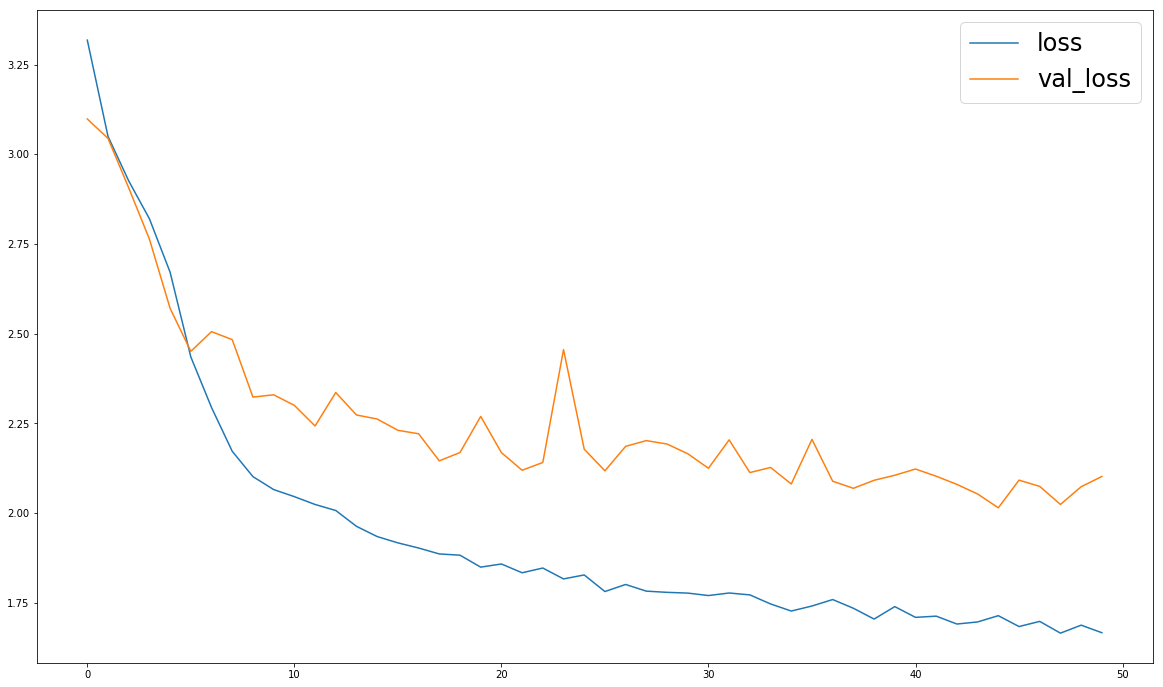

In [9]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

The validation loss has been decreasing at a similar pace as the training loss, indicating that our model has been learning effectively over the last 30 epochs. We could try to train longer and see if the validation loss can be decreased further. Once the validation loss stops decreasing for a couple of epochs in a row, that's when we will want to stop training. Our final weights will then be the weights of the epoch that had the lowest validation loss.

### 5. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator which we've already set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [10]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

In [95]:
# 2: Generate samples

batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: udacity_driving_datasets/1478899814522325128.jpg

Ground truth boxes:

[[  1 127 141 151 214]
 [  1 183 149 353 216]
 [  1 381 128 478 194]
 [  3  70 138  89 190]
 [  3  74 131 119 222]
 [  3 126 139 163 217]
 [  3 183 142 205 171]
 [  3 213 138 230 180]
 [  3 272 140 285 154]
 [  3 273 135 287 153]
 [  3 345 134 364 181]]


In [96]:
# 3: Make a prediction

y_pred = model.predict(batch_images)

Now let's decode the raw predictions in `y_pred`.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a `DecodeDetections` layer and `y_pred` would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions.

In [97]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.25,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.99 374.27 131.63 472.97 199.24]
 [  1.     0.74 186.88 149.12 275.96 211.31]
 [  1.     0.37 201.69 154.11 342.44 215.66]
 [  1.     0.29 434.78 135.46 479.41 170.57]
 [  3.     0.28 133.41 168.38 148.84 217.04]
 [  3.     0.27 120.23 137.84 144.39 207.06]
 [  3.     0.27  80.94 134.49 108.42 221.21]]


Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

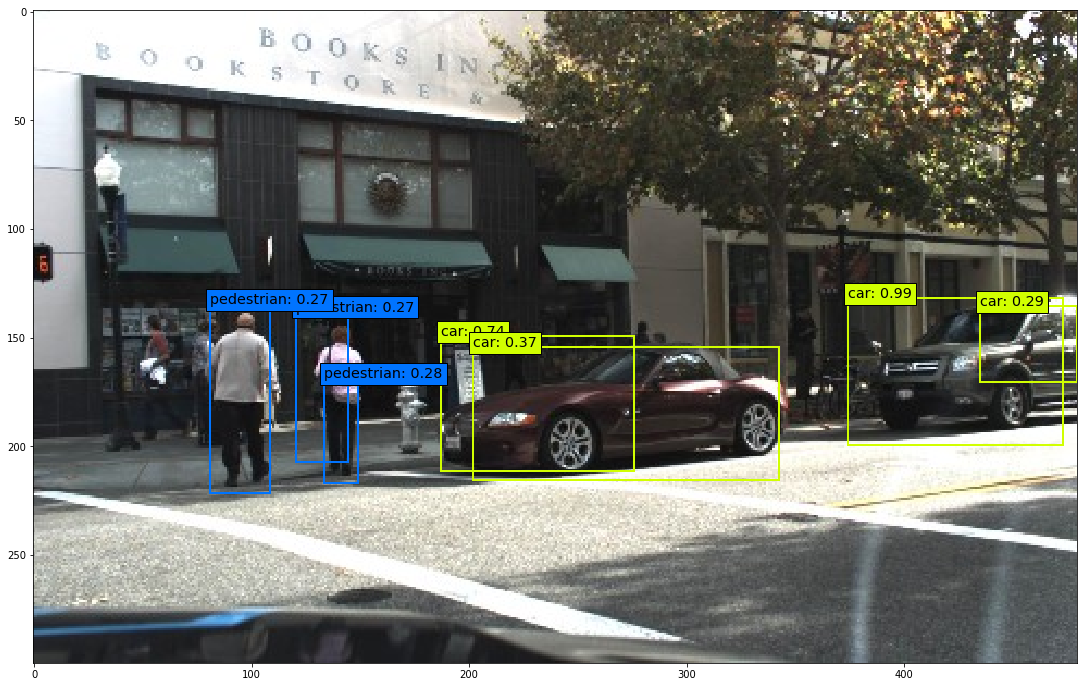

In [98]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(batch_images[0])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs
"""
# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})
"""
# Draw the predicted boxes in blue
for box in y_pred_decoded[0]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='black', bbox={'facecolor':color, 'alpha':1.0})